In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
sklearn 0.20.2
scipy 1.1.0
matplotlib 3.0.2
tensorflow 1.13.1


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import tensorflow as tf

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 딥러닝

### 8.1.

_문제: He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요._

다음 연습문제도 비슷한 모델을 만들어야하므로 여기서 DNN을 구성하는 함수를 만들겠습니다:

In [4]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [5]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


### 8.2.

_문제: Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요._

비용 함수, 훈련 연산과 다른 필요한 구성 요소를 만듭니다:

In [6]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

MNIST 데이터셋을 로드합니다:

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

훈련 세트, 검증 세트, 테스트 세트를 만듭니다(검증 세트는 조기 종료에 사용합니다):

In [8]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [9]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.161705	최선의 손실: 0.161705	정확도: 96.56%
1	검증 세트 손실: 1.224550	최선의 손실: 0.161705	정확도: 37.22%
2	검증 세트 손실: 0.219565	최선의 손실: 0.161705	정확도: 96.09%
3	검증 세트 손실: 0.189125	최선의 손실: 0.161705	정확도: 97.11%
4	검증 세트 손실: 0.189588	최선의 손실: 0.161705	정확도: 96.40%
5	검증 세트 손실: 0.183252	최선의 손실: 0.161705	정확도: 97.11%
6	검증 세트 손실: 0.235175	최선의 손실: 0.161705	정확도: 95.54%
7	검증 세트 손실: 0.239276	최선의 손실: 0.161705	정확도: 96.87%
8	검증 세트 손실: 0.193213	최선의 손실: 0.161705	정확도: 97.62%
9	검증 세트 손실: 0.254931	최선의 손실: 0.161705	정확도: 97.03%
10	검증 세트 손실: 0.170333	최선의 손실: 0.161705	정확도: 97.26%
11	검증 세트 손실: 0.183142	최선의 손실: 0.161705	정확도: 97.38%
12	검증 세트 손실: 0.165072	최선의 손실: 0.161705	정확도: 97.62%
13	검증 세트 손실: 0.287263	최선의 손실: 0.161705	정확도: 95.82%
14	검증 세트 손실: 0.180744	최선의 손실: 0.161705	정확도: 97.58%
15	검증 세트 손실: 0.191835	최선의 손실: 0.161705	정확도: 97.69%
16	검증 세트 손실: 0.198290	최선의 손실: 0.161705	정확도: 98.08%
17	검증 세트 손실: 0.244855	최선의 손실: 0.161705	정확도: 97.22%
18	검증 세트 손실: 0.189315	최선의 손실: 0.161705	정확도: 97.89%
19	검증 세트 손실: 3.665245	최선의 손실: 0.161705	정확

아주 나쁘지는 않지만 하이퍼파라미터를 튜닝하여 더 개선할 수 있을지 보겠습니다.

### 8.3.

_문제: 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요._

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

이 클래스를 사용하여 이전과 비슷한 정확도가 나오는지 확인해 보죠(드롭아웃과 배치 정규화는 사용하지 않습니다):

In [11]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.161705	최선의 손실: 0.161705	정확도: 96.56%
1	검증 세트 손실: 1.224550	최선의 손실: 0.161705	정확도: 37.22%
2	검증 세트 손실: 0.219565	최선의 손실: 0.161705	정확도: 96.09%
3	검증 세트 손실: 0.189125	최선의 손실: 0.161705	정확도: 97.11%
4	검증 세트 손실: 0.189588	최선의 손실: 0.161705	정확도: 96.40%
5	검증 세트 손실: 0.183252	최선의 손실: 0.161705	정확도: 97.11%
6	검증 세트 손실: 0.235175	최선의 손실: 0.161705	정확도: 95.54%
7	검증 세트 손실: 0.239276	최선의 손실: 0.161705	정확도: 96.87%
8	검증 세트 손실: 0.193213	최선의 손실: 0.161705	정확도: 97.62%
9	검증 세트 손실: 0.254931	최선의 손실: 0.161705	정확도: 97.03%
10	검증 세트 손실: 0.170333	최선의 손실: 0.161705	정확도: 97.26%
11	검증 세트 손실: 0.183142	최선의 손실: 0.161705	정확도: 97.38%
12	검증 세트 손실: 0.165072	최선의 손실: 0.161705	정확도: 97.62%
13	검증 세트 손실: 0.287263	최선의 손실: 0.161705	정확도: 95.82%
14	검증 세트 손실: 0.180744	최선의 손실: 0.161705	정확도: 97.58%
15	검증 세트 손실: 0.191835	최선의 손실: 0.161705	정확도: 97.69%
16	검증 세트 손실: 0.198290	최선의 손실: 0.161705	정확도: 98.08%
17	검증 세트 손실: 0.244855	최선의 손실: 0.161705	정확도: 97.22%
18	검증 세트 손실: 0.189315	최선의 손실: 0.161705	정확도: 97.89%
19	검증 세트 손실: 3.665245	최선의 손실: 0.161705	정확

DNNClassifier(activation=<function elu at 0x7f8ec4ceef28>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f8eb8842e80>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

모델 훈련이 완료되면 이전과 비슷한 정확도가 나오는지 확인해 보겠습니다:

In [12]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9653629110721931

좋네요! 잘 작동합니다. 이제 사이킷런의 `RandomizedSearchCV` 클래스를 사용해서 더 나은 하이퍼파라미터를 찾아보겠습니다(시스템에 따라 이 작업은 한 시간 이상 걸릴지 모릅니다):

*사이킷런 0.22 버전에서 cross_val_score 함수와 GridSearchCV, RandomizedSearchCV 클래스의 cv 매개변수 기본값이 3에서 5로 바뀔 예정입니다. 0.20 버전에서 cv 매개변수를 지정하지 않는 경우 이에 관한 경고 메세지가 출력됩니다. 경고 메세지를 피하기 위해 cv 매개변수 값을 명시적으로 3으로 지정합니다.*

In [13]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

# 생성자에 넘겨주는 fit_params 매개변수는 사이킷런 0.19 버전부터 경고가 발생하고 0.21 버전에서 사라지므로
# 대신 fit() 메서드에 매개변수로 전달해야 합니다.:
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x7f8ec4ceef28> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	검증 세트 손실: 0.169612	최선의 손실: 0.169612	정확도: 95.86%
1	검증 세트 손실: 0.137028	최선의 손실: 0.137028	정확도: 96.36%
2	검증 세트 손실: 0.154441	최선의 손실: 0.137028	정확도: 96.48%
3	검증 세트 손실: 0.134872	최선의 손실: 0.134872	정확도: 96.79%
4	검증 세트 손실: 0.099001	최선의 손실: 0.099001	정확도: 97.30%
5	검증 세트 손실: 0.126843	최선의 손실: 0.099001	정확도: 97.30%
6	검증 세트 손실: 0.128056	최선의 손실: 0.099001	정확도: 96.91%
7	검증 세트 손실: 0.169414	최선의 손실: 0.099001	정확도: 96.40%
8	검증 세트 손실: 1.639446	최선의 손실: 0.099001	정확도: 19.51%
9	검증 세트 손실: 1.711398	최선의 손실: 0.099001	정확도: 19.08%
10	검증 세트 손실: 1.608588	최선의 손실: 0.099001	정확도: 21.50%
11	검증 세트 손실: 1.614693	최선의 손실: 0.099001	정확도: 20.91%
12	검증 세트 손실: 1.626087	최선의 손실: 0.099001	정확도: 20.91%
13	검증 세트 손실: 1.641145	최선의 손실: 0.099001	정확도: 18.73%
14	검증 세트 손실: 1.614413	최선의 손실: 0.099001	정확도: 22.01%
15	검증 세트 손실: 1.618399	최선의 손실: 0.099001	정확도: 22.01%
16	검증 세트 손실: 1.610849	최선의 손실: 0.099001	정확도: 22.01%
17	검증 세트 손실: 1.618682	최선의 손실: 0.099001	정확도: 19.27%
18	검증 세트 손실: 1.612818	최선의 손실: 0.099001	정확도: 18.73%
19	검증 세트 손실: 1.614698	최선의 손실: 0.099001	정확

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


0	검증 세트 손실: 0.161831	최선의 손실: 0.161831	정확도: 96.21%
1	검증 세트 손실: 0.115342	최선의 손실: 0.115342	정확도: 97.11%
2	검증 세트 손실: 0.141663	최선의 손실: 0.115342	정확도: 97.19%
3	검증 세트 손실: 0.180142	최선의 손실: 0.115342	정확도: 96.40%
4	검증 세트 손실: 0.152933	최선의 손실: 0.115342	정확도: 96.64%
5	검증 세트 손실: 0.134434	최선의 손실: 0.115342	정확도: 97.19%
6	검증 세트 손실: 0.110120	최선의 손실: 0.110120	정확도: 97.30%
7	검증 세트 손실: 0.129287	최선의 손실: 0.110120	정확도: 97.22%
8	검증 세트 손실: 1.816588	최선의 손실: 0.110120	정확도: 39.05%
9	검증 세트 손실: 1.382134	최선의 손실: 0.110120	정확도: 32.64%
10	검증 세트 손실: 1.228535	최선의 손실: 0.110120	정확도: 39.87%
11	검증 세트 손실: 1.202906	최선의 손실: 0.110120	정확도: 39.52%
12	검증 세트 손실: 1.219439	최선의 손실: 0.110120	정확도: 39.95%
13	검증 세트 손실: 1.223669	최선의 손실: 0.110120	정확도: 39.01%
14	검증 세트 손실: 1.150941	최선의 손실: 0.110120	정확도: 41.95%
15	검증 세트 손실: 1.151576	최선의 손실: 0.110120	정확도: 41.95%
16	검증 세트 손실: 1.164400	최선의 손실: 0.110120	정확도: 40.19%
17	검증 세트 손실: 1.155117	최선의 손실: 0.110120	정확도: 41.87%
18	검증 세트 손실: 1.168984	최선의 손실: 0.110120	정확도: 39.91%
19	검증 세트 손실: 1.156087	최선의 손실: 0.110120	정확

0	검증 세트 손실: 0.396929	최선의 손실: 0.396929	정확도: 88.55%
1	검증 세트 손실: 6.478924	최선의 손실: 0.396929	정확도: 79.91%
2	검증 세트 손실: 1.505791	최선의 손실: 0.396929	정확도: 80.69%
3	검증 세트 손실: 1.195650	최선의 손실: 0.396929	정확도: 80.61%
4	검증 세트 손실: 2.563684	최선의 손실: 0.396929	정확도: 69.23%
5	검증 세트 손실: 536.572937	최선의 손실: 0.396929	정확도: 45.19%
6	검증 세트 손실: 89.243279	최선의 손실: 0.396929	정확도: 78.11%
7	검증 세트 손실: 79.655708	최선의 손실: 0.396929	정확도: 71.97%
8	검증 세트 손실: 122.312195	최선의 손실: 0.396929	정확도: 74.75%
9	검증 세트 손실: 47.916676	최선의 손실: 0.396929	정확도: 91.63%
10	검증 세트 손실: 58.104256	최선의 손실: 0.396929	정확도: 91.91%
11	검증 세트 손실: 44.203144	최선의 손실: 0.396929	정확도: 90.58%
12	검증 세트 손실: 33.199314	최선의 손실: 0.396929	정확도: 94.25%
13	검증 세트 손실: 34.830338	최선의 손실: 0.396929	정확도: 92.14%
14	검증 세트 손실: 30.196430	최선의 손실: 0.396929	정확도: 92.89%
15	검증 세트 손실: 23.511036	최선의 손실: 0.396929	정확도: 93.94%
16	검증 세트 손실: 66.064659	최선의 손실: 0.396929	정확도: 87.57%
17	검증 세트 손실: 154.809708	최선의 손실: 0.396929	정확도: 70.48%
18	검증 세트 손실: 157.595306	최선의 손실: 0.396929	정확도: 67.12%
19	검증 세트 손실: 46.421604	

1	검증 세트 손실: 10.508960	최선의 손실: 10.508960	정확도: 91.99%
2	검증 세트 손실: 9.558105	최선의 손실: 9.558105	정확도: 89.48%
3	검증 세트 손실: 3.672984	최선의 손실: 3.672984	정확도: 92.65%
4	검증 세트 손실: 110.740875	최선의 손실: 3.672984	정확도: 67.90%
5	검증 세트 손실: 14681.238281	최선의 손실: 3.672984	정확도: 84.36%
6	검증 세트 손실: 7871.326172	최선의 손실: 3.672984	정확도: 90.19%
7	검증 세트 손실: 5917.387207	최선의 손실: 3.672984	정확도: 88.19%
8	검증 세트 손실: 9985.247070	최선의 손실: 3.672984	정확도: 85.34%
9	검증 세트 손실: 8143.510742	최선의 손실: 3.672984	정확도: 91.28%
10	검증 세트 손실: 3778.364258	최선의 손실: 3.672984	정확도: 92.18%
11	검증 세트 손실: 4556.745605	최선의 손실: 3.672984	정확도: 91.91%
12	검증 세트 손실: 2902.612305	최선의 손실: 3.672984	정확도: 92.85%
13	검증 세트 손실: 2551.194336	최선의 손실: 3.672984	정확도: 92.49%
14	검증 세트 손실: 8609.489258	최선의 손실: 3.672984	정확도: 84.79%
15	검증 세트 손실: 4247.188477	최선의 손실: 3.672984	정확도: 91.40%
16	검증 세트 손실: 2113.531250	최선의 손실: 3.672984	정확도: 93.98%
17	검증 세트 손실: 41574.953125	최선의 손실: 3.672984	정확도: 91.75%
18	검증 세트 손실: 34662.796875	최선의 손실: 3.672984	정확도: 94.80%
19	검증 세트 손실: 31649.097656	최선의 손실: 3.672984

4	검증 세트 손실: 0.054328	최선의 손실: 0.054328	정확도: 98.32%
5	검증 세트 손실: 0.067437	최선의 손실: 0.054328	정확도: 98.12%
6	검증 세트 손실: 0.036356	최선의 손실: 0.036356	정확도: 98.83%
7	검증 세트 손실: 0.057743	최선의 손실: 0.036356	정확도: 98.40%
8	검증 세트 손실: 0.046037	최선의 손실: 0.036356	정확도: 98.71%
9	검증 세트 손실: 0.045686	최선의 손실: 0.036356	정확도: 98.83%
10	검증 세트 손실: 0.044433	최선의 손실: 0.036356	정확도: 99.02%
11	검증 세트 손실: 0.046541	최선의 손실: 0.036356	정확도: 98.67%
12	검증 세트 손실: 0.062337	최선의 손실: 0.036356	정확도: 98.48%
13	검증 세트 손실: 0.065704	최선의 손실: 0.036356	정확도: 98.48%
14	검증 세트 손실: 0.056532	최선의 손실: 0.036356	정확도: 98.59%
15	검증 세트 손실: 0.057653	최선의 손실: 0.036356	정확도: 98.94%
16	검증 세트 손실: 0.036613	최선의 손실: 0.036356	정확도: 99.10%
17	검증 세트 손실: 0.050595	최선의 손실: 0.036356	정확도: 98.94%
18	검증 세트 손실: 0.060675	최선의 손실: 0.036356	정확도: 98.71%
19	검증 세트 손실: 0.052941	최선의 손실: 0.036356	정확도: 98.83%
20	검증 세트 손실: 0.045952	최선의 손실: 0.036356	정확도: 99.10%
21	검증 세트 손실: 0.083539	최선의 손실: 0.036356	정확도: 98.36%
22	검증 세트 손실: 0.087613	최선의 손실: 0.036356	정확도: 98.67%
23	검증 세트 손실: 0.054027	최선의 손실: 0.03635

29	검증 세트 손실: 0.072556	최선의 손실: 0.047549	정확도: 98.91%
30	검증 세트 손실: 0.084082	최선의 손실: 0.047549	정확도: 98.59%
31	검증 세트 손실: 0.082196	최선의 손실: 0.047549	정확도: 98.79%
32	검증 세트 손실: 0.068429	최선의 손실: 0.047549	정확도: 98.91%
33	검증 세트 손실: 0.060926	최선의 손실: 0.047549	정확도: 98.87%
34	검증 세트 손실: 0.059046	최선의 손실: 0.047549	정확도: 98.98%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, activation=<function elu at 0x7f8ec4ceef28>, total=   8.8s
[CV] n_neurons=140, learning_rate=0.01, batch_size=500, activation=<function elu at 0x7f8ec4ceef28> 
0	검증 세트 손실: 0.108754	최선의 손실: 0.108754	정확도: 96.68%
1	검증 세트 손실: 0.076621	최선의 손실: 0.076621	정확도: 97.54%
2	검증 세트 손실: 0.066869	최선의 손실: 0.066869	정확도: 98.08%
3	검증 세트 손실: 0.059805	최선의 손실: 0.059805	정확도: 98.20%
4	검증 세트 손실: 0.050830	최선의 손실: 0.050830	정확도: 98.36%
5	검증 세트 손실: 0.050915	최선의 손실: 0.050830	정확도: 98.32%
6	검증 세트 손실: 0.054090	최선의 손실: 0.050830	정확도: 98.44%
7	검증 세트 손실: 0.041230	최선의 손실: 0.041230	정확도: 98.71%
8	검증 세트 손실: 0.049005	최선의 손실: 0.041230	정확도: 98.51%
9	검증 세트 손실: 0.056138

9	검증 세트 손실: 1.615554	최선의 손실: 1.614131	정확도: 20.91%
10	검증 세트 손실: 1.619121	최선의 손실: 1.614131	정확도: 22.01%
11	검증 세트 손실: 1.639597	최선의 손실: 1.614131	정확도: 22.01%
12	검증 세트 손실: 1.627611	최선의 손실: 1.614131	정확도: 19.08%
13	검증 세트 손실: 1.615012	최선의 손실: 1.614131	정확도: 19.08%
14	검증 세트 손실: 1.624332	최선의 손실: 1.614131	정확도: 19.08%
15	검증 세트 손실: 1.612443	최선의 손실: 1.612443	정확도: 22.01%
16	검증 세트 손실: 1.627838	최선의 손실: 1.612443	정확도: 22.01%
17	검증 세트 손실: 1.613231	최선의 손실: 1.612443	정확도: 18.73%
18	검증 세트 손실: 1.615750	최선의 손실: 1.612443	정확도: 22.01%
19	검증 세트 손실: 1.619094	최선의 손실: 1.612443	정확도: 22.01%
20	검증 세트 손실: 1.609112	최선의 손실: 1.609112	정확도: 22.01%
21	검증 세트 손실: 1.689015	최선의 손실: 1.609112	정확도: 22.01%
22	검증 세트 손실: 1.618887	최선의 손실: 1.609112	정확도: 18.73%
23	검증 세트 손실: 1.638923	최선의 손실: 1.609112	정확도: 22.01%
24	검증 세트 손실: 1.660611	최선의 손실: 1.609112	정확도: 20.91%
25	검증 세트 손실: 1.619327	최선의 손실: 1.609112	정확도: 19.27%
26	검증 세트 손실: 1.611328	최선의 손실: 1.609112	정확도: 22.01%
27	검증 세트 손실: 1.614297	최선의 손실: 1.609112	정확도: 20.91%
28	검증 세트 손실: 1.628115	최선의 손실: 1.

0	검증 세트 손실: 0.951716	최선의 손실: 0.951716	정확도: 91.24%
1	검증 세트 손실: 2.091279	최선의 손실: 0.951716	정확도: 82.92%
2	검증 세트 손실: 115.965340	최선의 손실: 0.951716	정확도: 36.32%
3	검증 세트 손실: 4.553381	최선의 손실: 0.951716	정확도: 79.95%
4	검증 세트 손실: 2.752819	최선의 손실: 0.951716	정확도: 84.68%
5	검증 세트 손실: 1.339062	최선의 손실: 0.951716	정확도: 86.75%
6	검증 세트 손실: 1.767870	최선의 손실: 0.951716	정확도: 78.30%
7	검증 세트 손실: 0.931114	최선의 손실: 0.931114	정확도: 84.09%
8	검증 세트 손실: 0.878914	최선의 손실: 0.878914	정확도: 87.57%
9	검증 세트 손실: 0.861499	최선의 손실: 0.861499	정확도: 85.85%
10	검증 세트 손실: 1.051922	최선의 손실: 0.861499	정확도: 78.46%
11	검증 세트 손실: 0.581692	최선의 손실: 0.581692	정확도: 89.44%
12	검증 세트 손실: 0.509965	최선의 손실: 0.509965	정확도: 90.30%
13	검증 세트 손실: 0.906986	최선의 손실: 0.509965	정확도: 77.91%
14	검증 세트 손실: 0.664253	최선의 손실: 0.509965	정확도: 88.27%
15	검증 세트 손실: 0.692753	최선의 손실: 0.509965	정확도: 89.72%
16	검증 세트 손실: 0.376335	최선의 손실: 0.376335	정확도: 91.52%
17	검증 세트 손실: 0.463672	최선의 손실: 0.376335	정확도: 90.50%
18	검증 세트 손실: 0.452051	최선의 손실: 0.376335	정확도: 91.28%
19	검증 세트 손실: 0.499479	최선의 손실: 0.376335	

0	검증 세트 손실: 0.100823	최선의 손실: 0.100823	정확도: 97.03%
1	검증 세트 손실: 0.091461	최선의 손실: 0.091461	정확도: 97.81%
2	검증 세트 손실: 0.068144	최선의 손실: 0.068144	정확도: 97.93%
3	검증 세트 손실: 0.062620	최선의 손실: 0.062620	정확도: 98.32%
4	검증 세트 손실: 0.077762	최선의 손실: 0.062620	정확도: 97.97%
5	검증 세트 손실: 0.116759	최선의 손실: 0.062620	정확도: 96.87%
6	검증 세트 손실: 0.098177	최선의 손실: 0.062620	정확도: 97.65%
7	검증 세트 손실: 0.100118	최선의 손실: 0.062620	정확도: 97.62%
8	검증 세트 손실: 0.088412	최선의 손실: 0.062620	정확도: 97.69%
9	검증 세트 손실: 0.108396	최선의 손실: 0.062620	정확도: 98.01%
10	검증 세트 손실: 0.076244	최선의 손실: 0.062620	정확도: 97.97%
11	검증 세트 손실: 1.181290	최선의 손실: 0.062620	정확도: 92.69%
12	검증 세트 손실: 0.090115	최선의 손실: 0.062620	정확도: 97.58%
13	검증 세트 손실: 0.103583	최선의 손실: 0.062620	정확도: 97.69%
14	검증 세트 손실: 0.094801	최선의 손실: 0.062620	정확도: 98.01%
15	검증 세트 손실: 0.072825	최선의 손실: 0.062620	정확도: 98.32%
16	검증 세트 손실: 0.073025	최선의 손실: 0.062620	정확도: 98.20%
17	검증 세트 손실: 0.100266	최선의 손실: 0.062620	정확도: 98.16%
18	검증 세트 손실: 0.075702	최선의 손실: 0.062620	정확도: 98.32%
19	검증 세트 손실: 0.168579	최선의 손실: 0.062620	정확

0	검증 세트 손실: 1.148822	최선의 손실: 1.148822	정확도: 47.07%
1	검증 세트 손실: 1.213831	최선의 손실: 1.148822	정확도: 39.21%
2	검증 세트 손실: 1.158854	최선의 손실: 1.148822	정확도: 39.87%
3	검증 세트 손실: 1.173183	최선의 손실: 1.148822	정확도: 39.09%
4	검증 세트 손실: 1.155171	최선의 손실: 1.148822	정확도: 39.76%
5	검증 세트 손실: 1.197210	최선의 손실: 1.148822	정확도: 40.27%
6	검증 세트 손실: 1.154690	최선의 손실: 1.148822	정확도: 40.50%
7	검증 세트 손실: 1.177344	최선의 손실: 1.148822	정확도: 40.70%
8	검증 세트 손실: 0.850207	최선의 손실: 0.850207	정확도: 59.38%
9	검증 세트 손실: 0.585442	최선의 손실: 0.585442	정확도: 76.94%
10	검증 세트 손실: 1.401432	최선의 손실: 0.585442	정확도: 67.44%
11	검증 세트 손실: 0.443632	최선의 손실: 0.443632	정확도: 89.56%
12	검증 세트 손실: 0.638570	최선의 손실: 0.443632	정확도: 76.97%
13	검증 세트 손실: 0.857933	최선의 손실: 0.443632	정확도: 78.23%
14	검증 세트 손실: 0.654789	최선의 손실: 0.443632	정확도: 78.11%
15	검증 세트 손실: 0.625885	최선의 손실: 0.443632	정확도: 79.05%
16	검증 세트 손실: 0.593792	최선의 손실: 0.443632	정확도: 77.80%
17	검증 세트 손실: 0.701244	최선의 손실: 0.443632	정확도: 78.85%
18	검증 세트 손실: 0.526679	최선의 손실: 0.443632	정확도: 79.59%
19	검증 세트 손실: 2.987692	최선의 손실: 0.443632	정확

14	검증 세트 손실: 566.059509	최선의 손실: 0.166873	정확도: 81.59%
15	검증 세트 손실: 250.336609	최선의 손실: 0.166873	정확도: 89.09%
16	검증 세트 손실: 184.179749	최선의 손실: 0.166873	정확도: 88.19%
17	검증 세트 손실: 3015.023926	최선의 손실: 0.166873	정확도: 87.10%
18	검증 세트 손실: 3456.912354	최선의 손실: 0.166873	정확도: 92.03%
19	검증 세트 손실: 907.970276	최선의 손실: 0.166873	정확도: 88.74%
20	검증 세트 손실: 497.557770	최선의 손실: 0.166873	정확도: 93.71%
21	검증 세트 손실: 279.949585	최선의 손실: 0.166873	정확도: 94.53%
22	검증 세트 손실: 218.020370	최선의 손실: 0.166873	정확도: 95.82%
23	검증 세트 손실: 197.380722	최선의 손실: 0.166873	정확도: 95.35%
24	검증 세트 손실: 639.380310	최선의 손실: 0.166873	정확도: 83.15%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e9895a400>, total=  11.0s
[CV] n_neurons=100, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e9895a400> 
0	검증 세트 손실: 28561.357422	최선의 손실: 28561.357422	정확도: 41.28%
1	검증 세트 손실: 1076.284790	최선의 손실: 1076.284790	정확도: 46.76%
2

22	검증 세트 손실: 126555.500000	최선의 손실: 3.127215	정확도: 76.19%
23	검증 세트 손실: 37859.531250	최선의 손실: 3.127215	정확도: 72.63%
24	검증 세트 손실: 35585.226562	최선의 손실: 3.127215	정확도: 80.84%
25	검증 세트 손실: 23134.175781	최선의 손실: 3.127215	정확도: 81.78%
26	검증 세트 손실: 10451.040039	최선의 손실: 3.127215	정확도: 89.01%
27	검증 세트 손실: 6008.763184	최선의 손실: 3.127215	정확도: 92.06%
28	검증 세트 손실: 9381.696289	최선의 손실: 3.127215	정확도: 88.47%
29	검증 세트 손실: 5388.400879	최선의 손실: 3.127215	정확도: 92.22%
30	검증 세트 손실: 26328.181641	최선의 손실: 3.127215	정확도: 73.49%
31	검증 세트 손실: 6009.228516	최선의 손실: 3.127215	정확도: 91.13%
32	검증 세트 손실: 7528.229980	최선의 손실: 3.127215	정확도: 87.14%
33	검증 세트 손실: 3268.595703	최선의 손실: 3.127215	정확도: 94.49%
34	검증 세트 손실: 5617.716797	최선의 손실: 3.127215	정확도: 93.90%
35	검증 세트 손실: 4708.864746	최선의 손실: 3.127215	정확도: 94.06%
36	검증 세트 손실: 24444.380859	최선의 손실: 3.127215	정확도: 88.78%
37	검증 세트 손실: 6551.906738	최선의 손실: 3.127215	정확도: 94.18%
38	검증 세트 손실: 4448.666016	최선의 손실: 3.127215	정확도: 95.47%
39	검증 세트 손실: 3126.424561	최선의 손실: 3.127215	정확도: 94.57%
조기 종료!
[CV]  n_neuro

20	검증 세트 손실: 0.079976	최선의 손실: 0.048505	정확도: 98.51%
21	검증 세트 손실: 0.067650	최선의 손실: 0.048505	정확도: 98.55%
22	검증 세트 손실: 0.073264	최선의 손실: 0.048505	정확도: 98.48%
23	검증 세트 손실: 0.079828	최선의 손실: 0.048505	정확도: 98.59%
24	검증 세트 손실: 0.069711	최선의 손실: 0.048505	정확도: 98.44%
25	검증 세트 손실: 0.087333	최선의 손실: 0.048505	정확도: 98.71%
26	검증 세트 손실: 0.092510	최선의 손실: 0.048505	정확도: 98.59%
27	검증 세트 손실: 0.104338	최선의 손실: 0.048505	정확도: 98.28%
28	검증 세트 손실: 0.079420	최선의 손실: 0.048505	정확도: 98.75%
29	검증 세트 손실: 0.085931	최선의 손실: 0.048505	정확도: 98.67%
30	검증 세트 손실: 0.081857	최선의 손실: 0.048505	정확도: 98.51%
31	검증 세트 손실: 0.093568	최선의 손실: 0.048505	정확도: 98.28%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x7f8ec4ceef28>, total=   5.7s
[CV] n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x7f8ec4ceef28> 
0	검증 세트 손실: 0.142724	최선의 손실: 0.142724	정확도: 96.09%
1	검증 세트 손실: 0.077564	최선의 손실: 0.077564	정확도: 97.54%
2	검증 세트 손실: 0.068069	최선의 손실: 0.068069	정확도: 97.81%
3	검증 세트 손실: 0.05

11	검증 세트 손실: 0.885283	최선의 손실: 0.146185	정확도: 57.23%
12	검증 세트 손실: 0.825017	최선의 손실: 0.146185	정확도: 62.59%
13	검증 세트 손실: 0.744610	최선의 손실: 0.146185	정확도: 66.69%
14	검증 세트 손실: 0.783117	최선의 손실: 0.146185	정확도: 63.10%
15	검증 세트 손실: 0.719829	최선의 손실: 0.146185	정확도: 68.18%
16	검증 세트 손실: 0.745726	최선의 손실: 0.146185	정확도: 67.44%
17	검증 세트 손실: 0.831390	최선의 손실: 0.146185	정확도: 63.10%
18	검증 세트 손실: 0.704464	최선의 손실: 0.146185	정확도: 68.37%
19	검증 세트 손실: 0.519329	최선의 손실: 0.146185	정확도: 83.70%
20	검증 세트 손실: 0.706356	최선의 손실: 0.146185	정확도: 69.47%
21	검증 세트 손실: 0.731465	최선의 손실: 0.146185	정확도: 74.28%
22	검증 세트 손실: 0.811508	최선의 손실: 0.146185	정확도: 71.85%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.05, batch_size=50, activation=<function relu at 0x7f8ec4c8c510>, total=   5.8s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598> 
0	검증 세트 손실: 0.186992	최선의 손실: 0.186992	정확도: 95.07%
1	검증 세트 손실: 0.133227	최선의 손실: 0.133227	정확도: 96.17%
2	검증 세트 손실: 0.155530	최선의 손

0	검증 세트 손실: 0.218326	최선의 손실: 0.218326	정확도: 95.62%
1	검증 세트 손실: 0.139652	최선의 손실: 0.139652	정확도: 96.48%
2	검증 세트 손실: 0.185367	최선의 손실: 0.139652	정확도: 95.97%
3	검증 세트 손실: 0.503665	최선의 손실: 0.139652	정확도: 84.21%
4	검증 세트 손실: 0.306959	최선의 손실: 0.139652	정확도: 92.34%
5	검증 세트 손실: 0.312952	최선의 손실: 0.139652	정확도: 92.65%
6	검증 세트 손실: 0.321531	최선의 손실: 0.139652	정확도: 93.55%
7	검증 세트 손실: 0.217648	최선의 손실: 0.139652	정확도: 95.47%
8	검증 세트 손실: 0.443441	최선의 손실: 0.139652	정확도: 75.53%
9	검증 세트 손실: 0.296745	최선의 손실: 0.139652	정확도: 93.59%
10	검증 세트 손실: 0.235967	최선의 손실: 0.139652	정확도: 95.04%
11	검증 세트 손실: 0.506821	최선의 손실: 0.139652	정확도: 93.90%
12	검증 세트 손실: 0.451871	최선의 손실: 0.139652	정확도: 92.49%
13	검증 세트 손실: 1.391686	최선의 손실: 0.139652	정확도: 93.86%
14	검증 세트 손실: 0.550413	최선의 손실: 0.139652	정확도: 93.39%
15	검증 세트 손실: 0.399842	최선의 손실: 0.139652	정확도: 95.35%
16	검증 세트 손실: 2.315573	최선의 손실: 0.139652	정확도: 94.06%
17	검증 세트 손실: 0.433348	최선의 손실: 0.139652	정확도: 89.25%
18	검증 세트 손실: 0.271465	최선의 손실: 0.139652	정확도: 93.82%
19	검증 세트 손실: 0.309291	최선의 손실: 0.139652	정확

33	검증 세트 손실: 0.741534	최선의 손실: 0.304675	정확도: 91.44%
34	검증 세트 손실: 0.293327	최선의 손실: 0.293327	정확도: 96.87%
35	검증 세트 손실: 0.229800	최선의 손실: 0.229800	정확도: 96.83%
36	검증 세트 손실: 0.443321	최선의 손실: 0.229800	정확도: 95.74%
37	검증 세트 손실: 0.319572	최선의 손실: 0.229800	정확도: 96.21%
38	검증 세트 손실: 0.216998	최선의 손실: 0.216998	정확도: 97.22%
39	검증 세트 손실: 0.252087	최선의 손실: 0.216998	정확도: 96.83%
40	검증 세트 손실: 0.234185	최선의 손실: 0.216998	정확도: 97.03%
41	검증 세트 손실: 0.574896	최선의 손실: 0.216998	정확도: 93.63%
42	검증 세트 손실: 0.430997	최선의 손실: 0.216998	정확도: 97.15%
43	검증 세트 손실: 0.397157	최선의 손실: 0.216998	정확도: 96.72%
44	검증 세트 손실: 0.293270	최선의 손실: 0.216998	정확도: 97.15%
45	검증 세트 손실: 0.336327	최선의 손실: 0.216998	정확도: 96.44%
46	검증 세트 손실: 0.387701	최선의 손실: 0.216998	정확도: 95.70%
47	검증 세트 손실: 0.334939	최선의 손실: 0.216998	정확도: 96.52%
48	검증 세트 손실: 0.241557	최선의 손실: 0.216998	정확도: 97.30%
49	검증 세트 손실: 0.268649	최선의 손실: 0.216998	정확도: 97.11%
50	검증 세트 손실: 0.255088	최선의 손실: 0.216998	정확도: 97.07%
51	검증 세트 손실: 0.260927	최선의 손실: 0.216998	정확도: 96.64%
52	검증 세트 손실: 0.267437	최선의 손실: 0

0	검증 세트 손실: 0.566352	최선의 손실: 0.566352	정확도: 74.59%
1	검증 세트 손실: 0.570032	최선의 손실: 0.566352	정확도: 75.14%
2	검증 세트 손실: 0.541036	최선의 손실: 0.541036	정확도: 76.35%
3	검증 세트 손실: 0.555777	최선의 손실: 0.541036	정확도: 79.20%
4	검증 세트 손실: 0.548118	최선의 손실: 0.541036	정확도: 76.90%
5	검증 세트 손실: 0.593899	최선의 손실: 0.541036	정확도: 75.72%
6	검증 세트 손실: 0.487665	최선의 손실: 0.487665	정확도: 81.90%
7	검증 세트 손실: 0.473824	최선의 손실: 0.473824	정확도: 83.78%
8	검증 세트 손실: 0.424803	최선의 손실: 0.424803	정확도: 87.29%
9	검증 세트 손실: 0.365355	최선의 손실: 0.365355	정확도: 89.68%
10	검증 세트 손실: 0.353226	최선의 손실: 0.353226	정확도: 88.82%
11	검증 세트 손실: 0.758854	최선의 손실: 0.353226	정확도: 60.56%
12	검증 세트 손실: 0.764915	최선의 손실: 0.353226	정확도: 60.56%
13	검증 세트 손실: 0.774055	최선의 손실: 0.353226	정확도: 60.20%
14	검증 세트 손실: 0.742843	최선의 손실: 0.353226	정확도: 60.36%
15	검증 세트 손실: 0.752301	최선의 손실: 0.353226	정확도: 59.77%
16	검증 세트 손실: 0.764330	최선의 손실: 0.353226	정확도: 59.54%
17	검증 세트 손실: 0.799040	최선의 손실: 0.353226	정확도: 58.60%
18	검증 세트 손실: 0.748442	최선의 손실: 0.353226	정확도: 60.16%
19	검증 세트 손실: 0.744866	최선의 손실: 0.353226	정확

0	검증 세트 손실: 0.394790	최선의 손실: 0.394790	정확도: 92.77%
1	검증 세트 손실: 0.149463	최선의 손실: 0.149463	정확도: 95.86%
2	검증 세트 손실: 0.117006	최선의 손실: 0.117006	정확도: 96.52%
3	검증 세트 손실: 0.110410	최선의 손실: 0.110410	정확도: 96.60%
4	검증 세트 손실: 0.101255	최선의 손실: 0.101255	정확도: 96.87%
5	검증 세트 손실: 0.093461	최선의 손실: 0.093461	정확도: 97.42%
6	검증 세트 손실: 0.092672	최선의 손실: 0.092672	정확도: 97.03%
7	검증 세트 손실: 0.085061	최선의 손실: 0.085061	정확도: 97.50%
8	검증 세트 손실: 0.092167	최선의 손실: 0.085061	정확도: 97.34%
9	검증 세트 손실: 0.103642	최선의 손실: 0.085061	정확도: 96.95%
10	검증 세트 손실: 0.090204	최선의 손실: 0.085061	정확도: 97.54%
11	검증 세트 손실: 0.086944	최선의 손실: 0.085061	정확도: 97.58%
12	검증 세트 손실: 0.076301	최선의 손실: 0.076301	정확도: 97.81%
13	검증 세트 손실: 0.080905	최선의 손실: 0.076301	정확도: 97.81%
14	검증 세트 손실: 0.102347	최선의 손실: 0.076301	정확도: 97.34%
15	검증 세트 손실: 0.083201	최선의 손실: 0.076301	정확도: 97.93%
16	검증 세트 손실: 0.089948	최선의 손실: 0.076301	정확도: 97.46%
17	검증 세트 손실: 0.098370	최선의 손실: 0.076301	정확도: 97.30%
18	검증 세트 손실: 0.090863	최선의 손실: 0.076301	정확도: 97.46%
19	검증 세트 손실: 0.099144	최선의 손실: 0.076301	정확

0	검증 세트 손실: 0.158430	최선의 손실: 0.158430	정확도: 96.44%
1	검증 세트 손실: 0.085704	최선의 손실: 0.085704	정확도: 97.77%
2	검증 세트 손실: 0.108427	최선의 손실: 0.085704	정확도: 97.03%
3	검증 세트 손실: 0.076443	최선의 손실: 0.076443	정확도: 98.01%
4	검증 세트 손실: 0.071128	최선의 손실: 0.071128	정확도: 98.16%
5	검증 세트 손실: 0.123939	최선의 손실: 0.071128	정확도: 97.34%
6	검증 세트 손실: 0.126308	최선의 손실: 0.071128	정확도: 96.29%
7	검증 세트 손실: 0.108919	최선의 손실: 0.071128	정확도: 96.91%
8	검증 세트 손실: 0.081721	최선의 손실: 0.071128	정확도: 97.81%
9	검증 세트 손실: 0.119417	최선의 손실: 0.071128	정확도: 97.26%
10	검증 세트 손실: 0.087401	최선의 손실: 0.071128	정확도: 97.93%
11	검증 세트 손실: 0.082822	최선의 손실: 0.071128	정확도: 97.65%
12	검증 세트 손실: 0.139534	최선의 손실: 0.071128	정확도: 97.77%
13	검증 세트 손실: 0.075277	최선의 손실: 0.071128	정확도: 98.12%
14	검증 세트 손실: 0.095059	최선의 손실: 0.071128	정확도: 98.05%
15	검증 세트 손실: 0.083915	최선의 손실: 0.071128	정확도: 98.36%
16	검증 세트 손실: 0.097499	최선의 손실: 0.071128	정확도: 97.62%
17	검증 세트 손실: 0.091903	최선의 손실: 0.071128	정확도: 98.01%
18	검증 세트 손실: 0.578454	최선의 손실: 0.071128	정확도: 93.39%
19	검증 세트 손실: 0.104725	최선의 손실: 0.071128	정확

4	검증 세트 손실: 2.674482	최선의 손실: 1.752184	정확도: 20.91%
5	검증 세트 손실: 3.170716	최선의 손실: 1.752184	정확도: 20.91%
6	검증 세트 손실: 2.329651	최선의 손실: 1.752184	정확도: 20.91%
7	검증 세트 손실: 2.229480	최선의 손실: 1.752184	정확도: 19.27%
8	검증 세트 손실: 2.274400	최선의 손실: 1.752184	정확도: 22.01%
9	검증 세트 손실: 2.208699	최선의 손실: 1.752184	정확도: 22.01%
10	검증 세트 손실: 2.130490	최선의 손실: 1.752184	정확도: 18.73%
11	검증 세트 손실: 2.541695	최선의 손실: 1.752184	정확도: 19.08%
12	검증 세트 손실: 4.161201	최선의 손실: 1.752184	정확도: 20.91%
13	검증 세트 손실: 2.705544	최선의 손실: 1.752184	정확도: 22.01%
14	검증 세트 손실: 2.812274	최선의 손실: 1.752184	정확도: 19.27%
15	검증 세트 손실: 2.892021	최선의 손실: 1.752184	정확도: 18.73%
16	검증 세트 손실: 2.830200	최선의 손실: 1.752184	정확도: 20.91%
17	검증 세트 손실: 2.845695	최선의 손실: 1.752184	정확도: 20.91%
18	검증 세트 손실: 3.050031	최선의 손실: 1.752184	정확도: 20.91%
19	검증 세트 손실: 1.988322	최선의 손실: 1.752184	정확도: 22.01%
20	검증 세트 손실: 2.268836	최선의 손실: 1.752184	정확도: 19.08%
21	검증 세트 손실: 3.946499	최선의 손실: 1.752184	정확도: 19.27%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=10, activation=<function elu a

44	검증 세트 손실: 416.549988	최선의 손실: 0.138413	정확도: 70.88%
45	검증 세트 손실: 209.800720	최선의 손실: 0.138413	정확도: 74.04%
46	검증 세트 손실: 291.509277	최선의 손실: 0.138413	정확도: 64.11%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e9895a400>, total=   6.1s
[CV] n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e9895a400> 
0	검증 세트 손실: 20.778124	최선의 손실: 20.778124	정확도: 23.46%
1	검증 세트 손실: 0.841452	최선의 손실: 0.841452	정확도: 60.20%
2	검증 세트 손실: 38.603653	최선의 손실: 0.841452	정확도: 19.51%
3	검증 세트 손실: 46.469101	최선의 손실: 0.841452	정확도: 38.31%
4	검증 세트 손실: 56.912247	최선의 손실: 0.841452	정확도: 41.75%
5	검증 세트 손실: 65.621674	최선의 손실: 0.841452	정확도: 25.06%
6	검증 세트 손실: 52.181984	최선의 손실: 0.841452	정확도: 29.05%
7	검증 세트 손실: 16.714733	최선의 손실: 0.841452	정확도: 39.72%
8	검증 세트 손실: 38.031467	최선의 손실: 0.841452	정확도: 38.19%
9	검증 세트 손실: 66.451088	최선의 손실: 0.841452	정확도: 20.91%
10	검증 세트 손실: 250.794937	최선의 손실:

0	검증 세트 손실: 0.196188	최선의 손실: 0.196188	정확도: 95.04%
1	검증 세트 손실: 0.106764	최선의 손실: 0.106764	정확도: 96.44%
2	검증 세트 손실: 0.080421	최선의 손실: 0.080421	정확도: 97.34%
3	검증 세트 손실: 0.070176	최선의 손실: 0.070176	정확도: 97.93%
4	검증 세트 손실: 0.060331	최선의 손실: 0.060331	정확도: 98.24%
5	검증 세트 손실: 0.058828	최선의 손실: 0.058828	정확도: 98.28%
6	검증 세트 손실: 0.085333	최선의 손실: 0.058828	정확도: 97.81%
7	검증 세트 손실: 0.082869	최선의 손실: 0.058828	정확도: 97.62%
8	검증 세트 손실: 0.074095	최선의 손실: 0.058828	정확도: 97.81%
9	검증 세트 손실: 0.063897	최선의 손실: 0.058828	정확도: 98.32%
10	검증 세트 손실: 0.088539	최선의 손실: 0.058828	정확도: 98.08%
11	검증 세트 손실: 0.087619	최선의 손실: 0.058828	정확도: 98.87%
12	검증 세트 손실: 0.064403	최선의 손실: 0.058828	정확도: 98.75%
13	검증 세트 손실: 0.093617	최선의 손실: 0.058828	정확도: 98.51%
14	검증 세트 손실: 0.128280	최선의 손실: 0.058828	정확도: 98.20%
15	검증 세트 손실: 0.148228	최선의 손실: 0.058828	정확도: 98.63%
16	검증 세트 손실: 0.131943	최선의 손실: 0.058828	정확도: 97.93%
17	검증 세트 손실: 0.161355	최선의 손실: 0.058828	정확도: 98.67%
18	검증 세트 손실: 0.141140	최선의 손실: 0.058828	정확도: 98.98%
19	검증 세트 손실: 0.104495	최선의 손실: 0.058828	정확

16	검증 세트 손실: 0.080579	최선의 손실: 0.067560	정확도: 97.81%
17	검증 세트 손실: 0.087162	최선의 손실: 0.067560	정확도: 97.65%
18	검증 세트 손실: 0.082101	최선의 손실: 0.067560	정확도: 98.16%
19	검증 세트 손실: 0.084787	최선의 손실: 0.067560	정확도: 97.93%
20	검증 세트 손실: 0.096990	최선의 손실: 0.067560	정확도: 97.65%
21	검증 세트 손실: 0.103908	최선의 손실: 0.067560	정확도: 97.69%
22	검증 세트 손실: 0.109099	최선의 손실: 0.067560	정확도: 97.69%
23	검증 세트 손실: 0.102675	최선의 손실: 0.067560	정확도: 97.77%
24	검증 세트 손실: 0.101835	최선의 손실: 0.067560	정확도: 98.05%
25	검증 세트 손실: 0.110644	최선의 손실: 0.067560	정확도: 97.65%
26	검증 세트 손실: 0.100249	최선의 손실: 0.067560	정확도: 97.89%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598>, total=   3.8s
[CV] n_neurons=50, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598> 
0	검증 세트 손실: 0.213180	최선의 손실: 0.213180	정확도: 93.59%
1	검증 세트 손실: 0.124260	최선의 손실: 0.124260	정확도: 96.17%
2	검증 세트 손실: 0.085883	최선의 손실: 0.085883

14	검증 세트 손실: 0.138222	최선의 손실: 0.121019	정확도: 96.95%
15	검증 세트 손실: 0.140306	최선의 손실: 0.121019	정확도: 97.42%
16	검증 세트 손실: 0.150200	최선의 손실: 0.121019	정확도: 97.07%
17	검증 세트 손실: 0.109025	최선의 손실: 0.109025	정확도: 97.42%
18	검증 세트 손실: 0.104251	최선의 손실: 0.104251	정확도: 97.58%
19	검증 세트 손실: 0.121654	최선의 손실: 0.104251	정확도: 97.42%
20	검증 세트 손실: 0.112447	최선의 손실: 0.104251	정확도: 97.81%
21	검증 세트 손실: 0.123894	최선의 손실: 0.104251	정확도: 97.69%
22	검증 세트 손실: 0.099557	최선의 손실: 0.099557	정확도: 97.89%
23	검증 세트 손실: 0.159849	최선의 손실: 0.099557	정확도: 96.91%
24	검증 세트 손실: 0.148704	최선의 손실: 0.099557	정확도: 97.15%
25	검증 세트 손실: 0.125386	최선의 손실: 0.099557	정확도: 97.73%
26	검증 세트 손실: 0.134735	최선의 손실: 0.099557	정확도: 97.42%
27	검증 세트 손실: 0.080927	최선의 손실: 0.080927	정확도: 98.08%
28	검증 세트 손실: 0.105084	최선의 손실: 0.080927	정확도: 98.05%
29	검증 세트 손실: 0.144913	최선의 손실: 0.080927	정확도: 98.01%
30	검증 세트 손실: 0.153863	최선의 손실: 0.080927	정확도: 98.20%
31	검증 세트 손실: 0.173227	최선의 손실: 0.080927	정확도: 96.44%
32	검증 세트 손실: 0.148350	최선의 손실: 0.080927	정확도: 97.54%
33	검증 세트 손실: 53.899048	최선의 손실: 

1	검증 세트 손실: 21.004370	최선의 손실: 21.004370	정확도: 94.45%
2	검증 세트 손실: 9.828447	최선의 손실: 9.828447	정확도: 95.86%
3	검증 세트 손실: 10.499786	최선의 손실: 9.828447	정확도: 94.25%
4	검증 세트 손실: 5.722643	최선의 손실: 5.722643	정확도: 95.35%
5	검증 세트 손실: 11.052079	최선의 손실: 5.722643	정확도: 94.57%
6	검증 세트 손실: 7.833131	최선의 손실: 5.722643	정확도: 95.62%
7	검증 세트 손실: 4.466578	최선의 손실: 4.466578	정확도: 96.91%
8	검증 세트 손실: 7.031312	최선의 손실: 4.466578	정확도: 97.34%
9	검증 세트 손실: 8.615594	최선의 손실: 4.466578	정확도: 97.77%
10	검증 세트 손실: 12.335620	최선의 손실: 4.466578	정확도: 97.54%
11	검증 세트 손실: 3.977342	최선의 손실: 3.977342	정확도: 97.30%
12	검증 세트 손실: 42.028915	최선의 손실: 3.977342	정확도: 91.28%
13	검증 세트 손실: 7242921.500000	최선의 손실: 3.977342	정확도: 66.54%
14	검증 세트 손실: 1070739.250000	최선의 손실: 3.977342	정확도: 88.19%
15	검증 세트 손실: 318424.156250	최선의 손실: 3.977342	정확도: 94.33%
16	검증 세트 손실: 288400.718750	최선의 손실: 3.977342	정확도: 94.02%
17	검증 세트 손실: 326722.187500	최선의 손실: 3.977342	정확도: 93.59%
18	검증 세트 손실: 192223.671875	최선의 손실: 3.977342	정확도: 95.70%
19	검증 세트 손실: 175696.234375	최선의 손실: 3.977342	정확도: 94.8

22	검증 세트 손실: 0.207288	최선의 손실: 0.074509	정확도: 95.62%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7f8ec4ceef28>, total=   4.6s
[CV] n_neurons=10, learning_rate=0.02, batch_size=100, activation=<function relu at 0x7f8ec4c8c510> 
0	검증 세트 손실: 0.105743	최선의 손실: 0.105743	정확도: 96.99%
1	검증 세트 손실: 0.116263	최선의 손실: 0.105743	정확도: 96.68%
2	검증 세트 손실: 0.129429	최선의 손실: 0.105743	정확도: 96.91%
3	검증 세트 손실: 0.120343	최선의 손실: 0.105743	정확도: 96.36%
4	검증 세트 손실: 0.117303	최선의 손실: 0.105743	정확도: 97.07%
5	검증 세트 손실: 0.128803	최선의 손실: 0.105743	정확도: 97.07%
6	검증 세트 손실: 0.133219	최선의 손실: 0.105743	정확도: 96.44%
7	검증 세트 손실: 0.135619	최선의 손실: 0.105743	정확도: 96.72%
8	검증 세트 손실: 0.134518	최선의 손실: 0.105743	정확도: 96.79%
9	검증 세트 손실: 0.109813	최선의 손실: 0.105743	정확도: 97.62%
10	검증 세트 손실: 0.128924	최선의 손실: 0.105743	정확도: 97.34%
11	검증 세트 손실: 0.158304	최선의 손실: 0.105743	정확도: 96.79%
12	검증 세트 손실: 0.123416	최선의 손실: 0.105743	정확도: 96.83%
13	검증 세트 손실: 0.135163	최선의 손실: 0.105743	정확도: 96.33%
14	검증 세트 손실: 0.145279	

19	검증 세트 손실: 0.443209	최선의 손실: 0.175447	정확도: 90.54%
20	검증 세트 손실: 0.411704	최선의 손실: 0.175447	정확도: 93.35%
21	검증 세트 손실: 0.712801	최선의 손실: 0.175447	정확도: 82.02%
22	검증 세트 손실: 0.437240	최선의 손실: 0.175447	정확도: 90.81%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=10, activation=<function relu at 0x7f8ec4c8c510>, total=  18.3s
[CV] n_neurons=30, learning_rate=0.02, batch_size=10, activation=<function relu at 0x7f8ec4c8c510> 
0	검증 세트 손실: 0.207515	최선의 손실: 0.207515	정확도: 94.96%
1	검증 세트 손실: 0.176637	최선의 손실: 0.176637	정확도: 95.66%
2	검증 세트 손실: 0.335180	최선의 손실: 0.176637	정확도: 90.81%
3	검증 세트 손실: 0.293437	최선의 손실: 0.176637	정확도: 92.30%
4	검증 세트 손실: 0.170755	최선의 손실: 0.170755	정확도: 95.39%
5	검증 세트 손실: 0.489114	최선의 손실: 0.170755	정확도: 76.39%
6	검증 세트 손실: 0.446404	최선의 손실: 0.170755	정확도: 85.65%
7	검증 세트 손실: 0.296574	최선의 손실: 0.170755	정확도: 93.04%
8	검증 세트 손실: 0.229575	최선의 손실: 0.170755	정확도: 95.39%
9	검증 세트 손실: 0.283897	최선의 손실: 0.170755	정확도: 93.28%
10	검증 세트 손실: 0.222595	최선의 손실: 0.170755	정확도: 94.18%
11	검증 세트 손실: 0.390861	최

12	검증 세트 손실: 0.845066	최선의 손실: 0.201966	정확도: 61.85%
13	검증 세트 손실: 1.231377	최선의 손실: 0.201966	정확도: 53.87%
14	검증 세트 손실: 1.029100	최선의 손실: 0.201966	정확도: 40.23%
15	검증 세트 손실: 1.028726	최선의 손실: 0.201966	정확도: 39.84%
16	검증 세트 손실: 1.027991	최선의 손실: 0.201966	정확도: 39.84%
17	검증 세트 손실: 1.029007	최선의 손실: 0.201966	정확도: 38.90%
18	검증 세트 손실: 1.029122	최선의 손실: 0.201966	정확도: 40.23%
19	검증 세트 손실: 1.031220	최선의 손실: 0.201966	정확도: 39.29%
20	검증 세트 손실: 1.024060	최선의 손실: 0.201966	정확도: 39.29%
21	검증 세트 손실: 1.029693	최선의 손실: 0.201966	정확도: 39.84%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=10, activation=<function relu at 0x7f8ec4c8c510>, total=  28.5s
[CV] n_neurons=120, learning_rate=0.01, batch_size=10, activation=<function relu at 0x7f8ec4c8c510> 
0	검증 세트 손실: 0.171695	최선의 손실: 0.171695	정확도: 96.21%
1	검증 세트 손실: 1.612393	최선의 손실: 0.171695	정확도: 19.27%
2	검증 세트 손실: 1.609583	최선의 손실: 0.171695	정확도: 22.01%
3	검증 세트 손실: 1.614159	최선의 손실: 0.171695	정확도: 22.01%
4	검증 세트 손실: 1.611102	최선의 손실: 0.171695	정확도: 22.01%
5	검증 세트 손실: 1.60

40	검증 세트 손실: 0.451859	최선의 손실: 0.285043	정확도: 96.01%
41	검증 세트 손실: 0.383268	최선의 손실: 0.285043	정확도: 96.95%
42	검증 세트 손실: 0.437539	최선의 손실: 0.285043	정확도: 96.56%
43	검증 세트 손실: 0.433877	최선의 손실: 0.285043	정확도: 96.29%
44	검증 세트 손실: 0.388926	최선의 손실: 0.285043	정확도: 97.50%
45	검증 세트 손실: 0.451208	최선의 손실: 0.285043	정확도: 96.40%
46	검증 세트 손실: 0.383426	최선의 손실: 0.285043	정확도: 96.56%
47	검증 세트 손실: 0.376542	최선의 손실: 0.285043	정확도: 96.68%
48	검증 세트 손실: 0.409561	최선의 손실: 0.285043	정확도: 96.72%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598>, total=   9.8s
[CV] n_neurons=100, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598> 
0	검증 세트 손실: 508.033661	최선의 손실: 508.033661	정확도: 35.65%
1	검증 세트 손실: 77.860954	최선의 손실: 77.860954	정확도: 76.66%
2	검증 세트 손실: 7.454078	최선의 손실: 7.454078	정확도: 89.37%
3	검증 세트 손실: 8.283775	최선의 손실: 7.454078	정확도: 80.38%
4	검증 세트 손실: 2.203256	최선의 손실: 2.20

34	검증 세트 손실: 18.271706	최선의 손실: 0.033566	정확도: 94.41%
35	검증 세트 손실: 3.992936	최선의 손실: 0.033566	정확도: 97.34%
36	검증 세트 손실: 0.975922	최선의 손실: 0.033566	정확도: 97.77%
37	검증 세트 손실: 0.821661	최선의 손실: 0.033566	정확도: 98.05%
38	검증 세트 손실: 0.597372	최선의 손실: 0.033566	정확도: 98.24%
39	검증 세트 손실: 0.599902	최선의 손실: 0.033566	정확도: 97.65%
40	검증 세트 손실: 0.517793	최선의 손실: 0.033566	정확도: 98.36%
41	검증 세트 손실: 0.501182	최선의 손실: 0.033566	정확도: 98.32%
42	검증 세트 손실: 0.469662	최선의 손실: 0.033566	정확도: 98.24%
43	검증 세트 손실: 0.459965	최선의 손실: 0.033566	정확도: 98.48%
44	검증 세트 손실: 0.459645	최선의 손실: 0.033566	정확도: 98.16%
45	검증 세트 손실: 0.455448	최선의 손실: 0.033566	정확도: 98.40%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598>, total=  12.5s
[CV] n_neurons=140, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598> 
0	검증 세트 손실: 0.082524	최선의 손실: 0.082524	정확도: 97.50%
1	검증 세트 손실: 0.058572	최선의 손실: 0.05

0	검증 세트 손실: 0.157414	최선의 손실: 0.157414	정확도: 95.27%
1	검증 세트 손실: 978.903076	최선의 손실: 0.157414	정확도: 18.73%
2	검증 세트 손실: 9.070212	최선의 손실: 0.157414	정확도: 46.60%
3	검증 세트 손실: 2.248569	최선의 손실: 0.157414	정확도: 67.36%
4	검증 세트 손실: 1.798182	최선의 손실: 0.157414	정확도: 69.78%
5	검증 세트 손실: 4.502388	최선의 손실: 0.157414	정확도: 53.71%
6	검증 세트 손실: 1.355072	최선의 손실: 0.157414	정확도: 75.02%
7	검증 세트 손실: 0.942957	최선의 손실: 0.157414	정확도: 80.84%
8	검증 세트 손실: 1.216302	최선의 손실: 0.157414	정확도: 78.77%
9	검증 세트 손실: 0.909291	최선의 손실: 0.157414	정확도: 82.06%
10	검증 세트 손실: 0.908842	최선의 손실: 0.157414	정확도: 80.77%
11	검증 세트 손실: 0.660176	최선의 손실: 0.157414	정확도: 86.47%
12	검증 세트 손실: 0.524754	최선의 손실: 0.157414	정확도: 89.64%
13	검증 세트 손실: 0.491662	최선의 손실: 0.157414	정확도: 88.19%
14	검증 세트 손실: 0.476809	최선의 손실: 0.157414	정확도: 89.87%
15	검증 세트 손실: 0.990491	최선의 손실: 0.157414	정확도: 80.92%
16	검증 세트 손실: 2.099900	최선의 손실: 0.157414	정확도: 90.58%
17	검증 세트 손실: 0.424807	최선의 손실: 0.157414	정확도: 89.99%
18	검증 세트 손실: 0.564467	최선의 손실: 0.157414	정확도: 87.84%
19	검증 세트 손실: 10.939535	최선의 손실: 0.157414

18	검증 세트 손실: 0.583134	최선의 손실: 0.112320	정확도: 93.39%
19	검증 세트 손실: 0.332413	최선의 손실: 0.112320	정확도: 95.43%
20	검증 세트 손실: 1.228956	최선의 손실: 0.112320	정확도: 90.93%
21	검증 세트 손실: 0.932863	최선의 손실: 0.112320	정확도: 91.52%
22	검증 세트 손실: 0.579647	최선의 손실: 0.112320	정확도: 92.92%
23	검증 세트 손실: 0.390184	최선의 손실: 0.112320	정확도: 94.53%
24	검증 세트 손실: 0.303948	최선의 손실: 0.112320	정확도: 95.31%
25	검증 세트 손실: 0.327582	최선의 손실: 0.112320	정확도: 93.71%
26	검증 세트 손실: 0.421843	최선의 손실: 0.112320	정확도: 93.32%
27	검증 세트 손실: 213.164459	최선의 손실: 0.112320	정확도: 87.57%
28	검증 세트 손실: 2.471107	최선의 손실: 0.112320	정확도: 87.22%
29	검증 세트 손실: 1.226172	최선의 손실: 0.112320	정확도: 80.18%
30	검증 세트 손실: 1.196105	최선의 손실: 0.112320	정확도: 93.16%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e9895a400>, total=  13.6s
[CV] n_neurons=70, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7f8ec4ceef28> 
0	검증 세트 손실: 2.137889	최선의 손실: 2.137889	정확도: 19.27%
1	검증 세트 손실: 1.829909	최선의

4	검증 세트 손실: 0.052678	최선의 손실: 0.052678	정확도: 98.32%
5	검증 세트 손실: 0.050404	최선의 손실: 0.050404	정확도: 98.40%
6	검증 세트 손실: 0.047800	최선의 손실: 0.047800	정확도: 98.79%
7	검증 세트 손실: 0.051627	최선의 손실: 0.047800	정확도: 98.63%
8	검증 세트 손실: 0.042786	최선의 손실: 0.042786	정확도: 98.79%
9	검증 세트 손실: 0.051910	최선의 손실: 0.042786	정확도: 98.63%
10	검증 세트 손실: 0.052383	최선의 손실: 0.042786	정확도: 98.83%
11	검증 세트 손실: 0.054208	최선의 손실: 0.042786	정확도: 98.55%
12	검증 세트 손실: 0.055605	최선의 손실: 0.042786	정확도: 98.63%
13	검증 세트 손실: 0.058243	최선의 손실: 0.042786	정확도: 98.32%
14	검증 세트 손실: 0.054449	최선의 손실: 0.042786	정확도: 98.63%
15	검증 세트 손실: 0.103491	최선의 손실: 0.042786	정확도: 97.65%
16	검증 세트 손실: 0.046664	최선의 손실: 0.042786	정확도: 99.06%
17	검증 세트 손실: 0.061874	최선의 손실: 0.042786	정확도: 98.83%
18	검증 세트 손실: 0.063453	최선의 손실: 0.042786	정확도: 98.55%
19	검증 세트 손실: 0.064143	최선의 손실: 0.042786	정확도: 98.79%
20	검증 세트 손실: 0.085926	최선의 손실: 0.042786	정확도: 98.67%
21	검증 세트 손실: 0.066995	최선의 손실: 0.042786	정확도: 98.63%
22	검증 세트 손실: 0.071505	최선의 손실: 0.042786	정확도: 98.48%
23	검증 세트 손실: 0.076318	최선의 손실: 0.04278

5	검증 세트 손실: 1.801235	최선의 손실: 0.356685	정확도: 20.91%
6	검증 세트 손실: 1.676748	최선의 손실: 0.356685	정확도: 22.01%
7	검증 세트 손실: 1.640031	최선의 손실: 0.356685	정확도: 22.01%
8	검증 세트 손실: 1.659681	최선의 손실: 0.356685	정확도: 18.73%
9	검증 세트 손실: 1.806045	최선의 손실: 0.356685	정확도: 22.01%
10	검증 세트 손실: 1.682167	최선의 손실: 0.356685	정확도: 18.73%
11	검증 세트 손실: 1.914684	최선의 손실: 0.356685	정확도: 20.91%
12	검증 세트 손실: 1.975878	최선의 손실: 0.356685	정확도: 19.08%
13	검증 세트 손실: 2.063880	최선의 손실: 0.356685	정확도: 22.01%
14	검증 세트 손실: 1.743524	최선의 손실: 0.356685	정확도: 22.01%
15	검증 세트 손실: 1.859362	최선의 손실: 0.356685	정확도: 18.73%
16	검증 세트 손실: 1.884803	최선의 손실: 0.356685	정확도: 19.08%
17	검증 세트 손실: 2.281230	최선의 손실: 0.356685	정확도: 20.91%
18	검증 세트 손실: 1.765699	최선의 손실: 0.356685	정확도: 19.08%
19	검증 세트 손실: 1.714262	최선의 손실: 0.356685	정확도: 18.73%
20	검증 세트 손실: 1.854556	최선의 손실: 0.356685	정확도: 20.91%
21	검증 세트 손실: 1.802664	최선의 손실: 0.356685	정확도: 22.01%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function elu at 0x7f8ec4ceef28>, total=   7.5s
[CV] n_neurons=120

8	검증 세트 손실: 1.612331	최선의 손실: 1.608664	정확도: 22.01%
9	검증 세트 손실: 1.610826	최선의 손실: 1.608664	정확도: 22.01%
10	검증 세트 손실: 1.611880	최선의 손실: 1.608664	정확도: 22.01%
11	검증 세트 손실: 1.612862	최선의 손실: 1.608664	정확도: 22.01%
12	검증 세트 손실: 1.610811	최선의 손실: 1.608664	정확도: 20.91%
13	검증 세트 손실: 1.620053	최선의 손실: 1.608664	정확도: 19.27%
14	검증 세트 손실: 1.612821	최선의 손실: 1.608664	정확도: 22.01%
15	검증 세트 손실: 1.615504	최선의 손실: 1.608664	정확도: 22.01%
16	검증 세트 손실: 1.628741	최선의 손실: 1.608664	정확도: 18.73%
17	검증 세트 손실: 1.625352	최선의 손실: 1.608664	정확도: 19.08%
18	검증 세트 손실: 1.609349	최선의 손실: 1.608664	정확도: 20.91%
19	검증 세트 손실: 1.613124	최선의 손실: 1.608664	정확도: 19.08%
20	검증 세트 손실: 1.613291	최선의 손실: 1.608664	정확도: 19.27%
21	검증 세트 손실: 1.623134	최선의 손실: 1.608664	정확도: 22.01%
22	검증 세트 손실: 1.617783	최선의 손실: 1.608664	정확도: 22.01%
23	검증 세트 손실: 1.617091	최선의 손실: 1.608664	정확도: 22.01%
24	검증 세트 손실: 1.608748	최선의 손실: 1.608664	정확도: 20.91%
25	검증 세트 손실: 1.615597	최선의 손실: 1.608664	정확도: 18.73%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.1, batch_size=50, activation=<function r

42	검증 세트 손실: 0.245268	최선의 손실: 0.206849	정확도: 97.42%
43	검증 세트 손실: 0.217127	최선의 손실: 0.206849	정확도: 97.58%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598>, total=   8.4s
[CV] n_neurons=90, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598> 
0	검증 세트 손실: 819.340881	최선의 손실: 819.340881	정확도: 19.27%
1	검증 세트 손실: 19.642662	최선의 손실: 19.642662	정확도: 84.91%
2	검증 세트 손실: 4.462388	최선의 손실: 4.462388	정확도: 91.83%
3	검증 세트 손실: 3.357640	최선의 손실: 3.357640	정확도: 87.96%
4	검증 세트 손실: 1.479010	최선의 손실: 1.479010	정확도: 96.25%
5	검증 세트 손실: 1.345724	최선의 손실: 1.345724	정확도: 94.84%
6	검증 세트 손실: 1.323037	최선의 손실: 1.323037	정확도: 93.24%
7	검증 세트 손실: 0.720926	최선의 손실: 0.720926	정확도: 96.36%
8	검증 세트 손실: 0.599578	최선의 손실: 0.599578	정확도: 95.90%
9	검증 세트 손실: 0.516076	최선의 손실: 0.516076	정확도: 95.86%
10	검증 세트 손실: 0.427521	최선의 손실: 0.427521	정확도: 96.05%
11	검증 세트 손실: 0.385268	최선의 손실: 0.385268	정확

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 31.8min finished


0	검증 세트 손실: 0.068968	최선의 손실: 0.068968	정확도: 97.85%
1	검증 세트 손실: 0.050188	최선의 손실: 0.050188	정확도: 98.55%
2	검증 세트 손실: 0.064402	최선의 손실: 0.050188	정확도: 98.28%
3	검증 세트 손실: 0.046623	최선의 손실: 0.046623	정확도: 98.59%
4	검증 세트 손실: 0.045708	최선의 손실: 0.045708	정확도: 98.59%
5	검증 세트 손실: 0.034994	최선의 손실: 0.034994	정확도: 99.02%
6	검증 세트 손실: 0.040954	최선의 손실: 0.034994	정확도: 98.94%
7	검증 세트 손실: 0.037508	최선의 손실: 0.034994	정확도: 99.14%
8	검증 세트 손실: 0.038701	최선의 손실: 0.034994	정확도: 99.06%
9	검증 세트 손실: 0.049342	최선의 손실: 0.034994	정확도: 98.55%
10	검증 세트 손실: 0.048750	최선의 손실: 0.034994	정확도: 98.87%
11	검증 세트 손실: 0.058452	최선의 손실: 0.034994	정확도: 98.94%
12	검증 세트 손실: 0.042305	최선의 손실: 0.034994	정확도: 98.83%
13	검증 세트 손실: 0.059438	최선의 손실: 0.034994	정확도: 98.94%
14	검증 세트 손실: 0.058639	최선의 손실: 0.034994	정확도: 99.02%
15	검증 세트 손실: 0.065809	최선의 손실: 0.034994	정확도: 98.75%
16	검증 세트 손실: 0.048589	최선의 손실: 0.034994	정확도: 98.91%
17	검증 세트 손실: 0.041296	최선의 손실: 0.034994	정확도: 99.06%
18	검증 세트 손실: 0.047819	최선의 손실: 0.034994	정확도: 99.02%
19	검증 세트 손실: 0.059732	최선의 손실: 0.034994	정확

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x7f8ec4ceef28>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f8eb8842e80>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f8ec4c8c510>, <function elu at 0x7f8ec4ceef28>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e9895a400>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e988a0598>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          ret

In [14]:
rnd_search.best_params_

{'n_neurons': 120,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [15]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9918272037361354

아주 좋습니다! 하이퍼파라미터 튜닝을 하니 정확도가 99.2%까지 올라갔습니다! 98%에서 99.2%로 향상된 것이 크게 느껴지지 않을지 모르지만 오류 비율을 생각해 보면 대략 2%에서 0.8%로 줄어든 것입니다. 이는 모델이 만든 에러의 개수를 60%가 감소시킨 것입니다!

모델은 저장하는 것이 좋습니다:

In [16]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_문제: 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?_

앞서 찾은 최상의 모델이 얼마나 빠르게 수렴하는지 보기 위해 다시 훈련시켜 보겠습니다(다른 방법으로는 텐서보드에서 학습 곡선을 그리기 위해 서머리를 저장하도록 코드를 조금 바꿀 수 있습니다):

In [17]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.070358	최선의 손실: 0.070358	정확도: 97.81%
1	검증 세트 손실: 0.048955	최선의 손실: 0.048955	정확도: 98.63%
2	검증 세트 손실: 0.038444	최선의 손실: 0.038444	정확도: 98.87%
3	검증 세트 손실: 0.065622	최선의 손실: 0.038444	정확도: 98.16%
4	검증 세트 손실: 0.047307	최선의 손실: 0.038444	정확도: 98.51%
5	검증 세트 손실: 0.039177	최선의 손실: 0.038444	정확도: 98.87%
6	검증 세트 손실: 0.042407	최선의 손실: 0.038444	정확도: 98.94%
7	검증 세트 손실: 0.028610	최선의 손실: 0.028610	정확도: 99.02%
8	검증 세트 손실: 0.040722	최선의 손실: 0.028610	정확도: 99.22%
9	검증 세트 손실: 0.040563	최선의 손실: 0.028610	정확도: 98.71%
10	검증 세트 손실: 0.054484	최선의 손실: 0.028610	정확도: 98.63%
11	검증 세트 손실: 0.046286	최선의 손실: 0.028610	정확도: 98.67%
12	검증 세트 손실: 0.042266	최선의 손실: 0.028610	정확도: 98.75%
13	검증 세트 손실: 0.033186	최선의 손실: 0.028610	정확도: 99.06%
14	검증 세트 손실: 0.047522	최선의 손실: 0.028610	정확도: 99.02%
15	검증 세트 손실: 0.039522	최선의 손실: 0.028610	정확도: 98.94%
16	검증 세트 손실: 0.048510	최선의 손실: 0.028610	정확도: 98.79%
17	검증 세트 손실: 0.048192	최선의 손실: 0.028610	정확도: 98.75%
18	검증 세트 손실: 0.043642	최선의 손실: 0.028610	정확도: 98.94%
19	검증 세트 손실: 0.056021	최선의 손실: 0.028610	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd3048>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f8eb8842e80>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 가장 좋은 손실에 도달했습니다.

테스트 세트에서 어느 정확도를 얻을 수 있는지 확인해 보겠습니다:

In [18]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9906596614127262

좋습니다. 이제 같은 모델을 사용해서 배치 정규화를 적용해 봅니다:

In [19]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.
0	검증 세트 손실: 0.048326	최선의 손실: 0.048326	정확도: 98.55%
1	검증 세트 손실: 0.053701	최선의 손실: 0.048326	정확도: 98.16%
2	검증 세트 손실: 0.050088	최선의 손실: 0.048326	정확도: 98.67%
3	검증 세트 손실: 0.045589	최선의 손실: 0.045589	정확도: 98.63%
4	검증 세트 손실: 0.040641	최선의 손실: 0.040641	정확도: 98.83%
5	검증 세트 손실: 0.037331	최선의 손실: 0.037331	정확도: 98.98%
6	검증 세트 손실: 0.031321	최선의 손실: 0.031321	정확도: 99.02%
7	검증 세트 손실: 0.038305	최선의 손실: 0.031321	정확도: 98.98%
8	검증 세트 손실: 0.068172	최선의 손실: 0.031321	정확도: 98.32%
9	검증 세트 손실: 0.036528	최선의 손실: 0.031321	정확도: 99.06%
10	검증 세트 손실: 0.043783	최선의 손실: 0.031321	정확도: 98.75%
11	검증 세트 손실: 0.032421	최선의 손실: 0.031321	정확도: 99.22%
12	검증 세트 손실: 0.043757	최선의 손실: 0.031321	정확도: 98.94%
13	검증 세트 손실: 0.052318	최선의 손실: 0.031321	정확도: 98.67%
14	검증 세트 손실: 0.046961	최선의 손실: 0.031321	정확도: 98.91%
15	검증 세트 손실: 0.044894	최선의 손실: 0.031321	정확도: 99.02%
16	검증 세트 손실: 0.021217	최선의 손실: 0.021217	정확도: 99.45%
17	검증 세트 손실: 0.035145	

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb40a1400>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f8eb8842e80>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 최선의 값에 도달했습니다. 정확도를 살펴보겠습니다:

In [20]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9933839268340144

배치 정규화로 정확도가 조금 향상되었습니다. 배치 정규화를 사용했을 때 하이퍼파라미터 탐색이 달라질 수 있는지 확인해 보죠:

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7f8ec4c8c510> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	검증 세트 손실: 0.123628	최선의 손실: 0.123628	정확도: 97.15%
1	검증 세트 손실: 0.086103	최선의 손실: 0.086103	정확도: 98.08%
2	검증 세트 손실: 0.068698	최선의 손실: 0.068698	정확도: 98.16%
3	검증 세트 손실: 0.060541	최선의 손실: 0.060541	정확도: 98.20%
4	검증 세트 손실: 0.068968	최선의 손실: 0.060541	정확도: 98.36%
5	검증 세트 손실: 0.049044	최선의 손실: 0.049044	정확도: 98.67%
6	검증 세트 손실: 0.047893	최선의 손실: 0.047893	정확도: 98.44%
7	검증 세트 손실: 0.064583	최선의 손실: 0.047893	정확도: 98.48%
8	검증 세트 손실: 0.053604	최선의 손실: 0.047893	정확도: 98.67%
9	검증 세트 손실: 0.054529	최선의 손실: 0.047893	정확도: 98.79%
10	검증 세트 손실: 0.048798	최선의 손실: 0.047893	정확도: 98.91%
11	검증 세트 손실: 0.042970	최선의 손실: 0.042970	정확도: 98.79%
12	검증 세트 손실: 0.071583	최선의 손실: 0.042970	정확도: 98.40%
13	검증 세트 손실: 0.055194	최선의 손실: 0.042970	정확도: 98.63%
14	검증 세트 손실: 0.052602	최선의 손실: 0.042970	정확도: 98.55%
15	검증 세트 손실: 0.064359	최선의 손실: 0.042970	정확도: 98.79%
16	검증 세트 손실: 0.043847	최선의 손실: 0.042970	정확도: 98.94%
17	검증 세트 손실: 0.037198	최선의 손실: 0.037198	정확도: 99.06%
18	검증 세트 손실: 0.058879	최선의 손실: 0.037198	정확도: 98.71%
19	검증 세트 손실: 0.028004	최선의 손실: 0.028004	정확

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.8s remaining:    0.0s


0	검증 세트 손실: 0.111166	최선의 손실: 0.111166	정확도: 96.83%
1	검증 세트 손실: 0.057909	최선의 손실: 0.057909	정확도: 98.40%
2	검증 세트 손실: 0.080427	최선의 손실: 0.057909	정확도: 97.54%
3	검증 세트 손실: 0.048388	최선의 손실: 0.048388	정확도: 98.48%
4	검증 세트 손실: 0.051026	최선의 손실: 0.048388	정확도: 98.59%
5	검증 세트 손실: 0.050098	최선의 손실: 0.048388	정확도: 98.71%
6	검증 세트 손실: 0.048976	최선의 손실: 0.048388	정확도: 98.59%
7	검증 세트 손실: 0.040835	최선의 손실: 0.040835	정확도: 98.91%
8	검증 세트 손실: 0.056399	최선의 손실: 0.040835	정확도: 98.51%
9	검증 세트 손실: 0.049171	최선의 손실: 0.040835	정확도: 98.79%
10	검증 세트 손실: 0.058901	최선의 손실: 0.040835	정확도: 98.51%
11	검증 세트 손실: 0.040752	최선의 손실: 0.040752	정확도: 98.91%
12	검증 세트 손실: 0.038683	최선의 손실: 0.038683	정확도: 98.98%
13	검증 세트 손실: 0.090153	최선의 손실: 0.038683	정확도: 98.01%
14	검증 세트 손실: 0.050794	최선의 손실: 0.038683	정확도: 98.55%
15	검증 세트 손실: 0.045373	최선의 손실: 0.038683	정확도: 99.06%
16	검증 세트 손실: 0.045113	최선의 손실: 0.038683	정확도: 98.87%
17	검증 세트 손실: 0.041428	최선의 손실: 0.038683	정확도: 99.06%
18	검증 세트 손실: 0.051740	최선의 손실: 0.038683	정확도: 98.87%
19	검증 세트 손실: 0.049490	최선의 손실: 0.038683	정확

1	검증 세트 손실: 0.071026	최선의 손실: 0.071026	정확도: 98.05%
2	검증 세트 손실: 0.068178	최선의 손실: 0.068178	정확도: 97.93%
3	검증 세트 손실: 0.056822	최선의 손실: 0.056822	정확도: 98.48%
4	검증 세트 손실: 0.057511	최선의 손실: 0.056822	정확도: 98.16%
5	검증 세트 손실: 0.063054	최선의 손실: 0.056822	정확도: 97.85%
6	검증 세트 손실: 0.051462	최선의 손실: 0.051462	정확도: 98.48%
7	검증 세트 손실: 0.057161	최선의 손실: 0.051462	정확도: 98.20%
8	검증 세트 손실: 0.039929	최선의 손실: 0.039929	정확도: 98.83%
9	검증 세트 손실: 0.046211	최선의 손실: 0.039929	정확도: 98.91%
10	검증 세트 손실: 0.050730	최선의 손실: 0.039929	정확도: 98.48%
11	검증 세트 손실: 0.045305	최선의 손실: 0.039929	정확도: 98.59%
12	검증 세트 손실: 0.035084	최선의 손실: 0.035084	정확도: 98.83%
13	검증 세트 손실: 0.043066	최선의 손실: 0.035084	정확도: 98.44%
14	검증 세트 손실: 0.041733	최선의 손실: 0.035084	정확도: 98.71%
15	검증 세트 손실: 0.042325	최선의 손실: 0.035084	정확도: 98.79%
16	검증 세트 손실: 0.054049	최선의 손실: 0.035084	정확도: 98.44%
17	검증 세트 손실: 0.045806	최선의 손실: 0.035084	정확도: 98.79%
18	검증 세트 손실: 0.045518	최선의 손실: 0.035084	정확도: 98.79%
19	검증 세트 손실: 0.047943	최선의 손실: 0.035084	정확도: 98.67%
20	검증 세트 손실: 0.041997	최선의 손실: 0.035084	정

13	검증 세트 손실: 0.053491	최선의 손실: 0.040908	정확도: 98.55%
14	검증 세트 손실: 0.044904	최선의 손실: 0.040908	정확도: 98.71%
15	검증 세트 손실: 0.041226	최선의 손실: 0.040908	정확도: 98.98%
16	검증 세트 손실: 0.055429	최선의 손실: 0.040908	정확도: 98.67%
17	검증 세트 손실: 0.053558	최선의 손실: 0.040908	정확도: 98.67%
18	검증 세트 손실: 0.058393	최선의 손실: 0.040908	정확도: 98.83%
19	검증 세트 손실: 0.056860	최선의 손실: 0.040908	정확도: 98.71%
20	검증 세트 손실: 0.057698	최선의 손실: 0.040908	정확도: 98.67%
21	검증 세트 손실: 0.052901	최선의 손실: 0.040908	정확도: 98.94%
22	검증 세트 손실: 0.044675	최선의 손실: 0.040908	정확도: 98.71%
23	검증 세트 손실: 0.057578	최선의 손실: 0.040908	정확도: 98.75%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8>, total=  10.6s
[CV] n_neurons=30, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8> 
0	검증 세트 손실: 0.078296	최선의 손실: 0.078296	정확도: 97.81%
1	검증 세트 손실: 0.070497	최선의 손실: 0.0704

32	검증 세트 손실: 0.034278	최선의 손실: 0.029301	정확도: 99.02%
33	검증 세트 손실: 0.036277	최선의 손실: 0.029301	정확도: 98.71%
34	검증 세트 손실: 0.037334	최선의 손실: 0.029301	정확도: 99.10%
35	검증 세트 손실: 0.053632	최선의 손실: 0.029301	정확도: 98.44%
36	검증 세트 손실: 0.028916	최선의 손실: 0.028916	정확도: 99.30%
37	검증 세트 손실: 0.049454	최선의 손실: 0.028916	정확도: 98.83%
38	검증 세트 손실: 0.064600	최선의 손실: 0.028916	정확도: 98.36%
39	검증 세트 손실: 0.063659	최선의 손실: 0.028916	정확도: 98.16%
40	검증 세트 손실: 0.036875	최선의 손실: 0.028916	정확도: 98.83%
41	검증 세트 손실: 0.035203	최선의 손실: 0.028916	정확도: 99.14%
42	검증 세트 손실: 0.037617	최선의 손실: 0.028916	정확도: 99.02%
43	검증 세트 손실: 0.056894	최선의 손실: 0.028916	정확도: 98.83%
44	검증 세트 손실: 0.033357	최선의 손실: 0.028916	정확도: 98.94%
45	검증 세트 손실: 0.042235	최선의 손실: 0.028916	정확도: 98.98%
46	검증 세트 손실: 0.040876	최선의 손실: 0.028916	정확도: 99.02%
47	검증 세트 손실: 0.043300	최선의 손실: 0.028916	정확도: 99.22%
48	검증 세트 손실: 0.046666	최선의 손실: 0.028916	정확도: 98.98%
49	검증 세트 손실: 0.047182	최선의 손실: 0.028916	정확도: 98.83%
50	검증 세트 손실: 0.048907	최선의 손실: 0.028916	정확도: 99.10%
51	검증 세트 손실: 0.055821	최선의 손실: 0

39	검증 세트 손실: 0.063603	최선의 손실: 0.037164	정확도: 98.71%
40	검증 세트 손실: 0.060485	최선의 손실: 0.037164	정확도: 98.94%
41	검증 세트 손실: 0.079351	최선의 손실: 0.037164	정확도: 98.59%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x7f8ec4ceef28>, total=  29.6s
[CV] n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x7f8ec4ceef28> 
0	검증 세트 손실: 0.103896	최선의 손실: 0.103896	정확도: 97.22%
1	검증 세트 손실: 0.065964	최선의 손실: 0.065964	정확도: 97.81%
2	검증 세트 손실: 0.058561	최선의 손실: 0.058561	정확도: 97.97%
3	검증 세트 손실: 0.050883	최선의 손실: 0.050883	정확도: 98.55%
4	검증 세트 손실: 0.051224	최선의 손실: 0.050883	정확도: 98.59%
5	검증 세트 손실: 0.054049	최선의 손실: 0.050883	정확도: 98.36%
6	검증 세트 손실: 0.109413	최선의 손실: 0.050883	정확도: 96.79%
7	검증 세트 손실: 0.073744	최선의 손실: 0.050883	정확도: 98.44%
8	검증 세트 손실: 0.050870	최선의 손실: 0.050870	정확도: 98.71%
9	검증 세트 손실: 0.059728	최선의 손실: 0.050870	정확도: 98.59%
10	검증 세트 손실: 0.046404	최선의 손실: 0.046404	정확도: 98.87%
11	검증 세트 손실: 0.06033

17	검증 세트 손실: 0.057515	최선의 손실: 0.057515	정확도: 98.91%
18	검증 세트 손실: 0.066564	최선의 손실: 0.057515	정확도: 98.67%
19	검증 세트 손실: 0.125194	최선의 손실: 0.057515	정확도: 98.59%
20	검증 세트 손실: 0.055375	최선의 손실: 0.055375	정확도: 98.71%
21	검증 세트 손실: 0.050038	최선의 손실: 0.050038	정확도: 99.10%
22	검증 세트 손실: 0.095377	최선의 손실: 0.050038	정확도: 98.71%
23	검증 세트 손실: 0.087879	최선의 손실: 0.050038	정확도: 98.83%
24	검증 세트 손실: 0.083989	최선의 손실: 0.050038	정확도: 98.83%
25	검증 세트 손실: 0.114315	최선의 손실: 0.050038	정확도: 98.36%
26	검증 세트 손실: 0.156013	최선의 손실: 0.050038	정확도: 98.05%
27	검증 세트 손실: 0.078971	최선의 손실: 0.050038	정확도: 98.83%
28	검증 세트 손실: 0.113228	최선의 손실: 0.050038	정확도: 98.67%
29	검증 세트 손실: 0.162149	최선의 손실: 0.050038	정확도: 98.36%
30	검증 세트 손실: 0.623424	최선의 손실: 0.050038	정확도: 97.89%
31	검증 세트 손실: 0.186570	최선의 손실: 0.050038	정확도: 98.71%
32	검증 세트 손실: 0.139522	최선의 손실: 0.050038	정확도: 98.75%
33	검증 세트 손실: 0.108281	최선의 손실: 0.050038	정확도: 98.79%
34	검증 세트 손실: 0.111477	최선의 손실: 0.050038	정확도: 98.87%
35	검증 세트 손실: 0.105609	최선의 손실: 0.050038	정확도: 98.94%
36	검증 세트 손실: 0.078769	최선의 손실: 0

48	검증 세트 손실: 0.059064	최선의 손실: 0.044261	정확도: 98.98%
49	검증 세트 손실: 0.093854	최선의 손실: 0.044261	정확도: 98.20%
50	검증 세트 손실: 0.066512	최선의 손실: 0.044261	정확도: 98.79%
51	검증 세트 손실: 0.065068	최선의 손실: 0.044261	정확도: 98.79%
52	검증 세트 손실: 0.076316	최선의 손실: 0.044261	정확도: 98.51%
53	검증 세트 손실: 0.069450	최선의 손실: 0.044261	정확도: 98.63%
54	검증 세트 손실: 0.078545	최선의 손실: 0.044261	정확도: 98.71%
55	검증 세트 손실: 0.077202	최선의 손실: 0.044261	정확도: 98.71%
56	검증 세트 손실: 0.076274	최선의 손실: 0.044261	정확도: 98.83%
57	검증 세트 손실: 0.068670	최선의 손실: 0.044261	정확도: 98.91%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function elu at 0x7f8ec4ceef28>, total=  17.4s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8> 
0	검증 세트 손실: 0.092934	최선의 손실: 0.092934	정확도: 97.11%
1	검증 세트 손실: 0.069661	최선의 손실: 0.069661	정확도: 97.50%
2	검증 세트 손실: 0.069618	최선의 손실: 0.069618	정확도: 97.81%
3	검증 세트 손실: 0.067524	최선의 손실

0	검증 세트 손실: 0.117451	최선의 손실: 0.117451	정확도: 96.33%
1	검증 세트 손실: 0.085769	최선의 손실: 0.085769	정확도: 97.50%
2	검증 세트 손실: 0.107494	최선의 손실: 0.085769	정확도: 96.68%
3	검증 세트 손실: 0.076148	최선의 손실: 0.076148	정확도: 97.69%
4	검증 세트 손실: 0.093488	최선의 손실: 0.076148	정확도: 97.03%
5	검증 세트 손실: 0.092700	최선의 손실: 0.076148	정확도: 97.19%
6	검증 세트 손실: 0.073279	최선의 손실: 0.073279	정확도: 97.69%
7	검증 세트 손실: 0.066232	최선의 손실: 0.066232	정확도: 97.89%
8	검증 세트 손실: 0.116786	최선의 손실: 0.066232	정확도: 96.09%
9	검증 세트 손실: 0.091821	최선의 손실: 0.066232	정확도: 97.54%
10	검증 세트 손실: 0.071721	최선의 손실: 0.066232	정확도: 97.77%
11	검증 세트 손실: 0.052046	최선의 손실: 0.052046	정확도: 98.51%
12	검증 세트 손실: 0.062857	최선의 손실: 0.052046	정확도: 98.05%
13	검증 세트 손실: 0.051616	최선의 손실: 0.051616	정확도: 98.24%
14	검증 세트 손실: 0.073209	최선의 손실: 0.051616	정확도: 97.73%
15	검증 세트 손실: 0.052664	최선의 손실: 0.051616	정확도: 98.59%
16	검증 세트 손실: 0.051196	최선의 손실: 0.051196	정확도: 98.48%
17	검증 세트 손실: 0.057652	최선의 손실: 0.051196	정확도: 98.32%
18	검증 세트 손실: 0.070415	최선의 손실: 0.051196	정확도: 98.05%
19	검증 세트 손실: 0.058174	최선의 손실: 0.051196	정확

19	검증 세트 손실: 0.077076	최선의 손실: 0.062266	정확도: 98.20%
20	검증 세트 손실: 0.068151	최선의 손실: 0.062266	정확도: 98.05%
21	검증 세트 손실: 0.071295	최선의 손실: 0.062266	정확도: 97.93%
22	검증 세트 손실: 0.067237	최선의 손실: 0.062266	정확도: 98.12%
23	검증 세트 손실: 0.066285	최선의 손실: 0.062266	정확도: 98.24%
24	검증 세트 손실: 0.065832	최선의 손실: 0.062266	정확도: 98.44%
25	검증 세트 손실: 0.073328	최선의 손실: 0.062266	정확도: 98.36%
26	검증 세트 손실: 0.071430	최선의 손실: 0.062266	정확도: 98.05%
27	검증 세트 손실: 0.096248	최선의 손실: 0.062266	정확도: 97.26%
28	검증 세트 손실: 0.086924	최선의 손실: 0.062266	정확도: 97.73%
29	검증 세트 손실: 0.071931	최선의 손실: 0.062266	정확도: 98.16%
30	검증 세트 손실: 0.080275	최선의 손실: 0.062266	정확도: 98.12%
31	검증 세트 손실: 0.065773	최선의 손실: 0.062266	정확도: 98.16%
32	검증 세트 손실: 0.068279	최선의 손실: 0.062266	정확도: 98.28%
33	검증 세트 손실: 0.069798	최선의 손실: 0.062266	정확도: 98.20%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd3bf8>, total=  11.8s
[CV] n_neurons=10, learning_rate=0.01, batch_si

54	검증 세트 손실: 0.062878	최선의 손실: 0.041552	정확도: 98.94%
55	검증 세트 손실: 0.052813	최선의 손실: 0.041552	정확도: 99.02%
56	검증 세트 손실: 0.063385	최선의 손실: 0.041552	정확도: 98.83%
57	검증 세트 손실: 0.052270	최선의 손실: 0.041552	정확도: 99.06%
58	검증 세트 손실: 0.053489	최선의 손실: 0.041552	정확도: 99.02%
59	검증 세트 손실: 0.094942	최선의 손실: 0.041552	정확도: 98.40%
60	검증 세트 손실: 0.090060	최선의 손실: 0.041552	정확도: 98.79%
61	검증 세트 손실: 0.069824	최선의 손실: 0.041552	정확도: 98.83%
62	검증 세트 손실: 0.052346	최선의 손실: 0.041552	정확도: 99.10%
63	검증 세트 손실: 0.062910	최선의 손실: 0.041552	정확도: 98.98%
64	검증 세트 손실: 0.066262	최선의 손실: 0.041552	정확도: 98.98%
65	검증 세트 손실: 0.061232	최선의 손실: 0.041552	정확도: 98.94%
66	검증 세트 손실: 0.051388	최선의 손실: 0.041552	정확도: 99.02%
67	검증 세트 손실: 0.068417	최선의 손실: 0.041552	정확도: 98.79%
68	검증 세트 손실: 0.059011	최선의 손실: 0.041552	정확도: 98.94%
69	검증 세트 손실: 0.083856	최선의 손실: 0.041552	정확도: 98.63%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8>, total=  50

2	검증 세트 손실: 1.169296	최선의 손실: 1.169296	정확도: 86.71%
3	검증 세트 손실: 0.728648	최선의 손실: 0.728648	정확도: 91.05%
4	검증 세트 손실: 0.689384	최선의 손실: 0.689384	정확도: 90.85%
5	검증 세트 손실: 0.480629	최선의 손실: 0.480629	정확도: 92.49%
6	검증 세트 손실: 0.673895	최선의 손실: 0.480629	정확도: 90.54%
7	검증 세트 손실: 0.470662	최선의 손실: 0.470662	정확도: 92.34%
8	검증 세트 손실: 0.311441	최선의 손실: 0.311441	정확도: 94.45%
9	검증 세트 손실: 0.406115	최선의 손실: 0.311441	정확도: 93.82%
10	검증 세트 손실: 0.529458	최선의 손실: 0.311441	정확도: 92.65%
11	검증 세트 손실: 0.254377	최선의 손실: 0.254377	정확도: 96.09%
12	검증 세트 손실: 0.208852	최선의 손실: 0.208852	정확도: 96.21%
13	검증 세트 손실: 0.309114	최선의 손실: 0.208852	정확도: 95.07%
14	검증 세트 손실: 0.263393	최선의 손실: 0.208852	정확도: 95.82%
15	검증 세트 손실: 0.214897	최선의 손실: 0.208852	정확도: 96.13%
16	검증 세트 손실: 0.244392	최선의 손실: 0.208852	정확도: 95.19%
17	검증 세트 손실: 0.163906	최선의 손실: 0.163906	정확도: 97.11%
18	검증 세트 손실: 0.160842	최선의 손실: 0.160842	정확도: 96.56%
19	검증 세트 손실: 0.162741	최선의 손실: 0.160842	정확도: 96.87%
20	검증 세트 손실: 0.213754	최선의 손실: 0.160842	정확도: 96.52%
21	검증 세트 손실: 0.190714	최선의 손실: 0.160842	

7	검증 세트 손실: 0.052487	최선의 손실: 0.042654	정확도: 98.67%
8	검증 세트 손실: 0.069777	최선의 손실: 0.042654	정확도: 98.44%
9	검증 세트 손실: 0.054502	최선의 손실: 0.042654	정확도: 98.98%
10	검증 세트 손실: 0.079150	최선의 손실: 0.042654	정확도: 98.44%
11	검증 세트 손실: 0.057323	최선의 손실: 0.042654	정확도: 98.75%
12	검증 세트 손실: 0.053549	최선의 손실: 0.042654	정확도: 98.71%
13	검증 세트 손실: 0.038592	최선의 손실: 0.038592	정확도: 98.91%
14	검증 세트 손실: 0.041572	최선의 손실: 0.038592	정확도: 98.98%
15	검증 세트 손실: 0.048119	최선의 손실: 0.038592	정확도: 98.98%
16	검증 세트 손실: 0.088925	최선의 손실: 0.038592	정확도: 98.48%
17	검증 세트 손실: 0.056454	최선의 손실: 0.038592	정확도: 98.55%
18	검증 세트 손실: 0.067001	최선의 손실: 0.038592	정확도: 98.36%
19	검증 세트 손실: 0.059244	최선의 손실: 0.038592	정확도: 98.75%
20	검증 세트 손실: 0.086428	최선의 손실: 0.038592	정확도: 98.55%
21	검증 세트 손실: 0.055140	최선의 손실: 0.038592	정확도: 98.71%
22	검증 세트 손실: 0.049232	최선의 손실: 0.038592	정확도: 98.87%
23	검증 세트 손실: 0.044277	최선의 손실: 0.038592	정확도: 98.94%
24	검증 세트 손실: 0.067027	최선의 손실: 0.038592	정확도: 98.79%
25	검증 세트 손실: 0.052308	최선의 손실: 0.038592	정확도: 99.06%
26	검증 세트 손실: 0.075311	최선의 손실: 0.03

57	검증 세트 손실: 0.042891	최선의 손실: 0.026170	정확도: 99.22%
58	검증 세트 손실: 0.029813	최선의 손실: 0.026170	정확도: 99.26%
59	검증 세트 손실: 0.039474	최선의 손실: 0.026170	정확도: 99.14%
60	검증 세트 손실: 0.051199	최선의 손실: 0.026170	정확도: 99.14%
61	검증 세트 손실: 0.041765	최선의 손실: 0.026170	정확도: 99.18%
62	검증 세트 손실: 0.040838	최선의 손실: 0.026170	정확도: 98.98%
63	검증 세트 손실: 0.044667	최선의 손실: 0.026170	정확도: 99.22%
64	검증 세트 손실: 0.044565	최선의 손실: 0.026170	정확도: 99.10%
65	검증 세트 손실: 0.048403	최선의 손실: 0.026170	정확도: 99.14%
66	검증 세트 손실: 0.062536	최선의 손실: 0.026170	정확도: 98.98%
67	검증 세트 손실: 0.060276	최선의 손실: 0.026170	정확도: 98.91%
68	검증 세트 손실: 0.039812	최선의 손실: 0.026170	정확도: 99.14%
69	검증 세트 손실: 0.052429	최선의 손실: 0.026170	정확도: 99.02%
70	검증 세트 손실: 0.040623	최선의 손실: 0.026170	정확도: 99.22%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function relu at 0x7f8ec4c8c510>, total= 1.1min
[CV] n_neurons=100, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_le

9	검증 세트 손실: 0.039954	최선의 손실: 0.039954	정확도: 98.75%
10	검증 세트 손실: 0.056242	최선의 손실: 0.039954	정확도: 98.67%
11	검증 세트 손실: 0.044918	최선의 손실: 0.039954	정확도: 98.91%
12	검증 세트 손실: 0.055548	최선의 손실: 0.039954	정확도: 98.91%
13	검증 세트 손실: 0.100073	최선의 손실: 0.039954	정확도: 98.05%
14	검증 세트 손실: 0.053818	최선의 손실: 0.039954	정확도: 98.79%
15	검증 세트 손실: 0.067923	최선의 손실: 0.039954	정확도: 98.55%
16	검증 세트 손실: 0.072164	최선의 손실: 0.039954	정확도: 98.71%
17	검증 세트 손실: 0.056357	최선의 손실: 0.039954	정확도: 98.87%
18	검증 세트 손실: 0.034581	최선의 손실: 0.034581	정확도: 99.02%
19	검증 세트 손실: 0.045819	최선의 손실: 0.034581	정확도: 99.06%
20	검증 세트 손실: 0.055157	최선의 손실: 0.034581	정확도: 98.63%
21	검증 세트 손실: 0.157635	최선의 손실: 0.034581	정확도: 97.85%
22	검증 세트 손실: 0.080509	최선의 손실: 0.034581	정확도: 98.75%
23	검증 세트 손실: 0.077401	최선의 손실: 0.034581	정확도: 98.55%
24	검증 세트 손실: 0.046057	최선의 손실: 0.034581	정확도: 98.94%
25	검증 세트 손실: 0.050843	최선의 손실: 0.034581	정확도: 98.79%
26	검증 세트 손실: 0.036200	최선의 손실: 0.034581	정확도: 99.18%
27	검증 세트 손실: 0.057026	최선의 손실: 0.034581	정확도: 98.94%
28	검증 세트 손실: 0.047743	최선의 손실: 0.

0	검증 세트 손실: 0.111306	최선의 손실: 0.111306	정확도: 96.60%
1	검증 세트 손실: 0.073856	최선의 손실: 0.073856	정확도: 98.05%
2	검증 세트 손실: 0.065652	최선의 손실: 0.065652	정확도: 98.12%
3	검증 세트 손실: 0.058890	최선의 손실: 0.058890	정확도: 98.01%
4	검증 세트 손실: 0.093132	최선의 손실: 0.058890	정확도: 97.34%
5	검증 세트 손실: 0.057984	최선의 손실: 0.057984	정확도: 98.44%
6	검증 세트 손실: 0.057740	최선의 손실: 0.057740	정확도: 98.59%
7	검증 세트 손실: 0.054652	최선의 손실: 0.054652	정확도: 98.55%
8	검증 세트 손실: 0.062908	최선의 손실: 0.054652	정확도: 98.51%
9	검증 세트 손실: 0.063045	최선의 손실: 0.054652	정확도: 98.36%
10	검증 세트 손실: 0.067523	최선의 손실: 0.054652	정확도: 98.63%
11	검증 세트 손실: 0.126460	최선의 손실: 0.054652	정확도: 97.77%
12	검증 세트 손실: 0.048243	최선의 손실: 0.048243	정확도: 98.67%
13	검증 세트 손실: 0.040426	최선의 손실: 0.040426	정확도: 99.06%
14	검증 세트 손실: 0.042513	최선의 손실: 0.040426	정확도: 98.94%
15	검증 세트 손실: 0.036880	최선의 손실: 0.036880	정확도: 99.26%
16	검증 세트 손실: 0.066805	최선의 손실: 0.036880	정확도: 98.63%
17	검증 세트 손실: 0.061975	최선의 손실: 0.036880	정확도: 98.79%
18	검증 세트 손실: 0.061336	최선의 손실: 0.036880	정확도: 98.91%
19	검증 세트 손실: 0.050670	최선의 손실: 0.036880	정확

0	검증 세트 손실: 0.254632	최선의 손실: 0.254632	정확도: 96.44%
1	검증 세트 손실: 0.088589	최선의 손실: 0.088589	정확도: 97.62%
2	검증 세트 손실: 0.099244	최선의 손실: 0.088589	정확도: 97.85%
3	검증 세트 손실: 0.122457	최선의 손실: 0.088589	정확도: 97.19%
4	검증 세트 손실: 0.065698	최선의 손실: 0.065698	정확도: 98.24%
5	검증 세트 손실: 0.064093	최선의 손실: 0.064093	정확도: 97.97%
6	검증 세트 손실: 0.076670	최선의 손실: 0.064093	정확도: 98.20%
7	검증 세트 손실: 0.073089	최선의 손실: 0.064093	정확도: 98.24%
8	검증 세트 손실: 0.062894	최선의 손실: 0.062894	정확도: 98.32%
9	검증 세트 손실: 0.086110	최선의 손실: 0.062894	정확도: 98.08%
10	검증 세트 손실: 0.085920	최선의 손실: 0.062894	정확도: 98.48%
11	검증 세트 손실: 0.047614	최선의 손실: 0.047614	정확도: 98.67%
12	검증 세트 손실: 0.059643	최선의 손실: 0.047614	정확도: 98.55%
13	검증 세트 손실: 0.061310	최선의 손실: 0.047614	정확도: 98.48%
14	검증 세트 손실: 0.070361	최선의 손실: 0.047614	정확도: 98.40%
15	검증 세트 손실: 0.119703	최선의 손실: 0.047614	정확도: 98.01%
16	검증 세트 손실: 0.053047	최선의 손실: 0.047614	정확도: 98.75%
17	검증 세트 손실: 0.051345	최선의 손실: 0.047614	정확도: 98.59%
18	검증 세트 손실: 0.076449	최선의 손실: 0.047614	정확도: 98.55%
19	검증 세트 손실: 0.099839	최선의 손실: 0.047614	정확

39	검증 세트 손실: 0.048374	최선의 손실: 0.026843	정확도: 99.22%
40	검증 세트 손실: 0.045672	최선의 손실: 0.026843	정확도: 99.02%
41	검증 세트 손실: 0.048947	최선의 손실: 0.026843	정확도: 98.94%
42	검증 세트 손실: 0.067613	최선의 손실: 0.026843	정확도: 98.91%
43	검증 세트 손실: 0.048992	최선의 손실: 0.026843	정확도: 98.67%
44	검증 세트 손실: 0.046884	최선의 손실: 0.026843	정확도: 98.98%
45	검증 세트 손실: 0.039326	최선의 손실: 0.026843	정확도: 99.06%
46	검증 세트 손실: 0.051531	최선의 손실: 0.026843	정확도: 98.94%
47	검증 세트 손실: 0.047207	최선의 손실: 0.026843	정확도: 99.10%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.95, activation=<function relu at 0x7f8ec4c8c510>, total=  31.4s
[CV] n_neurons=140, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.98, activation=<function relu at 0x7f8ec4c8c510> 
0	검증 세트 손실: 0.069303	최선의 손실: 0.069303	정확도: 98.01%
1	검증 세트 손실: 0.054452	최선의 손실: 0.054452	정확도: 98.44%
2	검증 세트 손실: 0.064878	최선의 손실: 0.054452	정확도: 98.32%
3	검증 세트 손실: 0.042581	최선의 손실: 0.042581	정확도: 98.63%
4	검증 세트 손실: 0.053605	최선의 손실: 0.042581	정확도: 98.67%
5	검증 세트 손실: 0.

0	검증 세트 손실: 0.093075	최선의 손실: 0.093075	정확도: 97.03%
1	검증 세트 손실: 0.075968	최선의 손실: 0.075968	정확도: 97.73%
2	검증 세트 손실: 0.068777	최선의 손실: 0.068777	정확도: 98.01%
3	검증 세트 손실: 0.054729	최선의 손실: 0.054729	정확도: 98.08%
4	검증 세트 손실: 0.058991	최선의 손실: 0.054729	정확도: 98.05%
5	검증 세트 손실: 0.075930	최선의 손실: 0.054729	정확도: 98.01%
6	검증 세트 손실: 0.055377	최선의 손실: 0.054729	정확도: 98.51%
7	검증 세트 손실: 0.060503	최선의 손실: 0.054729	정확도: 98.32%
8	검증 세트 손실: 0.055821	최선의 손실: 0.054729	정확도: 98.28%
9	검증 세트 손실: 0.065271	최선의 손실: 0.054729	정확도: 98.55%
10	검증 세트 손실: 0.070701	최선의 손실: 0.054729	정확도: 98.36%
11	검증 세트 손실: 0.072530	최선의 손실: 0.054729	정확도: 98.36%
12	검증 세트 손실: 0.060303	최선의 손실: 0.054729	정확도: 98.44%
13	검증 세트 손실: 0.086366	최선의 손실: 0.054729	정확도: 98.08%
14	검증 세트 손실: 0.076648	최선의 손실: 0.054729	정확도: 98.32%
15	검증 세트 손실: 0.101818	최선의 손실: 0.054729	정확도: 98.01%
16	검증 세트 손실: 0.065193	최선의 손실: 0.054729	정확도: 98.59%
17	검증 세트 손실: 0.094030	최선의 손실: 0.054729	정확도: 97.85%
18	검증 세트 손실: 0.086526	최선의 손실: 0.054729	정확도: 98.16%
19	검증 세트 손실: 0.073235	최선의 손실: 0.054729	정확

[CV] n_neurons=140, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x7f8ec4ceef28> 
0	검증 세트 손실: 0.118798	최선의 손실: 0.118798	정확도: 96.40%
1	검증 세트 손실: 0.059795	최선의 손실: 0.059795	정확도: 97.93%
2	검증 세트 손실: 0.050503	최선의 손실: 0.050503	정확도: 98.44%
3	검증 세트 손실: 0.083408	최선의 손실: 0.050503	정확도: 97.69%
4	검증 세트 손실: 0.061110	최선의 손실: 0.050503	정확도: 98.05%
5	검증 세트 손실: 0.039210	최선의 손실: 0.039210	정확도: 98.63%
6	검증 세트 손실: 0.061753	최선의 손실: 0.039210	정확도: 98.36%
7	검증 세트 손실: 0.071503	최선의 손실: 0.039210	정확도: 98.16%
8	검증 세트 손실: 0.070803	최선의 손실: 0.039210	정확도: 98.36%
9	검증 세트 손실: 0.053840	최선의 손실: 0.039210	정확도: 98.51%
10	검증 세트 손실: 0.047859	최선의 손실: 0.039210	정확도: 98.75%
11	검증 세트 손실: 0.050843	최선의 손실: 0.039210	정확도: 98.79%
12	검증 세트 손실: 0.045244	최선의 손실: 0.039210	정확도: 98.63%
13	검증 세트 손실: 0.046966	최선의 손실: 0.039210	정확도: 98.83%
14	검증 세트 손실: 0.051040	최선의 손실: 0.039210	정확도: 98.83%
15	검증 세트 손실: 0.046968	최선의 손실: 0.039210	정확도: 98.67%
16	검증 세트 손실: 0.042550	최선의 손실: 0.039210	정확도: 99.06%
17	검증 세트 손실: 0.0

28	검증 세트 손실: 0.139728	최선의 손실: 0.040942	정확도: 98.94%
29	검증 세트 손실: 0.179773	최선의 손실: 0.040942	정확도: 98.94%
30	검증 세트 손실: 0.115226	최선의 손실: 0.040942	정확도: 99.02%
31	검증 세트 손실: 0.081625	최선의 손실: 0.040942	정확도: 98.98%
32	검증 세트 손실: 0.119648	최선의 손실: 0.040942	정확도: 98.87%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function elu at 0x7f8ec4ceef28>, total=  36.5s
[CV] n_neurons=120, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function elu at 0x7f8ec4ceef28> 
0	검증 세트 손실: 0.172427	최선의 손실: 0.172427	정확도: 96.95%
1	검증 세트 손실: 0.123897	최선의 손실: 0.123897	정확도: 96.83%
2	검증 세트 손실: 0.086588	최선의 손실: 0.086588	정확도: 97.85%
3	검증 세트 손실: 0.132676	최선의 손실: 0.086588	정확도: 97.22%
4	검증 세트 손실: 0.090178	최선의 손실: 0.086588	정확도: 98.24%
5	검증 세트 손실: 0.119296	최선의 손실: 0.086588	정확도: 97.65%
6	검증 세트 손실: 0.066637	최선의 손실: 0.066637	정확도: 98.63%
7	검증 세트 손실: 0.115669	최선의 손실: 0.066637	정확도: 98.36%
8	검증 세트 손실: 0.065329	최선의 손실: 0.065329	정확도: 98.48%
9	검증 세트 손실: 0.139165	최선

34	검증 세트 손실: 0.102943	최선의 손실: 0.063970	정확도: 98.08%
35	검증 세트 손실: 0.091090	최선의 손실: 0.063970	정확도: 97.89%
36	검증 세트 손실: 0.069864	최선의 손실: 0.063970	정확도: 98.24%
37	검증 세트 손실: 0.099319	최선의 손실: 0.063970	정확도: 98.01%
38	검증 세트 손실: 0.083558	최선의 손실: 0.063970	정확도: 98.16%
39	검증 세트 손실: 0.149214	최선의 손실: 0.063970	정확도: 96.91%
40	검증 세트 손실: 0.096099	최선의 손실: 0.063970	정확도: 97.89%
41	검증 세트 손실: 0.101661	최선의 손실: 0.063970	정확도: 97.81%
42	검증 세트 손실: 0.084866	최선의 손실: 0.063970	정확도: 98.36%
43	검증 세트 손실: 0.086606	최선의 손실: 0.063970	정확도: 98.12%
44	검증 세트 손실: 0.092522	최선의 손실: 0.063970	정확도: 98.20%
45	검증 세트 손실: 0.104953	최선의 손실: 0.063970	정확도: 98.05%
46	검증 세트 손실: 0.112595	최선의 손실: 0.063970	정확도: 97.50%
47	검증 세트 손실: 0.082376	최선의 손실: 0.063970	정확도: 98.16%
48	검증 세트 손실: 0.083420	최선의 손실: 0.063970	정확도: 98.08%
49	검증 세트 손실: 0.084266	최선의 손실: 0.063970	정확도: 98.40%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x7f8ec4ceef28>, total=   7.3s
[CV] n_neurons=160, learning_rate=0.

8	검증 세트 손실: 0.049332	최선의 손실: 0.039708	정확도: 98.91%
9	검증 세트 손실: 0.045931	최선의 손실: 0.039708	정확도: 98.83%
10	검증 세트 손실: 0.042113	최선의 손실: 0.039708	정확도: 99.10%
11	검증 세트 손실: 0.047508	최선의 손실: 0.039708	정확도: 98.91%
12	검증 세트 손실: 0.044585	최선의 손실: 0.039708	정확도: 98.83%
13	검증 세트 손실: 0.045212	최선의 손실: 0.039708	정확도: 98.79%
14	검증 세트 손실: 0.045713	최선의 손실: 0.039708	정확도: 98.83%
15	검증 세트 손실: 0.034023	최선의 손실: 0.034023	정확도: 99.30%
16	검증 세트 손실: 0.067372	최선의 손실: 0.034023	정확도: 98.48%
17	검증 세트 손실: 0.038484	최선의 손실: 0.034023	정확도: 98.91%
18	검증 세트 손실: 0.051220	최선의 손실: 0.034023	정확도: 98.71%
19	검증 세트 손실: 0.069158	최선의 손실: 0.034023	정확도: 98.59%
20	검증 세트 손실: 0.045432	최선의 손실: 0.034023	정확도: 99.06%
21	검증 세트 손실: 0.056940	최선의 손실: 0.034023	정확도: 99.02%
22	검증 세트 손실: 0.058635	최선의 손실: 0.034023	정확도: 98.63%
23	검증 세트 손실: 0.049306	최선의 손실: 0.034023	정확도: 98.87%
24	검증 세트 손실: 0.050061	최선의 손실: 0.034023	정확도: 99.10%
25	검증 세트 손실: 0.052173	최선의 손실: 0.034023	정확도: 98.83%
26	검증 세트 손실: 0.041441	최선의 손실: 0.034023	정확도: 98.98%
27	검증 세트 손실: 0.038558	최선의 손실: 0.0

26	검증 세트 손실: 0.038816	최선의 손실: 0.030649	정확도: 99.14%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd3bf8>, total=  19.3s
[CV] n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd3bf8> 
0	검증 세트 손실: 0.081612	최선의 손실: 0.081612	정확도: 97.54%
1	검증 세트 손실: 0.045716	최선의 손실: 0.045716	정확도: 98.59%
2	검증 세트 손실: 0.044103	최선의 손실: 0.044103	정확도: 98.51%
3	검증 세트 손실: 0.046870	최선의 손실: 0.044103	정확도: 98.55%
4	검증 세트 손실: 0.044690	최선의 손실: 0.044103	정확도: 98.59%
5	검증 세트 손실: 0.038618	최선의 손실: 0.038618	정확도: 98.63%
6	검증 세트 손실: 0.062088	최선의 손실: 0.038618	정확도: 98.40%
7	검증 세트 손실: 0.046381	최선의 손실: 0.038618	정확도: 98.71%
8	검증 세트 손실: 0.039060	최선의 손실: 0.038618	정확도: 98.91%
9	검증 세트 손실: 0.053182	최선의 손실: 0.038618	정확도: 98.63%
10	검증 세트 손실: 0.047961	최선의 손실: 0.038618	정확도: 98.83%
11	검증 세트 손실: 0.045919	최선의 손실: 0.038618	정확도: 

6	검증 세트 손실: 0.070267	최선의 손실: 0.070267	정확도: 98.08%
7	검증 세트 손실: 0.086551	최선의 손실: 0.070267	정확도: 98.20%
8	검증 세트 손실: 0.096464	최선의 손실: 0.070267	정확도: 98.08%
9	검증 세트 손실: 0.065975	최선의 손실: 0.065975	정확도: 98.83%
10	검증 세트 손실: 0.091872	최선의 손실: 0.065975	정확도: 98.48%
11	검증 세트 손실: 0.069650	최선의 손실: 0.065975	정확도: 98.40%
12	검증 세트 손실: 0.060875	최선의 손실: 0.060875	정확도: 98.55%
13	검증 세트 손실: 0.056098	최선의 손실: 0.056098	정확도: 98.67%
14	검증 세트 손실: 0.087803	최선의 손실: 0.056098	정확도: 98.59%
15	검증 세트 손실: 0.077933	최선의 손실: 0.056098	정확도: 98.63%
16	검증 세트 손실: 0.058565	최선의 손실: 0.056098	정확도: 98.87%
17	검증 세트 손실: 0.060645	최선의 손실: 0.056098	정확도: 98.98%
18	검증 세트 손실: 0.073854	최선의 손실: 0.056098	정확도: 98.75%
19	검증 세트 손실: 0.088291	최선의 손실: 0.056098	정확도: 98.44%
20	검증 세트 손실: 0.078110	최선의 손실: 0.056098	정확도: 98.67%
21	검증 세트 손실: 0.074371	최선의 손실: 0.056098	정확도: 98.36%
22	검증 세트 손실: 0.075018	최선의 손실: 0.056098	정확도: 98.51%
23	검증 세트 손실: 0.056407	최선의 손실: 0.056098	정확도: 98.91%
24	검증 세트 손실: 0.063468	최선의 손실: 0.056098	정확도: 98.79%
25	검증 세트 손실: 0.116141	최선의 손실: 0.056

16	검증 세트 손실: 0.043508	최선의 손실: 0.039276	정확도: 98.63%
17	검증 세트 손실: 0.043853	최선의 손실: 0.039276	정확도: 98.67%
18	검증 세트 손실: 0.044556	최선의 손실: 0.039276	정확도: 98.51%
19	검증 세트 손실: 0.038379	최선의 손실: 0.038379	정확도: 98.75%
20	검증 세트 손실: 0.039012	최선의 손실: 0.038379	정확도: 98.83%
21	검증 세트 손실: 0.045854	최선의 손실: 0.038379	정확도: 98.79%
22	검증 세트 손실: 0.041372	최선의 손실: 0.038379	정확도: 98.63%
23	검증 세트 손실: 0.044562	최선의 손실: 0.038379	정확도: 98.79%
24	검증 세트 손실: 0.030980	최선의 손실: 0.030980	정확도: 98.83%
25	검증 세트 손실: 0.031959	최선의 손실: 0.030980	정확도: 98.98%
26	검증 세트 손실: 0.043089	최선의 손실: 0.030980	정확도: 98.67%
27	검증 세트 손실: 0.041988	최선의 손실: 0.030980	정확도: 98.63%
28	검증 세트 손실: 0.029320	최선의 손실: 0.029320	정확도: 99.14%
29	검증 세트 손실: 0.050636	최선의 손실: 0.029320	정확도: 98.71%
30	검증 세트 손실: 0.045775	최선의 손실: 0.029320	정확도: 98.98%
31	검증 세트 손실: 0.041300	최선의 손실: 0.029320	정확도: 98.71%
32	검증 세트 손실: 0.027898	최선의 손실: 0.027898	정확도: 99.26%
33	검증 세트 손실: 0.033033	최선의 손실: 0.027898	정확도: 98.98%
34	검증 세트 손실: 0.062622	최선의 손실: 0.027898	정확도: 98.71%
35	검증 세트 손실: 0.037295	최선의 손실: 0

5	검증 세트 손실: 0.070017	최선의 손실: 0.052834	정확도: 97.89%
6	검증 세트 손실: 0.072873	최선의 손실: 0.052834	정확도: 98.20%
7	검증 세트 손실: 0.062900	최선의 손실: 0.052834	정확도: 97.62%
8	검증 세트 손실: 0.074799	최선의 손실: 0.052834	정확도: 98.12%
9	검증 세트 손실: 0.055148	최선의 손실: 0.052834	정확도: 98.59%
10	검증 세트 손실: 0.071833	최선의 손실: 0.052834	정확도: 98.20%
11	검증 세트 손실: 0.067117	최선의 손실: 0.052834	정확도: 98.24%
12	검증 세트 손실: 0.045779	최선의 손실: 0.045779	정확도: 98.63%
13	검증 세트 손실: 0.046497	최선의 손실: 0.045779	정확도: 99.02%
14	검증 세트 손실: 0.042511	최선의 손실: 0.042511	정확도: 98.75%
15	검증 세트 손실: 0.074468	최선의 손실: 0.042511	정확도: 97.89%
16	검증 세트 손실: 0.067823	최선의 손실: 0.042511	정확도: 98.51%
17	검증 세트 손실: 0.049138	최선의 손실: 0.042511	정확도: 98.59%
18	검증 세트 손실: 0.058330	최선의 손실: 0.042511	정확도: 98.63%
19	검증 세트 손실: 0.045549	최선의 손실: 0.042511	정확도: 98.98%
20	검증 세트 손실: 0.058263	최선의 손실: 0.042511	정확도: 98.51%
21	검증 세트 손실: 0.049386	최선의 손실: 0.042511	정확도: 98.67%
22	검증 세트 손실: 0.053419	최선의 손실: 0.042511	정확도: 98.71%
23	검증 세트 손실: 0.048095	최선의 손실: 0.042511	정확도: 98.59%
24	검증 세트 손실: 0.056695	최선의 손실: 0.0425

0	검증 세트 손실: 0.111888	최선의 손실: 0.111888	정확도: 96.76%
1	검증 세트 손실: 0.049706	최선의 손실: 0.049706	정확도: 98.79%
2	검증 세트 손실: 0.047537	최선의 손실: 0.047537	정확도: 98.59%
3	검증 세트 손실: 0.055002	최선의 손실: 0.047537	정확도: 98.44%
4	검증 세트 손실: 0.057803	최선의 손실: 0.047537	정확도: 98.36%
5	검증 세트 손실: 0.075896	최선의 손실: 0.047537	정확도: 97.77%
6	검증 세트 손실: 0.055984	최선의 손실: 0.047537	정확도: 98.67%
7	검증 세트 손실: 0.067534	최선의 손실: 0.047537	정확도: 98.55%
8	검증 세트 손실: 0.048776	최선의 손실: 0.047537	정확도: 98.91%
9	검증 세트 손실: 0.081232	최선의 손실: 0.047537	정확도: 97.81%
10	검증 세트 손실: 0.039141	최선의 손실: 0.039141	정확도: 98.98%
11	검증 세트 손실: 0.044540	최선의 손실: 0.039141	정확도: 98.83%
12	검증 세트 손실: 0.041863	최선의 손실: 0.039141	정확도: 99.14%
13	검증 세트 손실: 0.045043	최선의 손실: 0.039141	정확도: 98.79%
14	검증 세트 손실: 0.045412	최선의 손실: 0.039141	정확도: 98.91%
15	검증 세트 손실: 0.046455	최선의 손실: 0.039141	정확도: 98.98%
16	검증 세트 손실: 0.045159	최선의 손실: 0.039141	정확도: 98.83%
17	검증 세트 손실: 0.051285	최선의 손실: 0.039141	정확도: 98.83%
18	검증 세트 손실: 0.034931	최선의 손실: 0.034931	정확도: 98.94%
19	검증 세트 손실: 0.049003	최선의 손실: 0.034931	정확

2	검증 세트 손실: 28.900074	최선의 손실: 28.900074	정확도: 82.96%
3	검증 세트 손실: 6.395320	최선의 손실: 6.395320	정확도: 90.19%
4	검증 세트 손실: 16.080132	최선의 손실: 6.395320	정확도: 75.84%
5	검증 세트 손실: 12.166788	최선의 손실: 6.395320	정확도: 81.78%
6	검증 세트 손실: 4.962381	최선의 손실: 4.962381	정확도: 88.55%
7	검증 세트 손실: 1.995511	최선의 손실: 1.995511	정확도: 93.90%
8	검증 세트 손실: 1.519193	최선의 손실: 1.519193	정확도: 95.00%
9	검증 세트 손실: 1.121704	최선의 손실: 1.121704	정확도: 96.36%
10	검증 세트 손실: 1.486912	최선의 손실: 1.121704	정확도: 95.23%
11	검증 세트 손실: 0.926115	최선의 손실: 0.926115	정확도: 96.99%
12	검증 세트 손실: 0.586037	최선의 손실: 0.586037	정확도: 98.01%
13	검증 세트 손실: 0.902556	최선의 손실: 0.586037	정확도: 96.79%
14	검증 세트 손실: 0.850522	최선의 손실: 0.586037	정확도: 96.91%
15	검증 세트 손실: 0.789798	최선의 손실: 0.586037	정확도: 96.91%
16	검증 세트 손실: 0.800106	최선의 손실: 0.586037	정확도: 96.79%
17	검증 세트 손실: 0.797817	최선의 손실: 0.586037	정확도: 96.76%
18	검증 세트 손실: 0.632106	최선의 손실: 0.586037	정확도: 97.15%
19	검증 세트 손실: 0.532847	최선의 손실: 0.532847	정확도: 97.50%
20	검증 세트 손실: 0.454667	최선의 손실: 0.454667	정확도: 98.12%
21	검증 세트 손실: 1.047446	최선의 손실: 0.454

65	검증 세트 손실: 0.199988	최선의 손실: 0.163214	정확도: 98.75%
66	검증 세트 손실: 0.158960	최선의 손실: 0.158960	정확도: 98.75%
67	검증 세트 손실: 0.179000	최선의 손실: 0.158960	정확도: 98.94%
68	검증 세트 손실: 0.137839	최선의 손실: 0.137839	정확도: 98.94%
69	검증 세트 손실: 0.259284	최선의 손실: 0.137839	정확도: 98.55%
70	검증 세트 손실: 0.201989	최선의 손실: 0.137839	정확도: 98.44%
71	검증 세트 손실: 0.171242	최선의 손실: 0.137839	정확도: 98.75%
72	검증 세트 손실: 0.192511	최선의 손실: 0.137839	정확도: 98.79%
73	검증 세트 손실: 0.194389	최선의 손실: 0.137839	정확도: 98.71%
74	검증 세트 손실: 0.177807	최선의 손실: 0.137839	정확도: 98.83%
75	검증 세트 손실: 0.208533	최선의 손실: 0.137839	정확도: 98.79%
76	검증 세트 손실: 0.198413	최선의 손실: 0.137839	정확도: 98.79%
77	검증 세트 손실: 0.176047	최선의 손실: 0.137839	정확도: 98.94%
78	검증 세트 손실: 0.185037	최선의 손실: 0.137839	정확도: 98.71%
79	검증 세트 손실: 0.177991	최선의 손실: 0.137839	정확도: 98.94%
80	검증 세트 손실: 0.141431	최선의 손실: 0.137839	정확도: 98.67%
81	검증 세트 손실: 0.173093	최선의 손실: 0.137839	정확도: 98.83%
82	검증 세트 손실: 0.160719	최선의 손실: 0.137839	정확도: 98.91%
83	검증 세트 손실: 0.151830	최선의 손실: 0.137839	정확도: 99.02%
84	검증 세트 손실: 0.118023	최선의 손실: 0

5	검증 세트 손실: 0.046549	최선의 손실: 0.042376	정확도: 98.83%
6	검증 세트 손실: 0.041504	최선의 손실: 0.041504	정확도: 99.10%
7	검증 세트 손실: 0.055102	최선의 손실: 0.041504	정확도: 98.79%
8	검증 세트 손실: 0.044209	최선의 손실: 0.041504	정확도: 98.67%
9	검증 세트 손실: 0.051434	최선의 손실: 0.041504	정확도: 98.83%
10	검증 세트 손실: 0.058782	최선의 손실: 0.041504	정확도: 98.67%
11	검증 세트 손실: 0.079655	최선의 손실: 0.041504	정확도: 98.48%
12	검증 세트 손실: 0.051087	최선의 손실: 0.041504	정확도: 98.67%
13	검증 세트 손실: 0.043582	최선의 손실: 0.041504	정확도: 98.79%
14	검증 세트 손실: 0.051048	최선의 손실: 0.041504	정확도: 98.87%
15	검증 세트 손실: 0.048021	최선의 손실: 0.041504	정확도: 98.98%
16	검증 세트 손실: 0.042548	최선의 손실: 0.041504	정확도: 98.94%
17	검증 세트 손실: 0.057092	최선의 손실: 0.041504	정확도: 98.83%
18	검증 세트 손실: 0.055192	최선의 손실: 0.041504	정확도: 98.75%
19	검증 세트 손실: 0.081643	최선의 손실: 0.041504	정확도: 98.55%
20	검증 세트 손실: 0.056583	최선의 손실: 0.041504	정확도: 98.83%
21	검증 세트 손실: 0.076582	최선의 손실: 0.041504	정확도: 98.51%
22	검증 세트 손실: 0.069742	최선의 손실: 0.041504	정확도: 98.40%
23	검증 세트 손실: 0.070782	최선의 손실: 0.041504	정확도: 98.55%
24	검증 세트 손실: 0.050215	최선의 손실: 0.0415

10	검증 세트 손실: 0.066247	최선의 손실: 0.064141	정확도: 98.55%
11	검증 세트 손실: 0.088391	최선의 손실: 0.064141	정확도: 97.97%
12	검증 세트 손실: 0.103469	최선의 손실: 0.064141	정확도: 98.20%
13	검증 세트 손실: 0.083513	최선의 손실: 0.064141	정확도: 98.63%
14	검증 세트 손실: 0.079824	최선의 손실: 0.064141	정확도: 98.36%
15	검증 세트 손실: 0.090558	최선의 손실: 0.064141	정확도: 98.05%
16	검증 세트 손실: 0.054843	최선의 손실: 0.054843	정확도: 98.98%
17	검증 세트 손실: 0.102469	최선의 손실: 0.054843	정확도: 97.97%
18	검증 세트 손실: 0.077001	최선의 손실: 0.054843	정확도: 98.51%
19	검증 세트 손실: 0.059901	최선의 손실: 0.054843	정확도: 98.67%
20	검증 세트 손실: 0.059099	최선의 손실: 0.054843	정확도: 98.87%
21	검증 세트 손실: 0.197959	최선의 손실: 0.054843	정확도: 97.19%
22	검증 세트 손실: 0.077555	최선의 손실: 0.054843	정확도: 98.71%
23	검증 세트 손실: 0.053620	최선의 손실: 0.053620	정확도: 98.91%
24	검증 세트 손실: 0.082991	최선의 손실: 0.053620	정확도: 98.91%
25	검증 세트 손실: 0.090567	최선의 손실: 0.053620	정확도: 98.83%
26	검증 세트 손실: 0.107453	최선의 손실: 0.053620	정확도: 98.75%
27	검증 세트 손실: 0.074406	최선의 손실: 0.053620	정확도: 98.94%
28	검증 세트 손실: 0.157559	최선의 손실: 0.053620	정확도: 97.97%
29	검증 세트 손실: 0.072032	최선의 손실: 0

0	검증 세트 손실: 0.092615	최선의 손실: 0.092615	정확도: 97.81%
1	검증 세트 손실: 0.115838	최선의 손실: 0.092615	정확도: 97.38%
2	검증 세트 손실: 0.068658	최선의 손실: 0.068658	정확도: 98.24%
3	검증 세트 손실: 0.061574	최선의 손실: 0.061574	정확도: 98.32%
4	검증 세트 손실: 0.047035	최선의 손실: 0.047035	정확도: 98.94%
5	검증 세트 손실: 0.068900	최선의 손실: 0.047035	정확도: 98.51%
6	검증 세트 손실: 0.052929	최선의 손실: 0.047035	정확도: 98.63%
7	검증 세트 손실: 0.047051	최선의 손실: 0.047035	정확도: 98.75%
8	검증 세트 손실: 0.084144	최선의 손실: 0.047035	정확도: 98.51%
9	검증 세트 손실: 0.035242	최선의 손실: 0.035242	정확도: 99.06%
10	검증 세트 손실: 0.048166	최선의 손실: 0.035242	정확도: 98.67%
11	검증 세트 손실: 0.052362	최선의 손실: 0.035242	정확도: 99.06%
12	검증 세트 손실: 0.074768	최선의 손실: 0.035242	정확도: 98.55%
13	검증 세트 손실: 0.051303	최선의 손실: 0.035242	정확도: 98.87%
14	검증 세트 손실: 0.042337	최선의 손실: 0.035242	정확도: 99.02%
15	검증 세트 손실: 0.047022	최선의 손실: 0.035242	정확도: 98.94%
16	검증 세트 손실: 0.074924	최선의 손실: 0.035242	정확도: 98.75%
17	검증 세트 손실: 0.046348	최선의 손실: 0.035242	정확도: 99.02%
18	검증 세트 손실: 0.065701	최선의 손실: 0.035242	정확도: 98.63%
19	검증 세트 손실: 0.054773	최선의 손실: 0.035242	정확

3	검증 세트 손실: 0.092989	최선의 손실: 0.069974	정확도: 96.95%
4	검증 세트 손실: 0.066953	최선의 손실: 0.066953	정확도: 97.81%
5	검증 세트 손실: 0.064867	최선의 손실: 0.064867	정확도: 97.77%
6	검증 세트 손실: 0.072278	최선의 손실: 0.064867	정확도: 97.97%
7	검증 세트 손실: 0.068722	최선의 손실: 0.064867	정확도: 97.77%
8	검증 세트 손실: 0.084900	최선의 손실: 0.064867	정확도: 97.34%
9	검증 세트 손실: 0.089994	최선의 손실: 0.064867	정확도: 98.12%
10	검증 세트 손실: 0.075441	최선의 손실: 0.064867	정확도: 98.16%
11	검증 세트 손실: 0.061371	최선의 손실: 0.061371	정확도: 98.51%
12	검증 세트 손실: 0.060653	최선의 손실: 0.060653	정확도: 98.63%
13	검증 세트 손실: 0.067469	최선의 손실: 0.060653	정확도: 98.48%
14	검증 세트 손실: 0.065859	최선의 손실: 0.060653	정확도: 98.44%
15	검증 세트 손실: 0.093166	최선의 손실: 0.060653	정확도: 97.85%
16	검증 세트 손실: 0.067028	최선의 손실: 0.060653	정확도: 98.55%
17	검증 세트 손실: 0.056255	최선의 손실: 0.056255	정확도: 98.67%
18	검증 세트 손실: 0.069464	최선의 손실: 0.056255	정확도: 98.36%
19	검증 세트 손실: 0.066900	최선의 손실: 0.056255	정확도: 98.28%
20	검증 세트 손실: 0.109722	최선의 손실: 0.056255	정확도: 98.01%
21	검증 세트 손실: 0.067366	최선의 손실: 0.056255	정확도: 98.28%
22	검증 세트 손실: 0.066086	최선의 손실: 0.056255

38	검증 세트 손실: 0.100938	최선의 손실: 0.045439	정확도: 98.24%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8>, total=  14.2s
[CV] n_neurons=90, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8> 
0	검증 세트 손실: 0.124578	최선의 손실: 0.124578	정확도: 96.01%
1	검증 세트 손실: 0.070664	최선의 손실: 0.070664	정확도: 97.50%
2	검증 세트 손실: 0.054728	최선의 손실: 0.054728	정확도: 98.40%
3	검증 세트 손실: 0.056908	최선의 손실: 0.054728	정확도: 98.32%
4	검증 세트 손실: 0.044010	최선의 손실: 0.044010	정확도: 98.75%
5	검증 세트 손실: 0.059860	최선의 손실: 0.044010	정확도: 98.40%
6	검증 세트 손실: 0.078997	최선의 손실: 0.044010	정확도: 97.73%
7	검증 세트 손실: 0.043646	최선의 손실: 0.043646	정확도: 98.71%
8	검증 세트 손실: 0.052680	최선의 손실: 0.043646	정확도: 98.71%
9	검증 세트 손실: 0.043184	최선의 손실: 0.043184	정확도: 98.83%
10	검증 세트 손실: 0.057058	최선의 손실: 0.043184	정확도: 98.55%
11	검증 세트 손실: 0.052013	최선의 손실: 0.043184	정확도: 98.5

0	검증 세트 손실: 0.064626	최선의 손실: 0.064626	정확도: 97.89%
1	검증 세트 손실: 0.052373	최선의 손실: 0.052373	정확도: 98.32%
2	검증 세트 손실: 0.036296	최선의 손실: 0.036296	정확도: 98.98%
3	검증 세트 손실: 0.038425	최선의 손실: 0.036296	정확도: 98.91%
4	검증 세트 손실: 0.036733	최선의 손실: 0.036296	정확도: 98.91%
5	검증 세트 손실: 0.056489	최선의 손실: 0.036296	정확도: 98.32%
6	검증 세트 손실: 0.038087	최선의 손실: 0.036296	정확도: 98.83%
7	검증 세트 손실: 0.044718	최선의 손실: 0.036296	정확도: 98.83%
8	검증 세트 손실: 0.049772	최선의 손실: 0.036296	정확도: 98.75%
9	검증 세트 손실: 0.055939	최선의 손실: 0.036296	정확도: 98.83%
10	검증 세트 손실: 0.043103	최선의 손실: 0.036296	정확도: 98.63%
11	검증 세트 손실: 0.038262	최선의 손실: 0.036296	정확도: 98.98%
12	검증 세트 손실: 0.040300	최선의 손실: 0.036296	정확도: 98.98%
13	검증 세트 손실: 0.050213	최선의 손실: 0.036296	정확도: 98.91%
14	검증 세트 손실: 0.033515	최선의 손실: 0.033515	정확도: 99.02%
15	검증 세트 손실: 0.036253	최선의 손실: 0.033515	정확도: 98.98%
16	검증 세트 손실: 0.063034	최선의 손실: 0.033515	정확도: 98.51%
17	검증 세트 손실: 0.037518	최선의 손실: 0.033515	정확도: 99.10%
18	검증 세트 손실: 0.036804	최선의 손실: 0.033515	정확도: 99.06%
19	검증 세트 손실: 0.051849	최선의 손실: 0.033515	정확

23	검증 세트 손실: 0.041130	최선의 손실: 0.034221	정확도: 98.94%
24	검증 세트 손실: 0.049754	최선의 손실: 0.034221	정확도: 98.91%
25	검증 세트 손실: 0.049959	최선의 손실: 0.034221	정확도: 98.94%
26	검증 세트 손실: 0.057005	최선의 손실: 0.034221	정확도: 99.06%
27	검증 세트 손실: 0.054901	최선의 손실: 0.034221	정확도: 98.79%
28	검증 세트 손실: 0.052608	최선의 손실: 0.034221	정확도: 98.91%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8>, total=  14.7s
[CV] n_neurons=160, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8> 
0	검증 세트 손실: 9.738727	최선의 손실: 9.738727	정확도: 85.97%
1	검증 세트 손실: 0.734870	최선의 손실: 0.734870	정확도: 92.38%
2	검증 세트 손실: 0.930431	최선의 손실: 0.734870	정확도: 94.76%
3	검증 세트 손실: 0.983529	최선의 손실: 0.734870	정확도: 93.59%
4	검증 세트 손실: 0.523504	최선의 손실: 0.523504	정확도: 95.62%
5	검증 세트 손실: 0.240284	최선의 손실: 0.240284	정확도: 96.52%
6	검증 세트 손실: 0.574664	최선의 손실: 0.240284	정확

18	검증 세트 손실: 0.066702	최선의 손실: 0.043111	정확도: 98.75%
19	검증 세트 손실: 0.057129	최선의 손실: 0.043111	정확도: 98.79%
20	검증 세트 손실: 0.054535	최선의 손실: 0.043111	정확도: 99.02%
21	검증 세트 손실: 0.047850	최선의 손실: 0.043111	정확도: 98.79%
22	검증 세트 손실: 0.051106	최선의 손실: 0.043111	정확도: 99.10%
23	검증 세트 손실: 0.039743	최선의 손실: 0.039743	정확도: 99.10%
24	검증 세트 손실: 0.065632	최선의 손실: 0.039743	정확도: 98.44%
25	검증 세트 손실: 0.055955	최선의 손실: 0.039743	정확도: 98.75%
26	검증 세트 손실: 0.051029	최선의 손실: 0.039743	정확도: 98.91%
27	검증 세트 손실: 0.036002	최선의 손실: 0.036002	정확도: 99.26%
28	검증 세트 손실: 0.044668	최선의 손실: 0.036002	정확도: 98.87%
29	검증 세트 손실: 0.061711	최선의 손실: 0.036002	정확도: 98.83%
30	검증 세트 손실: 0.057820	최선의 손실: 0.036002	정확도: 98.71%
31	검증 세트 손실: 0.052321	최선의 손실: 0.036002	정확도: 98.71%
32	검증 세트 손실: 0.063412	최선의 손실: 0.036002	정확도: 98.67%
33	검증 세트 손실: 0.047003	최선의 손실: 0.036002	정확도: 98.87%
34	검증 세트 손실: 0.052387	최선의 손실: 0.036002	정확도: 98.87%
35	검증 세트 손실: 0.046704	최선의 손실: 0.036002	정확도: 99.22%
36	검증 세트 손실: 0.051920	최선의 손실: 0.036002	정확도: 99.10%
37	검증 세트 손실: 0.080661	최선의 손실: 0

23	검증 세트 손실: 0.046414	최선의 손실: 0.046414	정확도: 98.83%
24	검증 세트 손실: 0.054732	최선의 손실: 0.046414	정확도: 98.28%
25	검증 세트 손실: 0.049774	최선의 손실: 0.046414	정확도: 98.83%
26	검증 세트 손실: 0.056705	최선의 손실: 0.046414	정확도: 98.83%
27	검증 세트 손실: 0.068111	최선의 손실: 0.046414	정확도: 98.79%
28	검증 세트 손실: 0.061112	최선의 손실: 0.046414	정확도: 98.75%
29	검증 세트 손실: 0.082492	최선의 손실: 0.046414	정확도: 98.24%
30	검증 세트 손실: 0.466989	최선의 손실: 0.046414	정확도: 94.49%
31	검증 세트 손실: 0.072053	최선의 손실: 0.046414	정확도: 98.83%
32	검증 세트 손실: 0.053139	최선의 손실: 0.046414	정확도: 98.71%
33	검증 세트 손실: 0.088726	최선의 손실: 0.046414	정확도: 97.89%
34	검증 세트 손실: 0.058527	최선의 손실: 0.046414	정확도: 98.71%
35	검증 세트 손실: 0.067056	최선의 손실: 0.046414	정확도: 98.48%
36	검증 세트 손실: 0.064762	최선의 손실: 0.046414	정확도: 98.87%
37	검증 세트 손실: 0.092468	최선의 손실: 0.046414	정확도: 98.20%
38	검증 세트 손실: 0.054660	최선의 손실: 0.046414	정확도: 98.63%
39	검증 세트 손실: 0.064893	최선의 손실: 0.046414	정확도: 98.59%
40	검증 세트 손실: 0.060888	최선의 손실: 0.046414	정확도: 98.79%
41	검증 세트 손실: 0.057694	최선의 손실: 0.046414	정확도: 98.75%
42	검증 세트 손실: 0.108344	최선의 손실: 0

6	검증 세트 손실: 0.401696	최선의 손실: 0.126659	정확도: 92.03%
7	검증 세트 손실: 0.098748	최선의 손실: 0.098748	정확도: 97.77%
8	검증 세트 손실: 0.095541	최선의 손실: 0.095541	정확도: 97.85%
9	검증 세트 손실: 0.109859	최선의 손실: 0.095541	정확도: 98.20%
10	검증 세트 손실: 0.787210	최선의 손실: 0.095541	정확도: 94.61%
11	검증 세트 손실: 0.078854	최선의 손실: 0.078854	정확도: 97.97%
12	검증 세트 손실: 0.238200	최선의 손실: 0.078854	정확도: 95.93%
13	검증 세트 손실: 0.164941	최선의 손실: 0.078854	정확도: 97.81%
14	검증 세트 손실: 0.120243	최선의 손실: 0.078854	정확도: 98.08%
15	검증 세트 손실: 0.237256	최선의 손실: 0.078854	정확도: 97.73%
16	검증 세트 손실: 0.736618	최선의 손실: 0.078854	정확도: 94.64%
17	검증 세트 손실: 0.307341	최선의 손실: 0.078854	정확도: 96.48%
18	검증 세트 손실: 0.105529	최선의 손실: 0.078854	정확도: 98.75%
19	검증 세트 손실: 0.162109	최선의 손실: 0.078854	정확도: 98.08%
20	검증 세트 손실: 0.117121	최선의 손실: 0.078854	정확도: 98.40%
21	검증 세트 손실: 0.170956	최선의 손실: 0.078854	정확도: 98.55%
22	검증 세트 손실: 0.139365	최선의 손실: 0.078854	정확도: 98.20%
23	검증 세트 손실: 0.132150	최선의 손실: 0.078854	정확도: 98.67%
24	검증 세트 손실: 0.085726	최선의 손실: 0.078854	정확도: 98.75%
25	검증 세트 손실: 0.151900	최선의 손실: 0.078

32	검증 세트 손실: 0.167454	최선의 손실: 0.051162	정확도: 98.24%
33	검증 세트 손실: 0.161405	최선의 손실: 0.051162	정확도: 98.44%
34	검증 세트 손실: 0.102506	최선의 손실: 0.051162	정확도: 98.59%
35	검증 세트 손실: 0.115067	최선의 손실: 0.051162	정확도: 98.71%
36	검증 세트 손실: 0.136748	최선의 손실: 0.051162	정확도: 98.28%
37	검증 세트 손실: 0.070474	최선의 손실: 0.051162	정확도: 98.79%
38	검증 세트 손실: 0.090449	최선의 손실: 0.051162	정확도: 98.55%
39	검증 세트 손실: 0.075310	최선의 손실: 0.051162	정확도: 98.67%
40	검증 세트 손실: 0.090262	최선의 손실: 0.051162	정확도: 98.51%
41	검증 세트 손실: 0.091393	최선의 손실: 0.051162	정확도: 98.87%
42	검증 세트 손실: 0.105684	최선의 손실: 0.051162	정확도: 98.63%
43	검증 세트 손실: 0.157863	최선의 손실: 0.051162	정확도: 98.48%
44	검증 세트 손실: 0.126184	최선의 손실: 0.051162	정확도: 98.63%
45	검증 세트 손실: 0.095349	최선의 손실: 0.051162	정확도: 98.71%
46	검증 세트 손실: 0.134807	최선의 손실: 0.051162	정확도: 98.79%
47	검증 세트 손실: 0.108948	최선의 손실: 0.051162	정확도: 98.91%
48	검증 세트 손실: 0.094183	최선의 손실: 0.051162	정확도: 98.67%
49	검증 세트 손실: 0.116607	최선의 손실: 0.051162	정확도: 98.83%
50	검증 세트 손실: 0.105446	최선의 손실: 0.051162	정확도: 98.67%
조기 종료!
[CV]  n_neurons=70, lear

2	검증 세트 손실: 0.144062	최선의 손실: 0.144062	정확도: 96.33%
3	검증 세트 손실: 0.107548	최선의 손실: 0.107548	정확도: 97.58%
4	검증 세트 손실: 0.144815	최선의 손실: 0.107548	정확도: 97.07%
5	검증 세트 손실: 0.186889	최선의 손실: 0.107548	정확도: 96.76%
6	검증 세트 손실: 0.148381	최선의 손실: 0.107548	정확도: 97.34%
7	검증 세트 손실: 0.127165	최선의 손실: 0.107548	정확도: 97.93%
8	검증 세트 손실: 0.170552	최선의 손실: 0.107548	정확도: 97.42%
9	검증 세트 손실: 0.293297	최선의 손실: 0.107548	정확도: 96.05%
10	검증 세트 손실: 0.222563	최선의 손실: 0.107548	정확도: 97.11%
11	검증 세트 손실: 0.213661	최선의 손실: 0.107548	정확도: 97.42%
12	검증 세트 손실: 0.228014	최선의 손실: 0.107548	정확도: 97.11%
13	검증 세트 손실: 0.195099	최선의 손실: 0.107548	정확도: 97.77%
14	검증 세트 손실: 0.191703	최선의 손실: 0.107548	정확도: 97.93%
15	검증 세트 손실: 0.195506	최선의 손실: 0.107548	정확도: 97.89%
16	검증 세트 손실: 0.170240	최선의 손실: 0.107548	정확도: 98.12%
17	검증 세트 손실: 0.252191	최선의 손실: 0.107548	정확도: 97.58%
18	검증 세트 손실: 0.192234	최선의 손실: 0.107548	정확도: 98.01%
19	검증 세트 손실: 0.181073	최선의 손실: 0.107548	정확도: 98.28%
20	검증 세트 손실: 0.175975	최선의 손실: 0.107548	정확도: 98.08%
21	검증 세트 손실: 0.173205	최선의 손실: 0.107548	

32	검증 세트 손실: 0.044294	최선의 손실: 0.038089	정확도: 98.94%
33	검증 세트 손실: 0.060156	최선의 손실: 0.038089	정확도: 98.59%
34	검증 세트 손실: 0.044823	최선의 손실: 0.038089	정확도: 98.98%
35	검증 세트 손실: 0.040487	최선의 손실: 0.038089	정확도: 98.98%
36	검증 세트 손실: 0.051332	최선의 손실: 0.038089	정확도: 98.55%
37	검증 세트 손실: 0.046549	최선의 손실: 0.038089	정확도: 98.75%
38	검증 세트 손실: 0.043616	최선의 손실: 0.038089	정확도: 98.87%
39	검증 세트 손실: 0.036224	최선의 손실: 0.036224	정확도: 98.87%
40	검증 세트 손실: 0.072686	최선의 손실: 0.036224	정확도: 98.28%
41	검증 세트 손실: 0.047522	최선의 손실: 0.036224	정확도: 98.98%
42	검증 세트 손실: 0.052453	최선의 손실: 0.036224	정확도: 98.83%
43	검증 세트 손실: 0.062838	최선의 손실: 0.036224	정확도: 98.71%
44	검증 세트 손실: 0.045917	최선의 손실: 0.036224	정확도: 98.83%
45	검증 세트 손실: 0.056827	최선의 손실: 0.036224	정확도: 98.28%
46	검증 세트 손실: 0.037732	최선의 손실: 0.036224	정확도: 98.83%
47	검증 세트 손실: 0.070288	최선의 손실: 0.036224	정확도: 98.40%
48	검증 세트 손실: 0.049500	최선의 손실: 0.036224	정확도: 98.87%
49	검증 세트 손실: 0.045961	최선의 손실: 0.036224	정확도: 98.91%
50	검증 세트 손실: 0.051574	최선의 손실: 0.036224	정확도: 98.71%
51	검증 세트 손실: 0.052054	최선의 손실: 0

35	검증 세트 손실: 0.045135	최선의 손실: 0.036069	정확도: 98.87%
36	검증 세트 손실: 0.034773	최선의 손실: 0.034773	정확도: 99.06%
37	검증 세트 손실: 0.057465	최선의 손실: 0.034773	정확도: 98.91%
38	검증 세트 손실: 0.042606	최선의 손실: 0.034773	정확도: 98.94%
39	검증 세트 손실: 0.089882	최선의 손실: 0.034773	정확도: 98.05%
40	검증 세트 손실: 0.044947	최선의 손실: 0.034773	정확도: 99.02%
41	검증 세트 손실: 0.036317	최선의 손실: 0.034773	정확도: 98.79%
42	검증 세트 손실: 0.034732	최선의 손실: 0.034732	정확도: 99.02%
43	검증 세트 손실: 0.058725	최선의 손실: 0.034732	정확도: 98.44%
44	검증 세트 손실: 0.044473	최선의 손실: 0.034732	정확도: 98.83%
45	검증 세트 손실: 0.052199	최선의 손실: 0.034732	정확도: 98.48%
46	검증 세트 손실: 0.059939	최선의 손실: 0.034732	정확도: 98.36%
47	검증 세트 손실: 0.038806	최선의 손실: 0.034732	정확도: 98.91%
48	검증 세트 손실: 0.069748	최선의 손실: 0.034732	정확도: 98.08%
49	검증 세트 손실: 0.050419	최선의 손실: 0.034732	정확도: 99.18%
50	검증 세트 손실: 0.058548	최선의 손실: 0.034732	정확도: 98.91%
51	검증 세트 손실: 0.038110	최선의 손실: 0.034732	정확도: 98.98%
52	검증 세트 손실: 0.043129	최선의 손실: 0.034732	정확도: 99.06%
53	검증 세트 손실: 0.052469	최선의 손실: 0.034732	정확도: 98.79%
54	검증 세트 손실: 0.043339	최선의 손실: 0

44	검증 세트 손실: 0.039111	최선의 손실: 0.028811	정확도: 99.26%
45	검증 세트 손실: 0.056214	최선의 손실: 0.028811	정확도: 98.94%
46	검증 세트 손실: 0.053683	최선의 손실: 0.028811	정확도: 98.94%
47	검증 세트 손실: 0.041169	최선의 손실: 0.028811	정확도: 98.98%
48	검증 세트 손실: 0.045883	최선의 손실: 0.028811	정확도: 99.10%
49	검증 세트 손실: 0.036616	최선의 손실: 0.028811	정확도: 99.22%
50	검증 세트 손실: 0.041563	최선의 손실: 0.028811	정확도: 99.10%
51	검증 세트 손실: 0.036842	최선의 손실: 0.028811	정확도: 99.06%
52	검증 세트 손실: 0.027032	최선의 손실: 0.027032	정확도: 99.41%
53	검증 세트 손실: 0.033045	최선의 손실: 0.027032	정확도: 99.34%
54	검증 세트 손실: 0.031211	최선의 손실: 0.027032	정확도: 99.49%
55	검증 세트 손실: 0.037963	최선의 손실: 0.027032	정확도: 99.30%
56	검증 세트 손실: 0.045096	최선의 손실: 0.027032	정확도: 98.83%
57	검증 세트 손실: 0.055794	최선의 손실: 0.027032	정확도: 98.94%
58	검증 세트 손실: 0.030156	최선의 손실: 0.027032	정확도: 99.37%
59	검증 세트 손실: 0.049189	최선의 손실: 0.027032	정확도: 99.06%
60	검증 세트 손실: 0.027620	최선의 손실: 0.027032	정확도: 99.30%
61	검증 세트 손실: 0.040138	최선의 손실: 0.027032	정확도: 99.22%
62	검증 세트 손실: 0.036149	최선의 손실: 0.027032	정확도: 99.22%
63	검증 세트 손실: 0.030111	최선의 손실: 0

16	검증 세트 손실: 0.033252	최선의 손실: 0.032677	정확도: 98.98%
17	검증 세트 손실: 0.043378	최선의 손실: 0.032677	정확도: 98.75%
18	검증 세트 손실: 0.034762	최선의 손실: 0.032677	정확도: 99.02%
19	검증 세트 손실: 0.029707	최선의 손실: 0.029707	정확도: 98.98%
20	검증 세트 손실: 0.026351	최선의 손실: 0.026351	정확도: 99.10%
21	검증 세트 손실: 0.023910	최선의 손실: 0.023910	정확도: 99.30%
22	검증 세트 손실: 0.024809	최선의 손실: 0.023910	정확도: 99.18%
23	검증 세트 손실: 0.032281	최선의 손실: 0.023910	정확도: 99.10%
24	검증 세트 손실: 0.032348	최선의 손실: 0.023910	정확도: 99.02%
25	검증 세트 손실: 0.021673	최선의 손실: 0.021673	정확도: 99.41%
26	검증 세트 손실: 0.035176	최선의 손실: 0.021673	정확도: 99.06%
27	검증 세트 손실: 0.036873	최선의 손실: 0.021673	정확도: 98.83%
28	검증 세트 손실: 0.029929	최선의 손실: 0.021673	정확도: 98.98%
29	검증 세트 손실: 0.030010	최선의 손실: 0.021673	정확도: 99.06%
30	검증 세트 손실: 0.033627	최선의 손실: 0.021673	정확도: 98.87%
31	검증 세트 손실: 0.028218	최선의 손실: 0.021673	정확도: 99.26%
32	검증 세트 손실: 0.031958	최선의 손실: 0.021673	정확도: 99.14%
33	검증 세트 손실: 0.025660	최선의 손실: 0.021673	정확도: 99.34%
34	검증 세트 손실: 0.029348	최선의 손실: 0.021673	정확도: 99.10%
35	검증 세트 손실: 0.043915	최선의 손실: 0

58	검증 세트 손실: 0.083880	최선의 손실: 0.049849	정확도: 98.75%
59	검증 세트 손실: 0.300027	최선의 손실: 0.049849	정확도: 97.58%
60	검증 세트 손실: 1.252326	최선의 손실: 0.049849	정확도: 94.02%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8>, total=  41.6s
[CV] n_neurons=100, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8> 
0	검증 세트 손실: 0.229177	최선의 손실: 0.229177	정확도: 95.97%
1	검증 세트 손실: 0.161583	최선의 손실: 0.161583	정확도: 97.54%
2	검증 세트 손실: 0.072549	최선의 손실: 0.072549	정확도: 97.85%
3	검증 세트 손실: 0.079806	최선의 손실: 0.072549	정확도: 97.89%
4	검증 세트 손실: 0.068005	최선의 손실: 0.068005	정확도: 98.67%
5	검증 세트 손실: 0.075999	최선의 손실: 0.068005	정확도: 97.93%
6	검증 세트 손실: 0.067954	최선의 손실: 0.067954	정확도: 97.58%
7	검증 세트 손실: 0.086368	최선의 손실: 0.067954	정확도: 98.28%
8	검증 세트 손실: 0.049567	최선의 손실: 0.049567	정확도: 98.75%
9	검증 세트 손실: 0.087549	최선의 손실: 0.049567	정확도: 

21	검증 세트 손실: 0.145999	최선의 손실: 0.044117	정확도: 98.05%
22	검증 세트 손실: 0.167401	최선의 손실: 0.044117	정확도: 98.08%
23	검증 세트 손실: 0.085456	최선의 손실: 0.044117	정확도: 98.75%
24	검증 세트 손실: 0.046821	최선의 손실: 0.044117	정확도: 99.06%
25	검증 세트 손실: 0.076084	최선의 손실: 0.044117	정확도: 98.55%
26	검증 세트 손실: 0.047237	최선의 손실: 0.044117	정확도: 99.18%
27	검증 세트 손실: 0.070614	최선의 손실: 0.044117	정확도: 98.75%
28	검증 세트 손실: 0.091068	최선의 손실: 0.044117	정확도: 98.79%
29	검증 세트 손실: 0.327597	최선의 손실: 0.044117	정확도: 97.97%
30	검증 세트 손실: 0.070905	최선의 손실: 0.044117	정확도: 99.02%
31	검증 세트 손실: 0.065737	최선의 손실: 0.044117	정확도: 98.98%
32	검증 세트 손실: 0.052918	최선의 손실: 0.044117	정확도: 99.06%
33	검증 세트 손실: 0.075236	최선의 손실: 0.044117	정확도: 99.06%
34	검증 세트 손실: 0.085037	최선의 손실: 0.044117	정확도: 98.79%
35	검증 세트 손실: 0.085678	최선의 손실: 0.044117	정확도: 98.91%
36	검증 세트 손실: 0.082821	최선의 손실: 0.044117	정확도: 98.79%
37	검증 세트 손실: 0.087109	최선의 손실: 0.044117	정확도: 98.91%
38	검증 세트 손실: 0.327862	최선의 손실: 0.044117	정확도: 98.67%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 136.9min finished


0	검증 세트 손실: 0.076891	최선의 손실: 0.076891	정확도: 97.73%
1	검증 세트 손실: 0.055899	최선의 손실: 0.055899	정확도: 98.32%
2	검증 세트 손실: 0.041703	최선의 손실: 0.041703	정확도: 98.71%
3	검증 세트 손실: 0.048100	최선의 손실: 0.041703	정확도: 98.67%
4	검증 세트 손실: 0.034595	최선의 손실: 0.034595	정확도: 98.87%
5	검증 세트 손실: 0.039184	최선의 손실: 0.034595	정확도: 98.98%
6	검증 세트 손실: 0.041247	최선의 손실: 0.034595	정확도: 98.59%
7	검증 세트 손실: 0.038209	최선의 손실: 0.034595	정확도: 99.10%
8	검증 세트 손실: 0.030560	최선의 손실: 0.030560	정확도: 99.02%
9	검증 세트 손실: 0.031388	최선의 손실: 0.030560	정확도: 99.10%
10	검증 세트 손실: 0.031396	최선의 손실: 0.030560	정확도: 99.22%
11	검증 세트 손실: 0.034868	최선의 손실: 0.030560	정확도: 98.98%
12	검증 세트 손실: 0.026068	최선의 손실: 0.026068	정확도: 99.45%
13	검증 세트 손실: 0.022881	최선의 손실: 0.022881	정확도: 99.26%
14	검증 세트 손실: 0.025304	최선의 손실: 0.022881	정확도: 99.14%
15	검증 세트 손실: 0.032327	최선의 손실: 0.022881	정확도: 98.87%
16	검증 세트 손실: 0.022594	최선의 손실: 0.022594	정확도: 99.34%
17	검증 세트 손실: 0.027939	최선의 손실: 0.022594	정확도: 99.10%
18	검증 세트 손실: 0.024709	최선의 손실: 0.022594	정확도: 99.34%
19	검증 세트 손실: 0.029217	최선의 손실: 0.022594	정확

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x7f8ec4ceef28>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f8eb8842e80>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f8ec4c8c510>, <function elu at 0x7f8ec4ceef28>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd3bf8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd36a8>], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]},
          pre_dispatch

In [22]:
rnd_search_bn.best_params_

{'n_neurons': 160,
 'learning_rate': 0.01,
 'batch_size': 10,
 'batch_norm_momentum': 0.98,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [23]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9951352403191283

이전보다 조금 더 나아졌습니다: 99.4% vs 99.3%. 드롭아웃이 더 나은지 확인해 보겠습니다.

### 8.5.

_문제: 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해 보세요. 도움이 되었나요?_

앞서 훈련한 최상의 모델로 다시 돌아가서 훈련 세트의 성능이 어떤지 확인해 보겠습니다:

In [24]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9975033882587916

테스트 세트에서 보다 훈련 세트에서 모델 성능이 확실히 더 높습니다(99.91% vs 99.32%). 훈련 세트에 과대적합되었다는 뜻입니다. 규제를 조금 추가하면 도움이 될 것 같습니다. 50% 비율로 드롭아웃을 적용해 보죠:

In [25]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0	검증 세트 손실: 0.131488	최선의 손실: 0.131488	정확도: 96.60%
1	검증 세트 손실: 0.094731	최선의 손실: 0.094731	정확도: 97.19%
2	검증 세트 손실: 0.097389	최선의 손실: 0.094731	정확도: 97.30%
3	검증 세트 손실: 0.084932	최선의 손실: 0.084932	정확도: 97.97%
4	검증 세트 손실: 0.085275	최선의 손실: 0.084932	정확도: 97.69%
5	검증 세트 손실: 0.073620	최선의 손실: 0.073620	정확도: 98.05%
6	검증 세트 손실: 0.078074	최선의 손실: 0.073620	정확도: 97.97%
7	검증 세트 손실: 0.079028	최선의 손실: 0.073620	정확도: 98.05%
8	검증 세트 손실: 0.080165	최선의 손실: 0.073620	정확도: 97.58%
9	검증 세트 손실: 0.074161	최선의 손실: 0.073620	정확도: 97.97%
10	검증 세트 손실: 0.074321	최선의 손실: 0.073620	정확도: 97.69%
11	검증 세트 손실: 0.073048	최선의 손실: 0.073048	정확도: 98.08%
12	검증 세트 손실: 0.062737	최선의 손실: 0.062737	정확도: 98.32%
13	검증 세트 손실: 0.074568	최선의 손실: 0.062737	정확도: 97.93%
14	검증 세트 손실: 0.068363	최선의 손실: 0.062737	정확도: 98.24%
15	검증 세트 손실: 0.066460	최선의 손실: 0.062737	정확도: 98.28%
16	검증 세트 손실: 0.069

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8eb7dd3ea0>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f8eb8842e80>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 23에서 최적의 파라미터에 도달했습니다. 드롭아웃이 조금 수렴을 느리게 합니다.

정확도를 확인해 보죠:

In [26]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9869624440552637

운이 없네요. 드롭아웃도 그 다지 도움이 되지 않습니다. 하이퍼파라미터를 튜닝해서 조금이라도 성능을 쥐어짤 수 있는지 확인해 보겠습니다:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_dropout.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x7f8ec4c8c510> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	검증 세트 손실: 0.243407	최선의 손실: 0.243407	정확도: 93.75%
1	검증 세트 손실: 0.255027	최선의 손실: 0.243407	정확도: 94.92%
2	검증 세트 손실: 0.203923	최선의 손실: 0.203923	정확도: 95.90%
3	검증 세트 손실: 0.196361	최선의 손실: 0.196361	정확도: 95.70%
4	검증 세트 손실: 0.220463	최선의 손실: 0.196361	정확도: 95.31%
5	검증 세트 손실: 0.181717	최선의 손실: 0.181717	정확도: 95.90%
6	검증 세트 손실: 0.158813	최선의 손실: 0.158813	정확도: 96.13%
7	검증 세트 손실: 0.198998	최선의 손실: 0.158813	정확도: 96.09%
8	검증 세트 손실: 0.192713	최선의 손실: 0.158813	정확도: 96.09%
9	검증 세트 손실: 0.197851	최선의 손실: 0.158813	정확도: 96.21%
10	검증 세트 손실: 0.180147	최선의 손실: 0.158813	정확도: 95.82%
11	검증 세트 손실: 0.180937	최선의 손실: 0.158813	정확도: 95.54%
12	검증 세트 손실: 0.166912	최선의 손실: 0.158813	정확도: 95.93%
13	검증 세트 손실: 0.170969	최선의 손실: 0.158813	정확도: 96.25%
14	검증 세트 손실: 0.168775	최선의 손실: 0.158813	정확도: 96.76%
15	검증 세트 손실: 0.160710	최선의 손실: 0.158813	정확도: 96.44%
16	검증 세트 손실: 0.167544	최선의 손실: 0.158813	정확도: 96.64%
17	검증 세트 손실: 0.193535	최선의 손실: 0.158813	정확도: 96.72%
18	검증 세트 손실: 0.144471	최선의 손실: 0.144471	정확도: 96.95%
19	검증 세트 손실: 0.169433	최선의 손실: 0.144471	정확

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


0	검증 세트 손실: 0.236119	최선의 손실: 0.236119	정확도: 93.86%
1	검증 세트 손실: 0.216633	최선의 손실: 0.216633	정확도: 95.70%
2	검증 세트 손실: 0.199934	최선의 손실: 0.199934	정확도: 95.27%
3	검증 세트 손실: 0.187168	최선의 손실: 0.187168	정확도: 95.93%
4	검증 세트 손실: 0.160661	최선의 손실: 0.160661	정확도: 95.97%
5	검증 세트 손실: 0.190921	최선의 손실: 0.160661	정확도: 96.05%
6	검증 세트 손실: 0.196839	최선의 손실: 0.160661	정확도: 96.17%
7	검증 세트 손실: 0.203062	최선의 손실: 0.160661	정확도: 95.07%
8	검증 세트 손실: 0.172344	최선의 손실: 0.160661	정확도: 95.70%
9	검증 세트 손실: 0.170635	최선의 손실: 0.160661	정확도: 96.25%
10	검증 세트 손실: 0.209704	최선의 손실: 0.160661	정확도: 95.35%
11	검증 세트 손실: 0.159075	최선의 손실: 0.159075	정확도: 96.33%
12	검증 세트 손실: 0.167230	최선의 손실: 0.159075	정확도: 96.40%
13	검증 세트 손실: 0.149076	최선의 손실: 0.149076	정확도: 96.25%
14	검증 세트 손실: 0.169417	최선의 손실: 0.149076	정확도: 96.56%
15	검증 세트 손실: 0.194175	최선의 손실: 0.149076	정확도: 96.17%
16	검증 세트 손실: 0.181656	최선의 손실: 0.149076	정확도: 96.05%
17	검증 세트 손실: 0.241441	최선의 손실: 0.149076	정확도: 96.40%
18	검증 세트 손실: 0.186222	최선의 손실: 0.149076	정확도: 95.74%
19	검증 세트 손실: 0.178634	최선의 손실: 0.149076	정확

0	검증 세트 손실: 0.726338	최선의 손실: 0.726338	정확도: 69.27%
1	검증 세트 손실: 2.134341	최선의 손실: 0.726338	정확도: 36.79%
2	검증 세트 손실: 4.003036	최선의 손실: 0.726338	정확도: 35.14%
3	검증 세트 손실: 2.525405	최선의 손실: 0.726338	정확도: 29.20%
4	검증 세트 손실: 2.124594	최선의 손실: 0.726338	정확도: 38.12%
5	검증 세트 손실: 2.139598	최선의 손실: 0.726338	정확도: 36.55%
6	검증 세트 손실: 2.671932	최선의 손실: 0.726338	정확도: 31.16%
7	검증 세트 손실: 23.034058	최선의 손실: 0.726338	정확도: 19.00%
8	검증 세트 손실: 11.460063	최선의 손실: 0.726338	정확도: 35.77%
9	검증 세트 손실: 33.906136	최선의 손실: 0.726338	정확도: 42.73%
10	검증 세트 손실: 29.545448	최선의 손실: 0.726338	정확도: 42.92%
11	검증 세트 손실: 17.567888	최선의 손실: 0.726338	정확도: 43.90%
12	검증 세트 손실: 10.342208	최선의 손실: 0.726338	정확도: 48.40%
13	검증 세트 손실: 19.733105	최선의 손실: 0.726338	정확도: 45.54%
14	검증 세트 손실: 848.238098	최선의 손실: 0.726338	정확도: 23.77%
15	검증 세트 손실: 40485708.000000	최선의 손실: 0.726338	정확도: 31.90%
16	검증 세트 손실: 62.481564	최선의 손실: 0.726338	정확도: 36.28%
17	검증 세트 손실: 246014.468750	최선의 손실: 0.726338	정확도: 46.36%
18	검증 세트 손실: 158.004318	최선의 손실: 0.726338	정확도: 27.56%
19	검증 세트 손실: 72.5

56	검증 세트 손실: 0.082930	최선의 손실: 0.074692	정확도: 98.08%
57	검증 세트 손실: 0.119933	최선의 손실: 0.074692	정확도: 98.05%
58	검증 세트 손실: 0.117539	최선의 손실: 0.074692	정확도: 97.85%
59	검증 세트 손실: 0.118173	최선의 손실: 0.074692	정확도: 97.77%
60	검증 세트 손실: 0.118790	최선의 손실: 0.074692	정확도: 97.15%
61	검증 세트 손실: 0.099093	최선의 손실: 0.074692	정확도: 97.77%
62	검증 세트 손실: 0.122232	최선의 손실: 0.074692	정확도: 97.69%
63	검증 세트 손실: 0.117030	최선의 손실: 0.074692	정확도: 97.97%
64	검증 세트 손실: 0.102323	최선의 손실: 0.074692	정확도: 97.69%
65	검증 세트 손실: 0.099137	최선의 손실: 0.074692	정확도: 97.97%
66	검증 세트 손실: 0.098242	최선의 손실: 0.074692	정확도: 97.77%
67	검증 세트 손실: 0.102002	최선의 손실: 0.074692	정확도: 98.05%
68	검증 세트 손실: 0.172630	최선의 손실: 0.074692	정확도: 96.83%
69	검증 세트 손실: 0.107051	최선의 손실: 0.074692	정확도: 97.54%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, dropout_rate=0.3, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d61e0>, total=  25.9s
[CV] n_neurons=30, learning_rate=0.01, dropout_rate=0.3, batch_size=50, activation=<function leaky_relu.<lo

0	검증 세트 손실: 0.104798	최선의 손실: 0.104798	정확도: 96.95%
1	검증 세트 손실: 0.101154	최선의 손실: 0.101154	정확도: 97.30%
2	검증 세트 손실: 0.228525	최선의 손실: 0.101154	정확도: 94.72%
3	검증 세트 손실: 0.667494	최선의 손실: 0.101154	정확도: 76.04%
4	검증 세트 손실: 1.706908	최선의 손실: 0.101154	정확도: 19.27%
5	검증 세트 손실: 1.615506	최선의 손실: 0.101154	정확도: 22.01%
6	검증 세트 손실: 1.680179	최선의 손실: 0.101154	정확도: 19.27%
7	검증 세트 손실: 1.642053	최선의 손실: 0.101154	정확도: 19.27%
8	검증 세트 손실: 1.696119	최선의 손실: 0.101154	정확도: 22.01%
9	검증 세트 손실: 1.833418	최선의 손실: 0.101154	정확도: 19.08%
10	검증 세트 손실: 1.662700	최선의 손실: 0.101154	정확도: 20.91%
11	검증 세트 손실: 1.667100	최선의 손실: 0.101154	정확도: 18.73%
12	검증 세트 손실: 1.620204	최선의 손실: 0.101154	정확도: 18.73%
13	검증 세트 손실: 1.614124	최선의 손실: 0.101154	정확도: 22.01%
14	검증 세트 손실: 1.647199	최선의 손실: 0.101154	정확도: 19.08%
15	검증 세트 손실: 1.663431	최선의 손실: 0.101154	정확도: 22.01%
16	검증 세트 손실: 1.655900	최선의 손실: 0.101154	정확도: 18.73%
17	검증 세트 손실: 1.668748	최선의 손실: 0.101154	정확도: 19.08%
18	검증 세트 손실: 1.657857	최선의 손실: 0.101154	정확도: 22.01%
19	검증 세트 손실: 1.642132	최선의 손실: 0.101154	정확

1	검증 세트 손실: 1.657864	최선의 손실: 1.657864	정확도: 19.08%
2	검증 세트 손실: 1.641618	최선의 손실: 1.641618	정확도: 20.91%
3	검증 세트 손실: 1.755400	최선의 손실: 1.641618	정확도: 19.27%
4	검증 세트 손실: 1.817480	최선의 손실: 1.641618	정확도: 20.91%
5	검증 세트 손실: 1.792703	최선의 손실: 1.641618	정확도: 20.91%
6	검증 세트 손실: 1.891527	최선의 손실: 1.641618	정확도: 19.27%
7	검증 세트 손실: 1.762612	최선의 손실: 1.641618	정확도: 18.73%
8	검증 세트 손실: 1.669894	최선의 손실: 1.641618	정확도: 19.27%
9	검증 세트 손실: 1.675891	최선의 손실: 1.641618	정확도: 20.91%
10	검증 세트 손실: 1.645706	최선의 손실: 1.641618	정확도: 19.08%
11	검증 세트 손실: 1.657387	최선의 손실: 1.641618	정확도: 19.27%
12	검증 세트 손실: 1.763025	최선의 손실: 1.641618	정확도: 19.08%
13	검증 세트 손실: 1.684360	최선의 손실: 1.641618	정확도: 22.01%
14	검증 세트 손실: 1.719132	최선의 손실: 1.641618	정확도: 18.73%
15	검증 세트 손실: 1.721597	최선의 손실: 1.641618	정확도: 22.01%
16	검증 세트 손실: 1.903619	최선의 손실: 1.641618	정확도: 22.01%
17	검증 세트 손실: 1.647764	최선의 손실: 1.641618	정확도: 18.73%
18	검증 세트 손실: 1.645608	최선의 손실: 1.641618	정확도: 22.01%
19	검증 세트 손실: 1.780857	최선의 손실: 1.641618	정확도: 22.01%
20	검증 세트 손실: 1.776921	최선의 손실: 1.641618	정

45	검증 세트 손실: 6291.634277	최선의 손실: 262.229950	정확도: 18.73%
46	검증 세트 손실: 2089.875977	최선의 손실: 262.229950	정확도: 37.26%
47	검증 세트 손실: 704.166687	최선의 손실: 262.229950	정확도: 38.70%
48	검증 세트 손실: 164.550095	최선의 손실: 164.550095	정확도: 40.77%
49	검증 세트 손실: 82606.757812	최선의 손실: 164.550095	정확도: 22.01%
50	검증 세트 손실: 131882.781250	최선의 손실: 164.550095	정확도: 18.73%
51	검증 세트 손실: 16279.516602	최선의 손실: 164.550095	정확도: 18.73%
52	검증 세트 손실: 4790.073730	최선의 손실: 164.550095	정확도: 30.49%
53	검증 세트 손실: 4526.384766	최선의 손실: 164.550095	정확도: 19.27%
54	검증 세트 손실: 5449.810059	최선의 손실: 164.550095	정확도: 22.01%
55	검증 세트 손실: 8246.930664	최선의 손실: 164.550095	정확도: 19.12%
56	검증 세트 손실: 2233.813477	최선의 손실: 164.550095	정확도: 20.48%
57	검증 세트 손실: 623.569153	최선의 손실: 164.550095	정확도: 33.23%
58	검증 세트 손실: 464.717468	최선의 손실: 164.550095	정확도: 32.02%
59	검증 세트 손실: 11798.859375	최선의 손실: 164.550095	정확도: 20.95%
60	검증 세트 손실: 13815.285156	최선의 손실: 164.550095	정확도: 18.73%
61	검증 세트 손실: 6550.103027	최선의 손실: 164.550095	정확도: 22.01%
62	검증 세트 손실: 582.241882	최선의 손실: 164.550095	정확도

17	검증 세트 손실: 0.173417	최선의 손실: 0.133541	정확도: 95.86%
18	검증 세트 손실: 0.164307	최선의 손실: 0.133541	정확도: 95.58%
19	검증 세트 손실: 0.165615	최선의 손실: 0.133541	정확도: 95.62%
20	검증 세트 손실: 0.186611	최선의 손실: 0.133541	정확도: 95.07%
21	검증 세트 손실: 0.182687	최선의 손실: 0.133541	정확도: 95.07%
22	검증 세트 손실: 0.163097	최선의 손실: 0.133541	정확도: 95.66%
23	검증 세트 손실: 0.157391	최선의 손실: 0.133541	정확도: 95.93%
24	검증 세트 손실: 0.193066	최선의 손실: 0.133541	정확도: 95.62%
25	검증 세트 손실: 0.165805	최선의 손실: 0.133541	정확도: 96.21%
26	검증 세트 손실: 0.185268	최선의 손실: 0.133541	정확도: 95.62%
27	검증 세트 손실: 0.203362	최선의 손실: 0.133541	정확도: 96.01%
28	검증 세트 손실: 0.178342	최선의 손실: 0.133541	정확도: 95.54%
29	검증 세트 손실: 0.152247	최선의 손실: 0.133541	정확도: 96.36%
30	검증 세트 손실: 0.172631	최선의 손실: 0.133541	정확도: 95.97%
31	검증 세트 손실: 0.155928	최선의 손실: 0.133541	정확도: 95.70%
32	검증 세트 손실: 0.167591	최선의 손실: 0.133541	정확도: 96.01%
33	검증 세트 손실: 0.158421	최선의 손실: 0.133541	정확도: 95.82%
34	검증 세트 손실: 0.158772	최선의 손실: 0.133541	정확도: 95.82%
35	검증 세트 손실: 0.170053	최선의 손실: 0.133541	정확도: 95.50%
조기 종료!
[CV]  n_neurons=10, lear

6	검증 세트 손실: 0.148276	최선의 손실: 0.148276	정확도: 95.90%
7	검증 세트 손실: 0.152674	최선의 손실: 0.148276	정확도: 95.74%
8	검증 세트 손실: 0.145286	최선의 손실: 0.145286	정확도: 95.90%
9	검증 세트 손실: 0.139049	최선의 손실: 0.139049	정확도: 95.82%
10	검증 세트 손실: 0.136509	최선의 손실: 0.136509	정확도: 95.35%
11	검증 세트 손실: 0.127749	최선의 손실: 0.127749	정확도: 96.25%
12	검증 세트 손실: 0.125797	최선의 손실: 0.125797	정확도: 96.29%
13	검증 세트 손실: 0.118525	최선의 손실: 0.118525	정확도: 96.64%
14	검증 세트 손실: 0.130955	최선의 손실: 0.118525	정확도: 95.62%
15	검증 세트 손실: 0.105813	최선의 손실: 0.105813	정확도: 96.72%
16	검증 세트 손실: 0.122095	최선의 손실: 0.105813	정확도: 96.60%
17	검증 세트 손실: 0.131818	최선의 손실: 0.105813	정확도: 96.36%
18	검증 세트 손실: 0.134482	최선의 손실: 0.105813	정확도: 95.82%
19	검증 세트 손실: 0.120906	최선의 손실: 0.105813	정확도: 96.68%
20	검증 세트 손실: 0.126169	최선의 손실: 0.105813	정확도: 96.40%
21	검증 세트 손실: 0.121368	최선의 손실: 0.105813	정확도: 96.17%
22	검증 세트 손실: 0.116456	최선의 손실: 0.105813	정확도: 96.48%
23	검증 세트 손실: 0.134643	최선의 손실: 0.105813	정확도: 96.64%
24	검증 세트 손실: 0.124387	최선의 손실: 0.105813	정확도: 96.48%
25	검증 세트 손실: 0.130338	최선의 손실: 0.105

58	검증 세트 손실: 0.062603	최선의 손실: 0.056545	정확도: 98.48%
59	검증 세트 손실: 0.059592	최선의 손실: 0.056545	정확도: 98.51%
60	검증 세트 손실: 0.062988	최선의 손실: 0.056545	정확도: 98.40%
61	검증 세트 손실: 0.062816	최선의 손실: 0.056545	정확도: 98.40%
62	검증 세트 손실: 0.063559	최선의 손실: 0.056545	정확도: 98.36%
63	검증 세트 손실: 0.060814	최선의 손실: 0.056545	정확도: 98.59%
64	검증 세트 손실: 0.069339	최선의 손실: 0.056545	정확도: 98.44%
65	검증 세트 손실: 0.065884	최선의 손실: 0.056545	정확도: 98.24%
66	검증 세트 손실: 0.062427	최선의 손실: 0.056545	정확도: 98.51%
67	검증 세트 손실: 0.060347	최선의 손실: 0.056545	정확도: 98.48%
68	검증 세트 손실: 0.062633	최선의 손실: 0.056545	정확도: 98.32%
69	검증 세트 손실: 0.066066	최선의 손실: 0.056545	정확도: 98.44%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d61e0>, total=  13.0s
[CV] n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d61e0> 
0	검증 세트 손실: 0.149075	최선의 손실: 0.149075	정확도: 95.82%


58	검증 세트 손실: 0.059976	최선의 손실: 0.054751	정확도: 98.51%
59	검증 세트 손실: 0.057658	최선의 손실: 0.054751	정확도: 98.55%
60	검증 세트 손실: 0.062643	최선의 손실: 0.054751	정확도: 98.32%
61	검증 세트 손실: 0.061535	최선의 손실: 0.054751	정확도: 98.51%
62	검증 세트 손실: 0.057562	최선의 손실: 0.054751	정확도: 98.59%
63	검증 세트 손실: 0.056772	최선의 손실: 0.054751	정확도: 98.44%
64	검증 세트 손실: 0.055549	최선의 손실: 0.054751	정확도: 98.55%
65	검증 세트 손실: 0.066756	최선의 손실: 0.054751	정확도: 98.48%
66	검증 세트 손실: 0.059483	최선의 손실: 0.054751	정확도: 98.44%
67	검증 세트 손실: 0.059961	최선의 손실: 0.054751	정확도: 98.59%
68	검증 세트 손실: 0.055412	최선의 손실: 0.054751	정확도: 98.44%
69	검증 세트 손실: 0.054928	최선의 손실: 0.054751	정확도: 98.59%
70	검증 세트 손실: 0.059427	최선의 손실: 0.054751	정확도: 98.59%
71	검증 세트 손실: 0.058266	최선의 손실: 0.054751	정확도: 98.59%
72	검증 세트 손실: 0.060038	최선의 손실: 0.054751	정확도: 98.44%
73	검증 세트 손실: 0.064041	최선의 손실: 0.054751	정확도: 98.51%
74	검증 세트 손실: 0.066428	최선의 손실: 0.054751	정확도: 98.32%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrize

8	검증 세트 손실: 0.072096	최선의 손실: 0.065458	정확도: 98.24%
9	검증 세트 손실: 0.085889	최선의 손실: 0.065458	정확도: 98.12%
10	검증 세트 손실: 0.066740	최선의 손실: 0.065458	정확도: 98.36%
11	검증 세트 손실: 0.075358	최선의 손실: 0.065458	정확도: 98.36%
12	검증 세트 손실: 0.132494	최선의 손실: 0.065458	정확도: 98.20%
13	검증 세트 손실: 0.135368	최선의 손실: 0.065458	정확도: 98.20%
14	검증 세트 손실: 0.073405	최선의 손실: 0.065458	정확도: 98.44%
15	검증 세트 손실: 0.095199	최선의 손실: 0.065458	정확도: 98.36%
16	검증 세트 손실: 0.113919	최선의 손실: 0.065458	정확도: 98.12%
17	검증 세트 손실: 0.105554	최선의 손실: 0.065458	정확도: 98.20%
18	검증 세트 손실: 0.067744	최선의 손실: 0.065458	정확도: 98.63%
19	검증 세트 손실: 0.113195	최선의 손실: 0.065458	정확도: 98.87%
20	검증 세트 손실: 0.108850	최선의 손실: 0.065458	정확도: 98.28%
21	검증 세트 손실: 0.125480	최선의 손실: 0.065458	정확도: 98.08%
22	검증 세트 손실: 0.068950	최선의 손실: 0.065458	정확도: 98.05%
23	검증 세트 손실: 0.068619	최선의 손실: 0.065458	정확도: 98.55%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function relu at 0x7f8ec4c8c510>, total=  14.6s
[CV] n_neurons=160, learning_rate=0.01, drop

1	검증 세트 손실: 7936.202637	최선의 손실: 7936.202637	정확도: 19.27%
2	검증 세트 손실: 70836.250000	최선의 손실: 7936.202637	정확도: 20.91%
3	검증 세트 손실: 92157.125000	최선의 손실: 7936.202637	정확도: 18.73%
4	검증 세트 손실: 56576.386719	최선의 손실: 7936.202637	정확도: 20.88%
5	검증 세트 손실: 88374.820312	최선의 손실: 7936.202637	정확도: 18.73%
6	검증 세트 손실: 180006.765625	최선의 손실: 7936.202637	정확도: 20.37%
7	검증 세트 손실: 113036.968750	최선의 손실: 7936.202637	정확도: 18.73%
8	검증 세트 손실: 70801.593750	최선의 손실: 7936.202637	정확도: 19.27%
9	검증 세트 손실: 84128.265625	최선의 손실: 7936.202637	정확도: 18.73%
10	검증 세트 손실: 62741.328125	최선의 손실: 7936.202637	정확도: 18.73%
11	검증 세트 손실: 104245.531250	최선의 손실: 7936.202637	정확도: 22.01%
12	검증 세트 손실: 44961.953125	최선의 손실: 7936.202637	정확도: 19.08%
13	검증 세트 손실: 59932.007812	최선의 손실: 7936.202637	정확도: 18.73%
14	검증 세트 손실: 108977.687500	최선의 손실: 7936.202637	정확도: 18.73%
15	검증 세트 손실: 21005.718750	최선의 손실: 7936.202637	정확도: 18.73%
16	검증 세트 손실: 22811.568359	최선의 손실: 7936.202637	정확도: 18.73%
17	검증 세트 손실: 30216.644531	최선의 손실: 7936.202637	정확도: 18.73%
18	검증 세트 손실: 19657.6

21	검증 세트 손실: 2.933721	최선의 손실: 1.698855	정확도: 22.01%
22	검증 세트 손실: 1.866981	최선의 손실: 1.698855	정확도: 20.91%
23	검증 세트 손실: 3.612240	최선의 손실: 1.698855	정확도: 19.08%
24	검증 세트 손실: 2.169147	최선의 손실: 1.698855	정확도: 18.73%
25	검증 세트 손실: 2.241538	최선의 손실: 1.698855	정확도: 22.01%
26	검증 세트 손실: 2.113670	최선의 손실: 1.698855	정확도: 18.73%
27	검증 세트 손실: 2.399706	최선의 손실: 1.698855	정확도: 18.73%
28	검증 세트 손실: 2.328018	최선의 손실: 1.698855	정확도: 20.91%
29	검증 세트 손실: 3.573405	최선의 손실: 1.698855	정확도: 20.91%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function elu at 0x7f8ec4ceef28>, total=  55.7s
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=10, activation=<function elu at 0x7f8ec4ceef28> 
0	검증 세트 손실: 2.204894	최선의 손실: 2.204894	정확도: 18.73%
1	검증 세트 손실: 1.974034	최선의 손실: 1.974034	정확도: 19.08%
2	검증 세트 손실: 2.302344	최선의 손실: 1.974034	정확도: 19.27%
3	검증 세트 손실: 2.265583	최선의 손실: 1.974034	정확도: 19.27%
4	검증 세트 손실: 2.489624	최선의 손실: 1.974034	정확도: 22.01%
5	검증 세트 손실: 1.615684	최선의 손실: 1.61

1	검증 세트 손실: 1.610194	최선의 손실: 1.609589	정확도: 19.08%
2	검증 세트 손실: 1.615184	최선의 손실: 1.609589	정확도: 19.27%
3	검증 세트 손실: 1.624065	최선의 손실: 1.609589	정확도: 18.73%
4	검증 세트 손실: 1.614288	최선의 손실: 1.609589	정확도: 22.01%
5	검증 세트 손실: 1.614001	최선의 손실: 1.609589	정확도: 19.27%
6	검증 세트 손실: 1.614709	최선의 손실: 1.609589	정확도: 19.27%
7	검증 세트 손실: 1.611892	최선의 손실: 1.609589	정확도: 22.01%
8	검증 세트 손실: 1.609710	최선의 손실: 1.609589	정확도: 20.91%
9	검증 세트 손실: 1.609552	최선의 손실: 1.609552	정확도: 20.91%
10	검증 세트 손실: 1.618977	최선의 손실: 1.609552	정확도: 22.01%
11	검증 세트 손실: 1.612216	최선의 손실: 1.609552	정확도: 22.01%
12	검증 세트 손실: 1.609188	최선의 손실: 1.609188	정확도: 22.01%
13	검증 세트 손실: 1.613469	최선의 손실: 1.609188	정확도: 19.27%
14	검증 세트 손실: 1.613035	최선의 손실: 1.609188	정확도: 19.27%
15	검증 세트 손실: 1.612353	최선의 손실: 1.609188	정확도: 22.01%
16	검증 세트 손실: 1.612086	최선의 손실: 1.609188	정확도: 22.01%
17	검증 세트 손실: 1.618460	최선의 손실: 1.609188	정확도: 19.08%
18	검증 세트 손실: 1.612811	최선의 손실: 1.609188	정확도: 22.01%
19	검증 세트 손실: 1.610633	최선의 손실: 1.609188	정확도: 22.01%
20	검증 세트 손실: 1.612247	최선의 손실: 1.609188	정

11	검증 세트 손실: 1.617385	최선의 손실: 1.302426	정확도: 22.01%
12	검증 세트 손실: 1.608013	최선의 손실: 1.302426	정확도: 22.01%
13	검증 세트 손실: 1.614052	최선의 손실: 1.302426	정확도: 19.27%
14	검증 세트 손실: 1.609029	최선의 손실: 1.302426	정확도: 20.91%
15	검증 세트 손실: 1.613221	최선의 손실: 1.302426	정확도: 22.01%
16	검증 세트 손실: 1.620470	최선의 손실: 1.302426	정확도: 18.73%
17	검증 세트 손실: 1.614958	최선의 손실: 1.302426	정확도: 19.08%
18	검증 세트 손실: 1.608519	최선의 손실: 1.302426	정확도: 20.91%
19	검증 세트 손실: 1.609451	최선의 손실: 1.302426	정확도: 22.01%
20	검증 세트 손실: 1.617042	최선의 손실: 1.302426	정확도: 19.27%
21	검증 세트 손실: 1.612378	최선의 손실: 1.302426	정확도: 22.01%
22	검증 세트 손실: 1.613459	최선의 손실: 1.302426	정확도: 22.01%
23	검증 세트 손실: 1.611028	최선의 손실: 1.302426	정확도: 22.01%
24	검증 세트 손실: 1.610686	최선의 손실: 1.302426	정확도: 20.91%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, dropout_rate=0.3, batch_size=50, activation=<function relu at 0x7f8ec4c8c510>, total=  13.8s
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x7f8ec4c8c510> 
0	검증 세트 손실: 0.593167	최선의 손

22	검증 세트 손실: 1.615526	최선의 손실: 1.608710	정확도: 19.27%
23	검증 세트 손실: 1.663918	최선의 손실: 1.608710	정확도: 18.73%
24	검증 세트 손실: 1.660225	최선의 손실: 1.608710	정확도: 22.01%
25	검증 세트 손실: 1.707447	최선의 손실: 1.608710	정확도: 18.73%
26	검증 세트 손실: 1.686171	최선의 손실: 1.608710	정확도: 19.08%
27	검증 세트 손실: 1.651977	최선의 손실: 1.608710	정확도: 22.01%
28	검증 세트 손실: 1.719406	최선의 손실: 1.608710	정확도: 19.08%
29	검증 세트 손실: 1.697209	최선의 손실: 1.608710	정확도: 20.91%
30	검증 세트 손실: 1.661407	최선의 손실: 1.608710	정확도: 18.73%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7f8ec4ceef28>, total=  32.1s
[CV] n_neurons=30, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7f8ec4ceef28> 
0	검증 세트 손실: 1.609461	최선의 손실: 1.609461	정확도: 22.01%
1	검증 세트 손실: 1.675398	최선의 손실: 1.609461	정확도: 20.91%
2	검증 세트 손실: 1.628739	최선의 손실: 1.609461	정확도: 22.01%
3	검증 세트 손실: 1.646288	최선의 손실: 1.609461	정확도: 20.91%
4	검증 세트 손실: 1.648157	최선의 손실: 1.609461	정확도: 19.27%
5	검증 세트 손실: 1.668931	최선의 손실: 1.6094

0	검증 세트 손실: 1.668180	최선의 손실: 1.668180	정확도: 22.01%
1	검증 세트 손실: 1.860445	최선의 손실: 1.668180	정확도: 18.73%
2	검증 세트 손실: 1.772652	최선의 손실: 1.668180	정확도: 19.27%
3	검증 세트 손실: 1.849342	최선의 손실: 1.668180	정확도: 22.01%
4	검증 세트 손실: 1.713295	최선의 손실: 1.668180	정확도: 20.91%
5	검증 세트 손실: 1.638731	최선의 손실: 1.638731	정확도: 19.08%
6	검증 세트 손실: 1.709750	최선의 손실: 1.638731	정확도: 19.27%
7	검증 세트 손실: 1.875914	최선의 손실: 1.638731	정확도: 19.08%
8	검증 세트 손실: 1.759984	최선의 손실: 1.638731	정확도: 18.73%
9	검증 세트 손실: 2.229576	최선의 손실: 1.638731	정확도: 20.91%
10	검증 세트 손실: 1.734279	최선의 손실: 1.638731	정확도: 22.01%
11	검증 세트 손실: 1.765375	최선의 손실: 1.638731	정확도: 19.08%
12	검증 세트 손실: 2.121526	최선의 손실: 1.638731	정확도: 20.91%
13	검증 세트 손실: 1.689171	최선의 손실: 1.638731	정확도: 19.27%
14	검증 세트 손실: 2.112412	최선의 손실: 1.638731	정확도: 18.73%
15	검증 세트 손실: 1.780253	최선의 손실: 1.638731	정확도: 19.27%
16	검증 세트 손실: 1.984774	최선의 손실: 1.638731	정확도: 19.08%
17	검증 세트 손실: 1.699173	최선의 손실: 1.638731	정확도: 19.27%
18	검증 세트 손실: 1.776468	최선의 손실: 1.638731	정확도: 20.91%
19	검증 세트 손실: 1.807921	최선의 손실: 1.638731	정확

8	검증 세트 손실: 0.115489	최선의 손실: 0.108469	정확도: 97.07%
9	검증 세트 손실: 0.120703	최선의 손실: 0.108469	정확도: 96.83%
10	검증 세트 손실: 0.120725	최선의 손실: 0.108469	정확도: 96.87%
11	검증 세트 손실: 0.120852	최선의 손실: 0.108469	정확도: 96.95%
12	검증 세트 손실: 0.112113	최선의 손실: 0.108469	정확도: 97.30%
13	검증 세트 손실: 0.102956	최선의 손실: 0.102956	정확도: 97.15%
14	검증 세트 손실: 0.115896	최선의 손실: 0.102956	정확도: 97.26%
15	검증 세트 손실: 0.117326	최선의 손실: 0.102956	정확도: 96.91%
16	검증 세트 손실: 0.110988	최선의 손실: 0.102956	정확도: 97.15%
17	검증 세트 손실: 0.105192	최선의 손실: 0.102956	정확도: 97.03%
18	검증 세트 손실: 0.105835	최선의 손실: 0.102956	정확도: 97.30%
19	검증 세트 손실: 0.110439	최선의 손실: 0.102956	정확도: 97.11%
20	검증 세트 손실: 0.109827	최선의 손실: 0.102956	정확도: 97.03%
21	검증 세트 손실: 0.107909	최선의 손실: 0.102956	정확도: 97.11%
22	검증 세트 손실: 0.104306	최선의 손실: 0.102956	정확도: 97.07%
23	검증 세트 손실: 0.108366	최선의 손실: 0.102956	정확도: 97.07%
24	검증 세트 손실: 0.114682	최선의 손실: 0.102956	정확도: 97.15%
25	검증 세트 손실: 0.107426	최선의 손실: 0.102956	정확도: 97.38%
26	검증 세트 손실: 0.108061	최선의 손실: 0.102956	정확도: 97.22%
27	검증 세트 손실: 0.110127	최선의 손실: 0.1

2	검증 세트 손실: 42355.914062	최선의 손실: 42355.914062	정확도: 89.84%
3	검증 세트 손실: 27266.304688	최선의 손실: 27266.304688	정확도: 93.90%
4	검증 세트 손실: 12466.732422	최선의 손실: 12466.732422	정확도: 94.10%
5	검증 세트 손실: 11156.530273	최선의 손실: 11156.530273	정확도: 94.68%
6	검증 세트 손실: 12760.334961	최선의 손실: 11156.530273	정확도: 94.53%
7	검증 세트 손실: 8030.697266	최선의 손실: 8030.697266	정확도: 94.02%
8	검증 세트 손실: 9744.321289	최선의 손실: 8030.697266	정확도: 95.78%
9	검증 세트 손실: 8747.013672	최선의 손실: 8030.697266	정확도: 96.52%
10	검증 세트 손실: 24499.437500	최선의 손실: 8030.697266	정확도: 93.82%
11	검증 세트 손실: 10963.889648	최선의 손실: 8030.697266	정확도: 95.70%
12	검증 세트 손실: 5927.707520	최선의 손실: 5927.707520	정확도: 94.29%
13	검증 세트 손실: 2091023232.000000	최선의 손실: 5927.707520	정확도: 92.89%
14	검증 세트 손실: 282636128.000000	최선의 손실: 5927.707520	정확도: 90.62%
15	검증 세트 손실: 79357520.000000	최선의 손실: 5927.707520	정확도: 95.43%
16	검증 세트 손실: 13630159.000000	최선의 손실: 5927.707520	정확도: 96.64%
17	검증 세트 손실: 5715321.000000	최선의 손실: 5927.707520	정확도: 97.38%
18	검증 세트 손실: 3608803.000000	최선의 손실: 5927.707520	정확도: 97.69%
19

0	검증 세트 손실: 0.402737	최선의 손실: 0.402737	정확도: 83.70%
1	검증 세트 손실: 0.512661	최선의 손실: 0.402737	정확도: 75.25%
2	검증 세트 손실: 1.002314	최선의 손실: 0.402737	정확도: 60.13%
3	검증 세트 손실: 0.595843	최선의 손실: 0.402737	정확도: 73.06%
4	검증 세트 손실: 0.957469	최선의 손실: 0.402737	정확도: 63.49%
5	검증 세트 손실: 0.815986	최선의 손실: 0.402737	정확도: 60.59%
6	검증 세트 손실: 0.933285	최선의 손실: 0.402737	정확도: 56.61%
7	검증 세트 손실: 0.784635	최선의 손실: 0.402737	정확도: 65.05%
8	검증 세트 손실: 1.069729	최선의 손실: 0.402737	정확도: 53.09%
9	검증 세트 손실: 0.992436	최선의 손실: 0.402737	정확도: 57.15%
10	검증 세트 손실: 1.102982	최선의 손실: 0.402737	정확도: 53.87%
11	검증 세트 손실: 1.127778	최선의 손실: 0.402737	정확도: 46.83%
12	검증 세트 손실: 0.979051	최선의 손실: 0.402737	정확도: 56.37%
13	검증 세트 손실: 0.855280	최선의 손실: 0.402737	정확도: 67.16%
14	검증 세트 손실: 0.966649	최선의 손실: 0.402737	정확도: 59.11%
15	검증 세트 손실: 1.600002	최선의 손실: 0.402737	정확도: 41.67%
16	검증 세트 손실: 1.190368	최선의 손실: 0.402737	정확도: 49.77%
17	검증 세트 손실: 1.096116	최선의 손실: 0.402737	정확도: 50.20%
18	검증 세트 손실: 1.087971	최선의 손실: 0.402737	정확도: 54.61%
19	검증 세트 손실: 1.108818	최선의 손실: 0.402737	정확

6	검증 세트 손실: 0.147099	최선의 손실: 0.124524	정확도: 96.68%
7	검증 세트 손실: 0.136204	최선의 손실: 0.124524	정확도: 96.56%
8	검증 세트 손실: 0.112659	최선의 손실: 0.112659	정확도: 96.79%
9	검증 세트 손실: 0.117301	최선의 손실: 0.112659	정확도: 97.19%
10	검증 세트 손실: 0.126039	최선의 손실: 0.112659	정확도: 97.07%
11	검증 세트 손실: 0.131578	최선의 손실: 0.112659	정확도: 97.03%
12	검증 세트 손실: 0.142002	최선의 손실: 0.112659	정확도: 96.95%
13	검증 세트 손실: 0.134888	최선의 손실: 0.112659	정확도: 96.91%
14	검증 세트 손실: 0.179101	최선의 손실: 0.112659	정확도: 96.64%
15	검증 세트 손실: 0.109069	최선의 손실: 0.109069	정확도: 97.11%
16	검증 세트 손실: 0.156460	최선의 손실: 0.109069	정확도: 95.35%
17	검증 세트 손실: 0.133208	최선의 손실: 0.109069	정확도: 96.33%
18	검증 세트 손실: 0.124319	최선의 손실: 0.109069	정확도: 96.64%
19	검증 세트 손실: 0.183705	최선의 손실: 0.109069	정확도: 95.97%
20	검증 세트 손실: 0.216830	최선의 손실: 0.109069	정확도: 95.39%
21	검증 세트 손실: 0.157074	최선의 손실: 0.109069	정확도: 96.83%
22	검증 세트 손실: 0.189725	최선의 손실: 0.109069	정확도: 95.66%
23	검증 세트 손실: 0.339676	최선의 손실: 0.109069	정확도: 91.56%
24	검증 세트 손실: 0.301199	최선의 손실: 0.109069	정확도: 78.38%
25	검증 세트 손실: 0.433009	최선의 손실: 0.109

[CV]  n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d6ae8>, total=  14.7s
[CV] n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d6ae8> 
0	검증 세트 손실: 334.250092	최선의 손실: 334.250092	정확도: 19.08%
1	검증 세트 손실: 163.730789	최선의 손실: 163.730789	정확도: 20.91%
2	검증 세트 손실: 1977.848877	최선의 손실: 163.730789	정확도: 18.73%
3	검증 세트 손실: 10687.094727	최선의 손실: 163.730789	정확도: 19.08%
4	검증 세트 손실: 7290.352051	최선의 손실: 163.730789	정확도: 19.08%
5	검증 세트 손실: 2096.482910	최선의 손실: 163.730789	정확도: 18.73%
6	검증 세트 손실: 1152.358154	최선의 손실: 163.730789	정확도: 19.27%
7	검증 세트 손실: 4289.198730	최선의 손실: 163.730789	정확도: 18.73%
8	검증 세트 손실: 4526.510742	최선의 손실: 163.730789	정확도: 19.08%
9	검증 세트 손실: 3408.061279	최선의 손실: 163.730789	정확도: 22.01%
10	검증 세트 손실: 1660.109253	최선의 손실: 163.730789	정확도: 19.08%
11	검증 세트 손실: 990.069702	최선의 손실: 163.730789	정확도: 18.73%
12	검증 세트 

0	검증 세트 손실: 1.615878	최선의 손실: 1.615878	정확도: 20.91%
1	검증 세트 손실: 1.632833	최선의 손실: 1.615878	정확도: 19.27%
2	검증 세트 손실: 1.627567	최선의 손실: 1.615878	정확도: 20.91%
3	검증 세트 손실: 1.627117	최선의 손실: 1.615878	정확도: 19.08%
4	검증 세트 손실: 1.687067	최선의 손실: 1.615878	정확도: 22.01%
5	검증 세트 손실: 1.642645	최선의 손실: 1.615878	정확도: 22.01%
6	검증 세트 손실: 1.704677	최선의 손실: 1.615878	정확도: 19.27%
7	검증 세트 손실: 1.623888	최선의 손실: 1.615878	정확도: 19.08%
8	검증 세트 손실: 1.616508	최선의 손실: 1.615878	정확도: 19.08%
9	검증 세트 손실: 1.795829	최선의 손실: 1.615878	정확도: 22.01%
10	검증 세트 손실: 1.649240	최선의 손실: 1.615878	정확도: 19.27%
11	검증 세트 손실: 1.666036	최선의 손실: 1.615878	정확도: 22.01%
12	검증 세트 손실: 1.713245	최선의 손실: 1.615878	정확도: 22.01%
13	검증 세트 손실: 1.651699	최선의 손실: 1.615878	정확도: 18.73%
14	검증 세트 손실: 1.671992	최선의 손실: 1.615878	정확도: 22.01%
15	검증 세트 손실: 1.641881	최선의 손실: 1.615878	정확도: 22.01%
16	검증 세트 손실: 1.665507	최선의 손실: 1.615878	정확도: 19.08%
17	검증 세트 손실: 1.640146	최선의 손실: 1.615878	정확도: 19.08%
18	검증 세트 손실: 1.801615	최선의 손실: 1.615878	정확도: 18.73%
19	검증 세트 손실: 1.711989	최선의 손실: 1.615878	정확

1	검증 세트 손실: 1707.610474	최선의 손실: 21.734877	정확도: 19.27%
2	검증 세트 손실: 211.483826	최선의 손실: 21.734877	정확도: 19.08%
3	검증 세트 손실: 165.695145	최선의 손실: 21.734877	정확도: 24.86%
4	검증 세트 손실: 780.473450	최선의 손실: 21.734877	정확도: 19.35%
5	검증 세트 손실: 317.258362	최선의 손실: 21.734877	정확도: 19.59%
6	검증 세트 손실: 1292.827271	최선의 손실: 21.734877	정확도: 18.73%
7	검증 세트 손실: 405.571716	최선의 손실: 21.734877	정확도: 19.27%
8	검증 세트 손실: 419.058044	최선의 손실: 21.734877	정확도: 19.27%
9	검증 세트 손실: 270.173706	최선의 손실: 21.734877	정확도: 19.35%
10	검증 세트 손실: 2429.144043	최선의 손실: 21.734877	정확도: 19.08%
11	검증 세트 손실: 361.284485	최선의 손실: 21.734877	정확도: 24.55%
12	검증 세트 손실: 506.039246	최선의 손실: 21.734877	정확도: 20.91%
13	검증 세트 손실: 444.350769	최선의 손실: 21.734877	정확도: 19.08%
14	검증 세트 손실: 1672.800415	최선의 손실: 21.734877	정확도: 22.01%
15	검증 세트 손실: 982.853394	최선의 손실: 21.734877	정확도: 19.08%
16	검증 세트 손실: 677.167786	최선의 손실: 21.734877	정확도: 19.27%
17	검증 세트 손실: 1592.156128	최선의 손실: 21.734877	정확도: 19.08%
18	검증 세트 손실: 767.313049	최선의 손실: 21.734877	정확도: 20.91%
19	검증 세트 손실: 2806.438721	최선의 손실:

13	검증 세트 손실: 0.367906	최선의 손실: 0.136847	정확도: 89.33%
14	검증 세트 손실: 0.305472	최선의 손실: 0.136847	정확도: 86.43%
15	검증 세트 손실: 0.289780	최선의 손실: 0.136847	정확도: 91.63%
16	검증 세트 손실: 0.249523	최선의 손실: 0.136847	정확도: 91.36%
17	검증 세트 손실: 0.344191	최선의 손실: 0.136847	정확도: 91.13%
18	검증 세트 손실: 0.242694	최선의 손실: 0.136847	정확도: 90.81%
19	검증 세트 손실: 0.968250	최선의 손실: 0.136847	정확도: 80.02%
20	검증 세트 손실: 1.195564	최선의 손실: 0.136847	정확도: 82.60%
21	검증 세트 손실: 0.259820	최선의 손실: 0.136847	정확도: 91.28%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d61e0>, total=   7.0s
[CV] n_neurons=50, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d61e0> 
0	검증 세트 손실: 0.156952	최선의 손실: 0.156952	정확도: 95.86%
1	검증 세트 손실: 0.180302	최선의 손실: 0.156952	정확도: 95.82%
2	검증 세트 손실: 0.219206	최선의 손실: 0.156952	정확도: 93.51%
3	검증 세트 손실: 0.234939	최선의 손실: 0.156952	정확도: 92.10%
4	검

20	검증 세트 손실: 0.334393	최선의 손실: 0.198141	정확도: 89.41%
21	검증 세트 손실: 0.414227	최선의 손실: 0.198141	정확도: 89.17%
22	검증 세트 손실: 0.382230	최선의 손실: 0.198141	정확도: 89.29%
23	검증 세트 손실: 0.299204	최선의 손실: 0.198141	정확도: 90.70%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d6ae8>, total=  15.1s
[CV] n_neurons=50, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7f8ec4ceef28> 
0	검증 세트 손실: 1.664315	최선의 손실: 1.664315	정확도: 19.08%
1	검증 세트 손실: 1.660742	최선의 손실: 1.660742	정확도: 19.27%
2	검증 세트 손실: 1.806029	최선의 손실: 1.660742	정확도: 19.27%
3	검증 세트 손실: 1.692594	최선의 손실: 1.660742	정확도: 19.27%
4	검증 세트 손실: 1.631812	최선의 손실: 1.631812	정확도: 19.27%
5	검증 세트 손실: 1.940642	최선의 손실: 1.631812	정확도: 19.08%
6	검증 세트 손실: 1.954628	최선의 손실: 1.631812	정확도: 22.01%
7	검증 세트 손실: 1.854005	최선의 손실: 1.631812	정확도: 19.08%
8	검증 세트 손실: 1.720676	최선의 손실: 1.631812	정확도: 20.91%
9	검증 세트 손실: 1.643992	최선의 손실: 1.631812	정확도: 22.01%

2	검증 세트 손실: 8616488.000000	최선의 손실: 1264747.750000	정확도: 19.08%
3	검증 세트 손실: 6977158.000000	최선의 손실: 1264747.750000	정확도: 19.27%
4	검증 세트 손실: 23013328.000000	최선의 손실: 1264747.750000	정확도: 22.01%
5	검증 세트 손실: 21869072.000000	최선의 손실: 1264747.750000	정확도: 18.73%
6	검증 세트 손실: 1113902.375000	최선의 손실: 1113902.375000	정확도: 18.73%
7	검증 세트 손실: 30393536.000000	최선의 손실: 1113902.375000	정확도: 18.73%
8	검증 세트 손실: 3884965.500000	최선의 손실: 1113902.375000	정확도: 18.73%
9	검증 세트 손실: 3738185.750000	최선의 손실: 1113902.375000	정확도: 19.35%
10	검증 세트 손실: 1135107.500000	최선의 손실: 1113902.375000	정확도: 19.08%
11	검증 세트 손실: 3963533.250000	최선의 손실: 1113902.375000	정확도: 19.27%
12	검증 세트 손실: 3867427.750000	최선의 손실: 1113902.375000	정확도: 19.08%
13	검증 세트 손실: 8878260.000000	최선의 손실: 1113902.375000	정확도: 19.35%
14	검증 세트 손실: 3122708.000000	최선의 손실: 1113902.375000	정확도: 22.01%
15	검증 세트 손실: 8241788.500000	최선의 손실: 1113902.375000	정확도: 19.08%
16	검증 세트 손실: 5367601.000000	최선의 손실: 1113902.375000	정확도: 18.73%
17	검증 세트 손실: 139309936.000000	최선의 손실: 1113902.375000	정확도: 19

1	검증 세트 손실: 1.613456	최선의 손실: 1.613456	정확도: 19.27%
2	검증 세트 손실: 1.613232	최선의 손실: 1.613232	정확도: 19.27%
3	검증 세트 손실: 1.618686	최선의 손실: 1.613232	정확도: 18.73%
4	검증 세트 손실: 1.608310	최선의 손실: 1.608310	정확도: 22.01%
5	검증 세트 손실: 1.612530	최선의 손실: 1.608310	정확도: 22.01%
6	검증 세트 손실: 1.613828	최선의 손실: 1.608310	정확도: 19.27%
7	검증 세트 손실: 1.612980	최선의 손실: 1.608310	정확도: 22.01%
8	검증 세트 손실: 1.611470	최선의 손실: 1.608310	정확도: 22.01%
9	검증 세트 손실: 1.610539	최선의 손실: 1.608310	정확도: 22.01%
10	검증 세트 손실: 1.610117	최선의 손실: 1.608310	정확도: 22.01%
11	검증 세트 손실: 1.615078	최선의 손실: 1.608310	정확도: 22.01%
12	검증 세트 손실: 1.609145	최선의 손실: 1.608310	정확도: 20.91%
13	검증 세트 손실: 1.612663	최선의 손실: 1.608310	정확도: 19.27%
14	검증 세트 손실: 1.610132	최선의 손실: 1.608310	정확도: 20.91%
15	검증 세트 손실: 1.611329	최선의 손실: 1.608310	정확도: 22.01%
16	검증 세트 손실: 1.620622	최선의 손실: 1.608310	정확도: 22.01%
17	검증 세트 손실: 1.614158	최선의 손실: 1.608310	정확도: 19.08%
18	검증 세트 손실: 1.607982	최선의 손실: 1.607982	정확도: 22.01%
19	검증 세트 손실: 1.610185	최선의 손실: 1.607982	정확도: 19.08%
20	검증 세트 손실: 1.612524	최선의 손실: 1.607982	정

13	검증 세트 손실: 0.732738	최선의 손실: 0.466651	정확도: 95.78%
14	검증 세트 손실: 0.518489	최선의 손실: 0.466651	정확도: 94.80%
15	검증 세트 손실: 0.695994	최선의 손실: 0.466651	정확도: 95.82%
16	검증 세트 손실: 0.717163	최선의 손실: 0.466651	정확도: 95.39%
17	검증 세트 손실: 0.628717	최선의 손실: 0.466651	정확도: 93.90%
18	검증 세트 손실: 1.958207	최선의 손실: 0.466651	정확도: 95.54%
19	검증 세트 손실: 0.878771	최선의 손실: 0.466651	정확도: 94.80%
20	검증 세트 손실: 0.619974	최선의 손실: 0.466651	정확도: 96.40%
21	검증 세트 손실: 1.108284	최선의 손실: 0.466651	정확도: 95.70%
22	검증 세트 손실: 0.974401	최선의 손실: 0.466651	정확도: 91.71%
23	검증 세트 손실: 0.844248	최선의 손실: 0.466651	정확도: 94.53%
24	검증 세트 손실: 0.745664	최선의 손실: 0.466651	정확도: 96.36%
25	검증 세트 손실: 0.583982	최선의 손실: 0.466651	정확도: 95.90%
26	검증 세트 손실: 0.679882	최선의 손실: 0.466651	정확도: 93.75%
27	검증 세트 손실: 0.475247	최선의 손실: 0.466651	정확도: 95.78%
28	검증 세트 손실: 0.430635	최선의 손실: 0.430635	정확도: 94.18%
29	검증 세트 손실: 1.057023	최선의 손실: 0.430635	정확도: 91.36%
30	검증 세트 손실: 0.414541	최선의 손실: 0.414541	정확도: 96.01%
31	검증 세트 손실: 0.310103	최선의 손실: 0.310103	정확도: 95.74%
32	검증 세트 손실: 0.241195	최선의 손실: 0

40	검증 세트 손실: 2769529.500000	최선의 손실: 0.651341	정확도: 36.47%
41	검증 세트 손실: 91897.273438	최선의 손실: 0.651341	정확도: 87.02%
42	검증 세트 손실: 49976.386719	최선의 손실: 0.651341	정확도: 87.61%
43	검증 세트 손실: 52454.281250	최선의 손실: 0.651341	정확도: 88.51%
44	검증 세트 손실: 21045.078125	최선의 손실: 0.651341	정확도: 92.57%
45	검증 세트 손실: 41838.519531	최선의 손실: 0.651341	정확도: 84.95%
46	검증 세트 손실: 29479.974609	최선의 손실: 0.651341	정확도: 89.87%
47	검증 세트 손실: 17236.435547	최선의 손실: 0.651341	정확도: 92.42%
48	검증 세트 손실: 32847.218750	최선의 손실: 0.651341	정확도: 78.54%
49	검증 세트 손실: 34130.488281	최선의 손실: 0.651341	정확도: 85.57%
50	검증 세트 손실: 16928.179688	최선의 손실: 0.651341	정확도: 82.72%
51	검증 세트 손실: 19109.712891	최선의 손실: 0.651341	정확도: 90.66%
52	검증 세트 손실: 11107.844727	최선의 손실: 0.651341	정확도: 94.21%
53	검증 세트 손실: 10148.400391	최선의 손실: 0.651341	정확도: 93.82%
54	검증 세트 손실: 14547.638672	최선의 손실: 0.651341	정확도: 90.27%
55	검증 세트 손실: 15549.433594	최선의 손실: 0.651341	정확도: 81.39%
56	검증 세트 손실: 16327.757812	최선의 손실: 0.651341	정확도: 86.55%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.3

8	검증 세트 손실: 1554339.375000	최선의 손실: 38587.238281	정확도: 18.76%
9	검증 세트 손실: 335545.093750	최선의 손실: 38587.238281	정확도: 19.98%
10	검증 세트 손실: 1084976.875000	최선의 손실: 38587.238281	정확도: 18.73%
11	검증 세트 손실: 325173.656250	최선의 손실: 38587.238281	정확도: 32.33%
12	검증 세트 손실: 853312.625000	최선의 손실: 38587.238281	정확도: 19.27%
13	검증 세트 손실: 430105.281250	최선의 손실: 38587.238281	정확도: 25.22%
14	검증 세트 손실: 283264.531250	최선의 손실: 38587.238281	정확도: 21.81%
15	검증 세트 손실: 447765.218750	최선의 손실: 38587.238281	정확도: 20.91%
16	검증 세트 손실: 395710.687500	최선의 손실: 38587.238281	정확도: 18.96%
17	검증 세트 손실: 39158.992188	최선의 손실: 38587.238281	정확도: 21.97%
18	검증 세트 손실: 424753.250000	최선의 손실: 38587.238281	정확도: 20.91%
19	검증 세트 손실: 272170.687500	최선의 손실: 38587.238281	정확도: 22.01%
20	검증 세트 손실: 99583.093750	최선의 손실: 38587.238281	정확도: 19.12%
21	검증 세트 손실: 359629.562500	최선의 손실: 38587.238281	정확도: 16.93%
22	검증 세트 손실: 152573.765625	최선의 손실: 38587.238281	정확도: 20.72%
23	검증 세트 손실: 408027.250000	최선의 손실: 38587.238281	정확도: 18.73%
조기 종료!
[CV]  n_neurons=100, learning_rate=

14	검증 세트 손실: 0.204696	최선의 손실: 0.204696	정확도: 95.74%
15	검증 세트 손실: 0.188774	최선의 손실: 0.188774	정확도: 95.97%
16	검증 세트 손실: 0.205855	최선의 손실: 0.188774	정확도: 96.21%
17	검증 세트 손실: 0.169580	최선의 손실: 0.169580	정확도: 96.17%
18	검증 세트 손실: 0.179205	최선의 손실: 0.169580	정확도: 96.64%
19	검증 세트 손실: 0.165182	최선의 손실: 0.165182	정확도: 96.17%
20	검증 세트 손실: 0.182244	최선의 손실: 0.165182	정확도: 96.64%
21	검증 세트 손실: 0.163856	최선의 손실: 0.163856	정확도: 96.48%
22	검증 세트 손실: 0.155367	최선의 손실: 0.155367	정확도: 96.44%
23	검증 세트 손실: 0.170213	최선의 손실: 0.155367	정확도: 96.52%
24	검증 세트 손실: 0.173042	최선의 손실: 0.155367	정확도: 96.95%
25	검증 세트 손실: 0.167215	최선의 손실: 0.155367	정확도: 96.52%
26	검증 세트 손실: 0.149521	최선의 손실: 0.149521	정확도: 96.99%
27	검증 세트 손실: 0.153030	최선의 손실: 0.149521	정확도: 96.79%
28	검증 세트 손실: 0.150248	최선의 손실: 0.149521	정확도: 96.91%
29	검증 세트 손실: 0.145720	최선의 손실: 0.145720	정확도: 97.07%
30	검증 세트 손실: 0.150758	최선의 손실: 0.145720	정확도: 96.95%
31	검증 세트 손실: 0.147826	최선의 손실: 0.145720	정확도: 96.76%
32	검증 세트 손실: 0.156537	최선의 손실: 0.145720	정확도: 96.87%
33	검증 세트 손실: 3.985513	최선의 손실: 0

18	검증 세트 손실: 0.128451	최선의 손실: 0.125238	정확도: 96.95%
19	검증 세트 손실: 0.124392	최선의 손실: 0.124392	정확도: 97.03%
20	검증 세트 손실: 0.140733	최선의 손실: 0.124392	정확도: 96.36%
21	검증 세트 손실: 0.129252	최선의 손실: 0.124392	정확도: 96.72%
22	검증 세트 손실: 0.123502	최선의 손실: 0.123502	정확도: 96.95%
23	검증 세트 손실: 0.137403	최선의 손실: 0.123502	정확도: 96.68%
24	검증 세트 손실: 0.128824	최선의 손실: 0.123502	정확도: 96.60%
25	검증 세트 손실: 0.134055	최선의 손실: 0.123502	정확도: 96.64%
26	검증 세트 손실: 0.130376	최선의 손실: 0.123502	정확도: 96.48%
27	검증 세트 손실: 0.141600	최선의 손실: 0.123502	정확도: 96.87%
28	검증 세트 손실: 0.121242	최선의 손실: 0.121242	정확도: 97.03%
29	검증 세트 손실: 0.123445	최선의 손실: 0.121242	정확도: 97.03%
30	검증 세트 손실: 0.128194	최선의 손실: 0.121242	정확도: 96.91%
31	검증 세트 손실: 0.136329	최선의 손실: 0.121242	정확도: 96.91%
32	검증 세트 손실: 0.121575	최선의 손실: 0.121242	정확도: 96.99%
33	검증 세트 손실: 0.119355	최선의 손실: 0.119355	정확도: 97.07%
34	검증 세트 손실: 0.124905	최선의 손실: 0.119355	정확도: 96.68%
35	검증 세트 손실: 0.137048	최선의 손실: 0.119355	정확도: 96.68%
36	검증 세트 손실: 0.128747	최선의 손실: 0.119355	정확도: 96.76%
37	검증 세트 손실: 0.130586	최선의 손실: 0

40	검증 세트 손실: 0.344450	최선의 손실: 0.344450	정확도: 79.09%
41	검증 세트 손실: 0.352250	최선의 손실: 0.344450	정확도: 78.93%
42	검증 세트 손실: 0.348689	최선의 손실: 0.344450	정확도: 79.05%
43	검증 세트 손실: 0.345105	최선의 손실: 0.344450	정확도: 82.25%
44	검증 세트 손실: 0.360644	최선의 손실: 0.344450	정확도: 79.83%
45	검증 세트 손실: 0.348491	최선의 손실: 0.344450	정확도: 81.86%
46	검증 세트 손실: 0.347191	최선의 손실: 0.344450	정확도: 78.89%
47	검증 세트 손실: 0.346310	최선의 손실: 0.344450	정확도: 79.87%
48	검증 세트 손실: 0.353666	최선의 손실: 0.344450	정확도: 78.77%
49	검증 세트 손실: 0.348429	최선의 손실: 0.344450	정확도: 80.06%
50	검증 세트 손실: 0.344841	최선의 손실: 0.344450	정확도: 79.05%
51	검증 세트 손실: 0.345465	최선의 손실: 0.344450	정확도: 79.87%
52	검증 세트 손실: 0.337181	최선의 손실: 0.337181	정확도: 80.02%
53	검증 세트 손실: 0.340668	최선의 손실: 0.337181	정확도: 79.71%
54	검증 세트 손실: 0.346811	최선의 손실: 0.337181	정확도: 79.09%
55	검증 세트 손실: 0.338672	최선의 손실: 0.337181	정확도: 79.12%
56	검증 세트 손실: 0.348988	최선의 손실: 0.337181	정확도: 79.05%
57	검증 세트 손실: 0.356916	최선의 손실: 0.337181	정확도: 79.20%
58	검증 세트 손실: 0.337334	최선의 손실: 0.337181	정확도: 80.06%
59	검증 세트 손실: 0.339265	최선의 손실: 0

0	검증 세트 손실: 0.097567	최선의 손실: 0.097567	정확도: 97.42%
1	검증 세트 손실: 0.083665	최선의 손실: 0.083665	정확도: 97.58%
2	검증 세트 손실: 0.076499	최선의 손실: 0.076499	정확도: 97.97%
3	검증 세트 손실: 0.059789	최선의 손실: 0.059789	정확도: 98.67%
4	검증 세트 손실: 0.068968	최선의 손실: 0.059789	정확도: 98.12%
5	검증 세트 손실: 0.115135	최선의 손실: 0.059789	정확도: 97.77%
6	검증 세트 손실: 0.086134	최선의 손실: 0.059789	정확도: 98.24%
7	검증 세트 손실: 0.070107	최선의 손실: 0.059789	정확도: 98.36%
8	검증 세트 손실: 0.068993	최선의 손실: 0.059789	정확도: 98.36%
9	검증 세트 손실: 0.076811	최선의 손실: 0.059789	정확도: 97.97%
10	검증 세트 손실: 0.071646	최선의 손실: 0.059789	정확도: 98.44%
11	검증 세트 손실: 0.063924	최선의 손실: 0.059789	정확도: 98.44%
12	검증 세트 손실: 0.069174	최선의 손실: 0.059789	정확도: 98.12%
13	검증 세트 손실: 0.057746	최선의 손실: 0.057746	정확도: 98.51%
14	검증 세트 손실: 0.078100	최선의 손실: 0.057746	정확도: 98.20%
15	검증 세트 손실: 0.058465	최선의 손실: 0.057746	정확도: 98.16%
16	검증 세트 손실: 0.096372	최선의 손실: 0.057746	정확도: 98.36%
17	검증 세트 손실: 0.067281	최선의 손실: 0.057746	정확도: 98.36%
18	검증 세트 손실: 0.095468	최선의 손실: 0.057746	정확도: 97.46%
19	검증 세트 손실: 0.112692	최선의 손실: 0.057746	정확

13	검증 세트 손실: 0.235920	최선의 손실: 0.153995	정확도: 93.35%
14	검증 세트 손실: 0.226952	최선의 손실: 0.153995	정확도: 93.55%
15	검증 세트 손실: 0.248416	최선의 손실: 0.153995	정확도: 92.73%
16	검증 세트 손실: 0.274826	최선의 손실: 0.153995	정확도: 93.35%
17	검증 세트 손실: 0.261735	최선의 손실: 0.153995	정확도: 93.39%
18	검증 세트 손실: 0.308440	최선의 손실: 0.153995	정확도: 91.91%
19	검증 세트 손실: 0.296059	최선의 손실: 0.153995	정확도: 92.57%
20	검증 세트 손실: 0.282029	최선의 손실: 0.153995	정확도: 90.34%
21	검증 세트 손실: 0.537455	최선의 손실: 0.153995	정확도: 79.91%
22	검증 세트 손실: 0.363679	최선의 손실: 0.153995	정확도: 87.26%
23	검증 세트 손실: 0.404868	최선의 손실: 0.153995	정확도: 87.37%
24	검증 세트 손실: 0.304646	최선의 손실: 0.153995	정확도: 89.05%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function relu at 0x7f8ec4c8c510>, total=  18.7s
[CV] n_neurons=160, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function relu at 0x7f8ec4c8c510> 
0	검증 세트 손실: 0.157961	최선의 손실: 0.157961	정확도: 95.62%
1	검증 세트 손실: 0.167223	최선의 손실: 0.157961	정확도: 95.50%
2	검증 세트 손실: 0.180878	최선의 손실:

17	검증 세트 손실: 6231.825684	최선의 손실: 1746.128174	정확도: 18.73%
18	검증 세트 손실: 434688.843750	최선의 손실: 1746.128174	정확도: 18.73%
19	검증 세트 손실: 9852926.000000	최선의 손실: 1746.128174	정확도: 19.27%
20	검증 세트 손실: 4059767.750000	최선의 손실: 1746.128174	정확도: 22.01%
21	검증 세트 손실: 11237864.000000	최선의 손실: 1746.128174	정확도: 19.27%
22	검증 세트 손실: 4565330.500000	최선의 손실: 1746.128174	정확도: 19.08%
23	검증 세트 손실: 2196772.250000	최선의 손실: 1746.128174	정확도: 22.01%
24	검증 세트 손실: 1719740.000000	최선의 손실: 1746.128174	정확도: 20.91%
25	검증 세트 손실: 510705.375000	최선의 손실: 1746.128174	정확도: 20.91%
26	검증 세트 손실: 421729.937500	최선의 손실: 1746.128174	정확도: 19.27%
27	검증 세트 손실: 956223.062500	최선의 손실: 1746.128174	정확도: 22.01%
28	검증 세트 손실: 1910548.875000	최선의 손실: 1746.128174	정확도: 18.73%
29	검증 세트 손실: 365866.562500	최선의 손실: 1746.128174	정확도: 20.91%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d61e0>, total=  14.3s
[CV] n_neurons=140, learning_rate=0.05, dropout

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 56.6min finished


0	검증 세트 손실: 0.122114	최선의 손실: 0.122114	정확도: 96.36%
1	검증 세트 손실: 0.090846	최선의 손실: 0.090846	정확도: 97.34%
2	검증 세트 손실: 0.076135	최선의 손실: 0.076135	정확도: 97.73%
3	검증 세트 손실: 0.076648	최선의 손실: 0.076135	정확도: 97.97%
4	검증 세트 손실: 0.077858	최선의 손실: 0.076135	정확도: 97.97%
5	검증 세트 손실: 0.085518	최선의 손실: 0.076135	정확도: 97.73%
6	검증 세트 손실: 0.073521	최선의 손실: 0.073521	정확도: 98.01%
7	검증 세트 손실: 0.065320	최선의 손실: 0.065320	정확도: 98.01%
8	검증 세트 손실: 0.069004	최선의 손실: 0.065320	정확도: 98.01%
9	검증 세트 손실: 0.075684	최선의 손실: 0.065320	정확도: 98.08%
10	검증 세트 손실: 0.076308	최선의 손실: 0.065320	정확도: 97.89%
11	검증 세트 손실: 0.075953	최선의 손실: 0.065320	정확도: 98.24%
12	검증 세트 손실: 0.069105	최선의 손실: 0.065320	정확도: 98.28%
13	검증 세트 손실: 0.060984	최선의 손실: 0.060984	정확도: 98.24%
14	검증 세트 손실: 0.061395	최선의 손실: 0.060984	정확도: 98.28%
15	검증 세트 손실: 0.062493	최선의 손실: 0.060984	정확도: 98.36%
16	검증 세트 손실: 0.061157	최선의 손실: 0.060984	정확도: 98.40%
17	검증 세트 손실: 0.061906	최선의 손실: 0.060984	정확도: 98.36%
18	검증 세트 손실: 0.058131	최선의 손실: 0.058131	정확도: 98.28%
19	검증 세트 손실: 0.064894	최선의 손실: 0.058131	정확

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x7f8ec4ceef28>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f8eb8842e80>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f8ec4c8c510>, <function elu at 0x7f8ec4ceef28>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d6ae8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e383d61e0>], 'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6]},
          pre_dispatch='2*n_jobs',

In [28]:
rnd_search_dropout.best_params_

{'n_neurons': 50,
 'learning_rate': 0.01,
 'dropout_rate': 0.4,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [29]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9871570344424986

음, 드롭아웃으로 모델 성능이 나아지지 않았습니다. 다음 번에 다시 도전해 보겠습니다! :)

하지만 괜찮습니다. 훌륭한 DNN을 만들었습니다. 배치 정규화를 사용했을 때 테스트 세트의 정확도가 99.4%이고 배치 정규화가 없을 때는 99.32%입니다. 0~4까지 학습한 것이 5~9 숫자를 분류하는 작업에 적용될 수 있는지 보겠습니다. 거의 성능이 비슷하므로 간단하게 만들기 위해서 배치 정규화를 뺀 DNN을 사용하겠습니다.

## 9. 전이 학습

### 9.1.

_문제: 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요._

최상 모델의 그래프를 로드하고 필요한 모든 중요한 연산에 대한 핸들을 얻습니다. 새로운 소프트맥스 출력층을 만드는 대신 원본에 있는 것을 재사용하겠습니다(출력의 개수가 동일하므로). 훈련 전에 파라미터를 다시 초기화합니다.

In [30]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [31]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [32]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_문제: 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?_

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [33]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [34]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [35]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

이제 모델을 훈련시키죠. 초기화를 제외하고 조기 종료를 사용한 앞의 훈련 코드와 동일합니다. 먼저 모든 변수를 초기화하고 앞서 훈련된 최상의 모델(숫자 0에서 4까지 학습한)을 복원합니다. 그리고 마지막으로 출력층의 변수를 다시 초기화합니다.

In [36]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.208594	최선의 손실: 1.208594	정확도: 52.67%
1	검증 세트 손실: 1.125652	최선의 손실: 1.125652	정확도: 59.33%
2	검증 세트 손실: 1.031763	최선의 손실: 1.031763	정확도: 60.67%
3	검증 세트 손실: 1.070383	최선의 손실: 1.031763	정확도: 60.00%
4	검증 세트 손실: 1.084183	최선의 손실: 1.031763	정확도: 56.67%
5	검증 세트 손실: 1.084099	최선의 손실: 1.031763	정확도: 57.33%
6	검증 세트 손실: 1.022345	최선의 손실: 1.022345	정확도: 58.67%
7	검증 세트 손실: 1.000586	최선의 손실: 1.000586	정확도: 62.67%
8	검증 세트 손실: 1.037704	최선의 손실: 1.000586	정확도: 60.67%
9	검증 세트 손실: 1.001396	최선의 손실: 1.000586	정확도: 63.33%
10	검증 세트 손실: 1.048730	최선의 손실: 1.000586	정확도: 59.33%
11	검증 세트 손실: 1.124821	최선의 손실: 1.000586	정확도: 58.00%
12	검증 세트 손실: 1.198197	최선의 손실: 1.000586	정확도: 54.00%
13	검증 세트 손실: 1.129499	최선의 손실: 1.000586	정확도: 59.33%
14	검증 세트 손실: 1.116468	최선의 손실: 1.000586	정확도: 61.33%
15	검증 세트 손실: 1.107013	최선의 손실: 1.000586	정확도: 59.33%
16	검증 세트 손실: 1.028901	최선의 손실: 1.000586	정확도: 65.33%
17	검증 세트 손실: 1.009358	최선의 손실: 1.000586	정확도: 64.67%
18	검증 세트 손실: 1.054735

정확도가 아주 좋진 않네요. 물론 훈련 세트가 작기 때문이고 하나의 층만 바꾸었기 때문에 큰 기대를 하긴 어렵습니다.

### 9.3.

_문제: 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?_

먼저 마지막 동결층의 출력에 대한 핸들을 얻어옵니다:

In [37]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다):

In [38]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.143336	최선의 손실: 1.143336	정확도: 60.00%
1	검증 세트 손실: 1.053893	최선의 손실: 1.053893	정확도: 58.00%
2	검증 세트 손실: 1.035241	최선의 손실: 1.035241	정확도: 58.00%
3	검증 세트 손실: 1.115405	최선의 손실: 1.035241	정확도: 57.33%
4	검증 세트 손실: 1.074412	최선의 손실: 1.035241	정확도: 61.33%
5	검증 세트 손실: 1.096418	최선의 손실: 1.035241	정확도: 55.33%
6	검증 세트 손실: 0.994066	최선의 손실: 0.994066	정확도: 64.00%
7	검증 세트 손실: 1.024826	최선의 손실: 0.994066	정확도: 63.33%
8	검증 세트 손실: 1.006593	최선의 손실: 0.994066	정확도: 59.33%
9	검증 세트 손실: 0.994020	최선의 손실: 0.994020	정확도: 62.00%
10	검증 세트 손실: 1.048680	최선의 손실: 0.994020	정확도: 60.00%
11	검증 세트 손실: 1.116867	최선의 손실: 0.994020	정확도: 60.00%
12	검증 세트 손실: 1.046596	최선의 손실: 0.994020	정확도: 62.67%
13	검증 세트 손실: 1.012614	최선의 손실: 0.994020	정확도: 62.67%
14	검증 세트 손실: 1.070288	최선의 손실: 0.994020	정확도: 61.33%
15	검증 세트 손실: 1.028782	최선의 손실: 0.994020	정확도: 61.33%
16	검증 세트 손실: 1.054658	최선의 손실: 0.994020	정확도: 62.67%
17	검증 세트 손실: 0.997931	최선의 손실: 0.994020	정확도: 64.67%
18	검증 세트 손실: 0.989779

### 9.4.

_문제: 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?_

최상의 모델을 다시 로드합니다. 이번에는 4번째 은닉층 위에 새로운 소프트맥스 출력층을 만듭니다:

In [39]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

이제 훈련 연산을 만듭니다. 출력층을 제외하고 모든 층을 동결시킵니다:

In [40]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

여기에서도 이전과 코드는 동일합니다. 노트: 물론 같은 코드를 계속 복사해서 쓰는 대신 함수를 만들어 이를 여러번 호출할 수 있습니다. 하지만 코드를 조금씩 바꾸어야 하기 때문에 함수의 매개변수와 `if` 문장이 많아질 것입니다. 이렇게 하면 매우 복잡해지므로 그냥 복사해서 쓰는 게 낫습니다.

In [41]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.048482	최선의 손실: 1.048482	정확도: 60.00%
1	검증 세트 손실: 1.037545	최선의 손실: 1.037545	정확도: 61.33%
2	검증 세트 손실: 0.993248	최선의 손실: 0.993248	정확도: 62.67%
3	검증 세트 손실: 0.970039	최선의 손실: 0.970039	정확도: 62.67%
4	검증 세트 손실: 1.002418	최선의 손실: 0.970039	정확도: 62.67%
5	검증 세트 손실: 0.998524	최선의 손실: 0.970039	정확도: 63.33%
6	검증 세트 손실: 0.970560	최선의 손실: 0.970039	정확도: 65.33%
7	검증 세트 손실: 0.967532	최선의 손실: 0.967532	정확도: 67.33%
8	검증 세트 손실: 0.963870	최선의 손실: 0.963870	정확도: 62.67%
9	검증 세트 손실: 0.941162	최선의 손실: 0.941162	정확도: 66.00%
10	검증 세트 손실: 0.970546	최선의 손실: 0.941162	정확도: 66.00%
11	검증 세트 손실: 1.004680	최선의 손실: 0.941162	정확도: 62.00%
12	검증 세트 손실: 1.010821	최선의 손실: 0.941162	정확도: 64.00%
13	검증 세트 손실: 0.987529	최선의 손실: 0.941162	정확도: 64.00%
14	검증 세트 손실: 0.987101	최선의 손실: 0.941162	정확도: 67.33%
15	검증 세트 손실: 0.944584	최선의 손실: 0.941162	정확도: 70.00%
16	검증 세트 손실: 0.946450	최선의 손실: 0.941162	정확도: 68.00%
17	검증 세트 손실: 0.941269	최선의 손실: 0.941162	정확도: 68.67%
18	검증 세트 손실: 0.951220

아주 훌륭하지는 않지만 더 나아졌습니다.

### 9.5.

_문제: 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?_

In [42]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [43]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 1.229037	최선의 손실: 1.229037	정확도: 65.33%
1	검증 세트 손실: 0.823991	최선의 손실: 0.823991	정확도: 78.00%
2	검증 세트 손실: 0.944453	최선의 손실: 0.823991	정확도: 80.00%
3	검증 세트 손실: 0.795939	최선의 손실: 0.795939	정확도: 82.67%
4	검증 세트 손실: 0.967934	최선의 손실: 0.795939	정확도: 80.00%
5	검증 세트 손실: 0.965091	최선의 손실: 0.795939	정확도: 78.00%
6	검증 세트 손실: 1.074672	최선의 손실: 0.795939	정확도: 82.00%
7	검증 세트 손실: 1.255242	최선의 손실: 0.795939	정확도: 78.67%
8	검증 세트 손실: 1.160698	최선의 손실: 0.795939	정확도: 77.33%
9	검증 세트 손실: 1.532860	최선의 손실: 0.795939	정확도: 75.33%
10	검증 세트 손실: 1.173549	최선의 손실: 0.795939	정확도: 80.67%
11	검증 세트 손실: 1.371204	최선의 손실: 0.795939	정확도: 80.00%
12	검증 세트 손실: 1.045168	최선의 손실: 0.795939	정확도: 80.67%
13	검증 세트 손실: 1.145360	최선의 손실: 0.795939	정확도: 79.33%
14	검증 세트 손실: 1.220427	최선의 손실: 0.795939	정확도: 80.67%
15	검증 세트 손실: 1.248589	최선의 손실: 0.795939	정확도: 82.67%
16	검증 세트 손실: 1.446209	최선의 손실: 0.795939	정확도: 78.67%
17	검증 세트 손실: 1.304075	최선의 손실: 0.795939	정확도: 83.33%
18	검증 세트 손실: 1

모든 층을 동결 해제하고 정확도를 계산해 보겠습니다:

In [44]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [45]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 1.091922	최선의 손실: 1.091922	정확도: 86.67%
1	검증 세트 손실: 0.557775	최선의 손실: 0.557775	정확도: 86.00%
2	검증 세트 손실: 0.686081	최선의 손실: 0.557775	정확도: 84.00%
3	검증 세트 손실: 0.403672	최선의 손실: 0.403672	정확도: 90.00%
4	검증 세트 손실: 1.062363	최선의 손실: 0.403672	정확도: 90.00%
5	검증 세트 손실: 0.952279	최선의 손실: 0.403672	정확도: 89.33%
6	검증 세트 손실: 1.306841	최선의 손실: 0.403672	정확도: 90.00%
7	검증 세트 손실: 1.222309	최선의 손실: 0.403672	정확도: 86.67%
8	검증 세트 손실: 1.454498	최선의 손실: 0.403672	정확도: 88.67%
9	검증 세트 손실: 1.003452	최선의 손실: 0.403672	정확도: 90.00%
10	검증 세트 손실: 9.119738	최선의 손실: 0.403672	정확도: 80.67%
11	검증 세트 손실: 1.140239	최선의 손실: 0.403672	정확도: 87.33%
12	검증 세트 손실: 0.785963	최선의 손실: 0.403672	정확도: 91.33%
13	검증 세트 손실: 5.012322	최선의 손실: 0.403672	정확도: 87.33%
14	검증 세트 손실: 8.965153	최선의 손실: 0.403672	정확도: 74.00%
15	검증 세트 손실: 21.502031	최선의 손실: 0.403672	정확도: 85.33%
16	검증 세트 손실: 0.447020	최선의 손실: 0.403672	정확도: 86.67%
17	검증 세트 손실: 0.579159	최선의 손실: 0.403672	정확도: 92.67%
18	검증 세트 손실: 1

그냥 처음부터 훈련시킨 DNN과 비교해 보겠습니다:

In [46]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.674607	최선의 손실: 0.674607	정확도: 80.67%
1	검증 세트 손실: 0.584856	최선의 손실: 0.584856	정확도: 88.67%
2	검증 세트 손실: 0.647374	최선의 손실: 0.584856	정확도: 84.00%
3	검증 세트 손실: 0.530286	최선의 손실: 0.530286	정확도: 87.33%
4	검증 세트 손실: 0.683795	최선의 손실: 0.530286	정확도: 90.00%
5	검증 세트 손실: 0.533817	최선의 손실: 0.530286	정확도: 89.33%
6	검증 세트 손실: 0.722391	최선의 손실: 0.530286	정확도: 90.00%
7	검증 세트 손실: 0.949340	최선의 손실: 0.530286	정확도: 86.00%
8	검증 세트 손실: 1.288367	최선의 손실: 0.530286	정확도: 87.33%
9	검증 세트 손실: 0.804849	최선의 손실: 0.530286	정확도: 88.67%
10	검증 세트 손실: 0.686657	최선의 손실: 0.530286	정확도: 92.67%
11	검증 세트 손실: 2.097369	최선의 손실: 0.530286	정확도: 89.33%
12	검증 세트 손실: 0.680021	최선의 손실: 0.530286	정확도: 92.00%
13	검증 세트 손실: 1.210096	최선의 손실: 0.530286	정확도: 87.33%
14	검증 세트 손실: 0.792180	최선의 손실: 0.530286	정확도: 92.00%
15	검증 세트 손실: 1.430539	최선의 손실: 0.530286	정확도: 91.33%
16	검증 세트 손실: 1.673151	최선의 손실: 0.530286	정확도: 80.67%
17	검증 세트 손실: 0.823218	최선의 손실: 0.530286	정확도: 90.67%
18	검증 세트 손실: 1.503210	최선의 손실: 0.530286	정확도: 86.67%
19	검증 세트 손실: 1.169836	최선의 손실: 0.530286	정확

DNNClassifier(activation=<function elu at 0x7f8ec4ceef28>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f8eb8842e80>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [47]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

와우 매우 안좋네요! ;) 전이 학습이 이 작업에 큰 도움이 안되었습니다. 하지만 다음 연습문제에서는 나은 결과를 얻을 수 있습니다.

## 10. 보조 작업으로 사전훈련

이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다.

### 10.1.
_문제: 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 `concat()` 함수를 `axis=1`로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다._

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [48]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [49]:
y = tf.placeholder(tf.int32, shape=[None, 1])

이 입력을 두 개의 DNN에 주입하겠습니다:

In [50]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

출력을 합칩니다:

In [51]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

각 DNN은 (샘플마다) 100개의 활성화 함수 출력을 만드므로 크기는 `[None, 100]`이 됩니다:

In [52]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [53]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

당연히 합쳐진 출력의 크기는 `[None, 200]`이 됩니다:

In [54]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

이제 10개의 뉴런으로 된 은닉층과 하나의 뉴런으로 된 출력층을 추가합니다:

In [55]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [56]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

비용 함수를 추가합니다:

In [57]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

이제 옵티마이저를 사용해 훈련 연산을 만듭니다:

In [58]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

분류기의 정확도를 측정합니다.

In [59]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

초기화 연산과 `Saver` 객체를 만듭니다:

In [60]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_문제: MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다._

텐서플로의 `input_data()` 함수에서 반환되는 MNIST 데이터셋은 이미 3개의 부분으로 나뉘어져 있습니다: 훈련 세트(55,000개 샘플), 검증 세트(5,000개 샘플), 테스트 세트(10,000개 샘플). 첫 번째 세트를 사용해 이미지 쌍을 구성하는 훈련 세트를 만들고 두 번째 세트로 연습문제의 2단계(일반 MNIST 분류기를 훈련시키는 것)를 수행하겠습니다. 세 번째 세트로 이 두 단계를 평가하도록 하겠습니다.

In [61]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [62]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

테스트로 5개의 이미지 쌍을 생성해 보겠습니다:

In [63]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

`X_batch`의 각 행은 이미지 쌍을 가지고 있습니다:

In [64]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

이 쌍을 확인해 보죠:

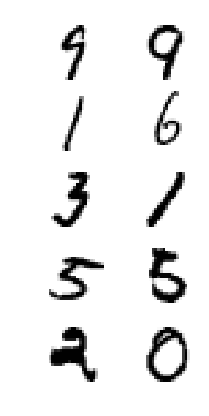

In [65]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

레이블을 확인해 보겠습니다(0은 "다른 것", 1은 "같은 것"을 의미합니다):

In [66]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

완벽하네요!

### 10.3.
_문제: 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다._

MNIST 테스트 세트에서 추출한 이미지 쌍으로 테스트 세트를 만듭니다:

In [67]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

이제 모델을 훈련시킵니다. `batch_size`가 크다는 것외에는 이 단계에 특별한 것은 없습니다. 배치 사이즈가 크지 않으면 모델이 학습을 실패하고 50% 정확도밖에 도달하지 못할 것입니다:

In [68]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.69103277
0 테스트 정확도: 0.542
1 훈련 손실: 0.60353535
2 훈련 손실: 0.5494604
3 훈련 손실: 0.47047246
4 훈련 손실: 0.4060757
5 훈련 손실: 0.3830816
5 테스트 정확도: 0.824
6 훈련 손실: 0.39047274
7 훈련 손실: 0.33907944
8 훈련 손실: 0.32106704
9 훈련 손실: 0.31792682
10 훈련 손실: 0.2449429
10 테스트 정확도: 0.8881
11 훈련 손실: 0.2929237
12 훈련 손실: 0.2322544
13 훈련 손실: 0.23180935
14 훈련 손실: 0.19877945
15 훈련 손실: 0.20065445
15 테스트 정확도: 0.9203
16 훈련 손실: 0.19700484
17 훈련 손실: 0.18893169
18 훈련 손실: 0.19965445
19 훈련 손실: 0.24071623
20 훈련 손실: 0.18882048
20 테스트 정확도: 0.9367
21 훈련 손실: 0.124192186
22 훈련 손실: 0.1401344
23 훈련 손실: 0.12078959
24 훈련 손실: 0.15721178
25 훈련 손실: 0.11507866
25 테스트 정확도: 0.948
26 훈련 손실: 0.13891123
27 훈련 손실: 0.15260853
28 훈련 손실: 0.12343661
29 훈련 손실: 0.11543142
30 훈련 손실: 0.114027806
30 테스트 정확도: 0.9507
31 훈련 손실: 0.11897193
32 훈련 손실: 0.09546791
33 훈련 손실: 0.08299375
34 훈련 손실: 0.13659406
35 훈련 손실: 0.06801656
35 테스트 정확도: 0.9592
36 훈련 손실: 0.110167034
37 훈련 손실: 0.049502444
38 훈련 손실: 0.0813376
39 훈련 손실: 0.09441994
40 훈련 손실: 0.08737232
40 테스트

좋습니다. 숫자 비교 작업에서 97.6% 정확도를 달성했습니다. 아주 나쁘지 않네요. 이 모델은 손글씨 숫자를 비교하는 능력을 갖추었습니다!

이 지식을 일반 MNIST 분류 문제에 사용할 수 있는지 확인해 보겠습니다.

### 10.4.
_문제: 이제 DNN A의 은닉층을 동결해서 재사용하고 10개의 뉴런으로 된 소프트맥스 출력 층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요._

모델을 만드는 것은 매우 간단합니다. 하위층을 동결하는 방법이 많이 있습니다. 이 예제에서는 `tf.stop_gradient()` 함수를 사용하겠습니다. 미리 학습된 DNN A를 복원하기 위해 `Saver` 객체가 필요하고 최종 모델을 저장하기 위해 다른 `Saver` 객체가 필요합니다:

In [69]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

이제 훈련입니다! 모든 변수를 초기화하고(새 출력층의 변수를 포함하여), 미리 학습된 DNN A를 복원합니다. 다음에 작은 MNIST 데이터셋(5,000개 이미지)에 이 모델을 훈련시킵니다:

In [70]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9456
10 테스트 정확도: 0.9627
20 테스트 정확도: 0.9665
30 테스트 정확도: 0.9663
40 테스트 정확도: 0.9665
50 테스트 정확도: 0.9664
60 테스트 정확도: 0.9664
70 테스트 정확도: 0.9663
80 테스트 정확도: 0.9663
90 테스트 정확도: 0.9664


오 96.7% 정확도네요. 지금까지 훈련시킨 최고의 MNIST 모델은 아니지만 아주 작은 훈련 세트(숫자당 500개 이미지)를 사용한 것을 유념하세요. 전이 학습을 사용하지 않고 그냥 처음부터 학습시킨 DNN과 결과를 비교해 보겠습니다:

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [72]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8694
10 테스트 정확도: 0.9276
20 테스트 정확도: 0.9307
30 테스트 정확도: 0.9419
40 테스트 정확도: 0.9427
50 테스트 정확도: 0.9428
60 테스트 정확도: 0.9429
70 테스트 정확도: 0.9432
80 테스트 정확도: 0.9428
90 테스트 정확도: 0.9427
100 테스트 정확도: 0.9427
110 테스트 정확도: 0.9426
120 테스트 정확도: 0.9426
130 테스트 정확도: 0.9425
140 테스트 정확도: 0.9425


94.8% 정확도 밖에 안되네요. 전이 학습이 에러율를 5.2%에서 3.3%로 낮추어 주었습니다(36% 이상 에러가 감소했습니다). 더군다나 전이 학습을 사용한 모델은 10번의 에포크만에 96%의 정확도에 도달했습니다.

최종 결과: 전이 학습이 항상 좋은 결과를 내지는 않습니다(연습문제 9에서 보았듯이). 하지만 그렇지 않을 땐 아주 큰 차이를 만들 수 있습니다. 그러므로 꼭 시도해 보세요!